# Analysis of neuron networks, as they change over time.

In [1]:
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from analysis.graph_analysis_utils import NeuronNetwork
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sns.set_style("darkgrid")

In [4]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
3. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
4. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
5. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
6. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
7. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [5]:
data = pd.read_csv(raw_files[4], header=None)
data = FeatureExtractor.downsample_dataframe(data, 2)
_, auc_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [6]:
beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[5], header=None)
drd77_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Rename all the columns from "neuron_x" --> "x". This makes the graphs neater by making sure the neuron names fit into the nodes
drd77_fe.cell_transients_df.columns = [i for i in range(1, len(cell_transients_dataframe.columns)+1)]

In [7]:
def bin_by_time(dataframe, **kwargs):
    """Split dataframe by frequency
    
    Split up the time series data into specified time bins. 
    
    Args: 
        dataframe: DataFrame
        
            a pandas DataFrame of the signal data for 
            all the imaged neurons of a given animal activity.
        
        freq: string, optional
            
            If specified, this is the frequency by which the 
            passed DataFrame will be split. The default is 
            1Min.
    
    Returns: 
        time_bins: dictionary
            
            All of the DataFrames that encompasse the passed-in
            DataFrame.
    """
    
    # Create copy of the dataframe for a certain behavior
    time_binned_df = dataframe.copy()
    time_binned_df.reset_index(drop=True, inplace=True)
    
    # Add a column of the trial time in the form of time deltas
    x = pd.to_timedelta("0.1s")
    time_binned_df.loc[:, "TIME"] = pd.Series(x*i for i in (time_binned_df.index))
    
    # Group the dataframe by 1 minute intervals
    grouped = time_binned_df.set_index("TIME").groupby(pd.Grouper(freq=kwargs.get("freq", "1Min")))
    
    # Place each dataframe that contains the data for every 1 minute intervals into a dictionary
    time_bins = {}
    freq = 0
    for name, group in grouped:
        time_bins[freq] = grouped.get_group(name)
        freq += 1
        
    return time_bins

# We begin by plotting the networks, over time, for activity recorded in the **OpenArms**, and in the **ClosedArms**

## In accordance with Network neuroscience (Bassett & Sporns 2017), we plot the state of the network of neurons for DRD87 for the duration of the EPM experiment.

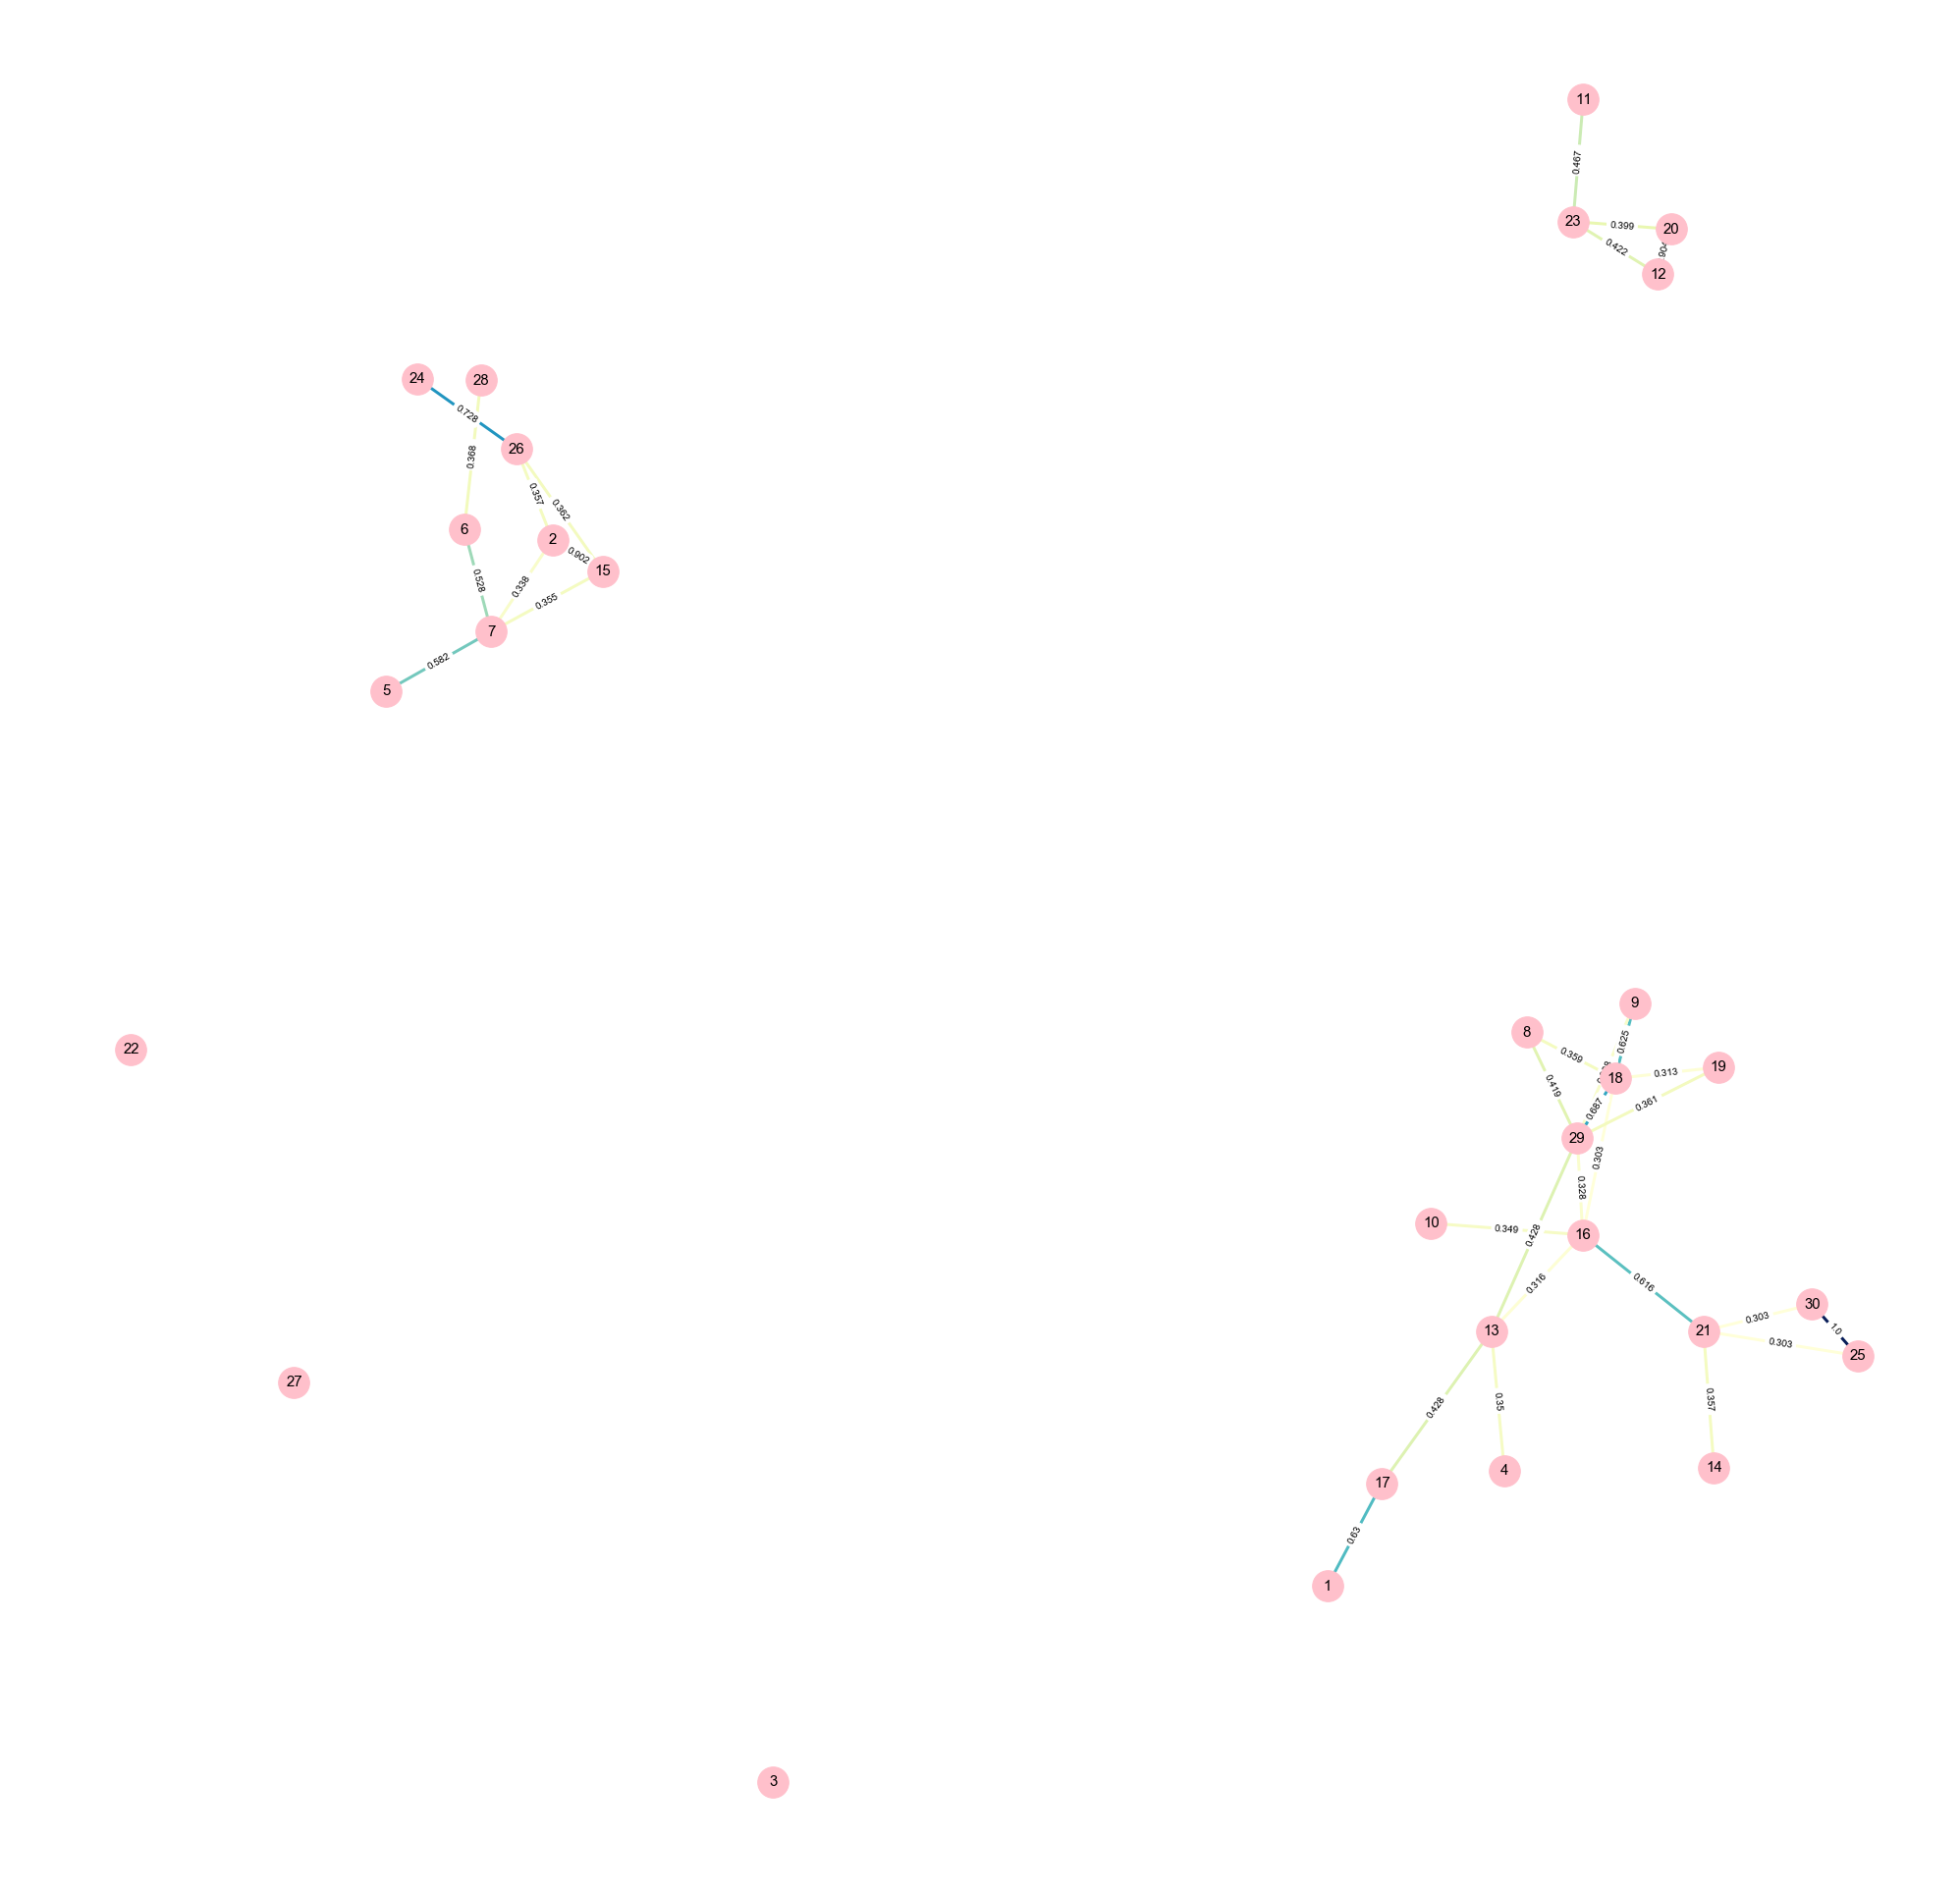

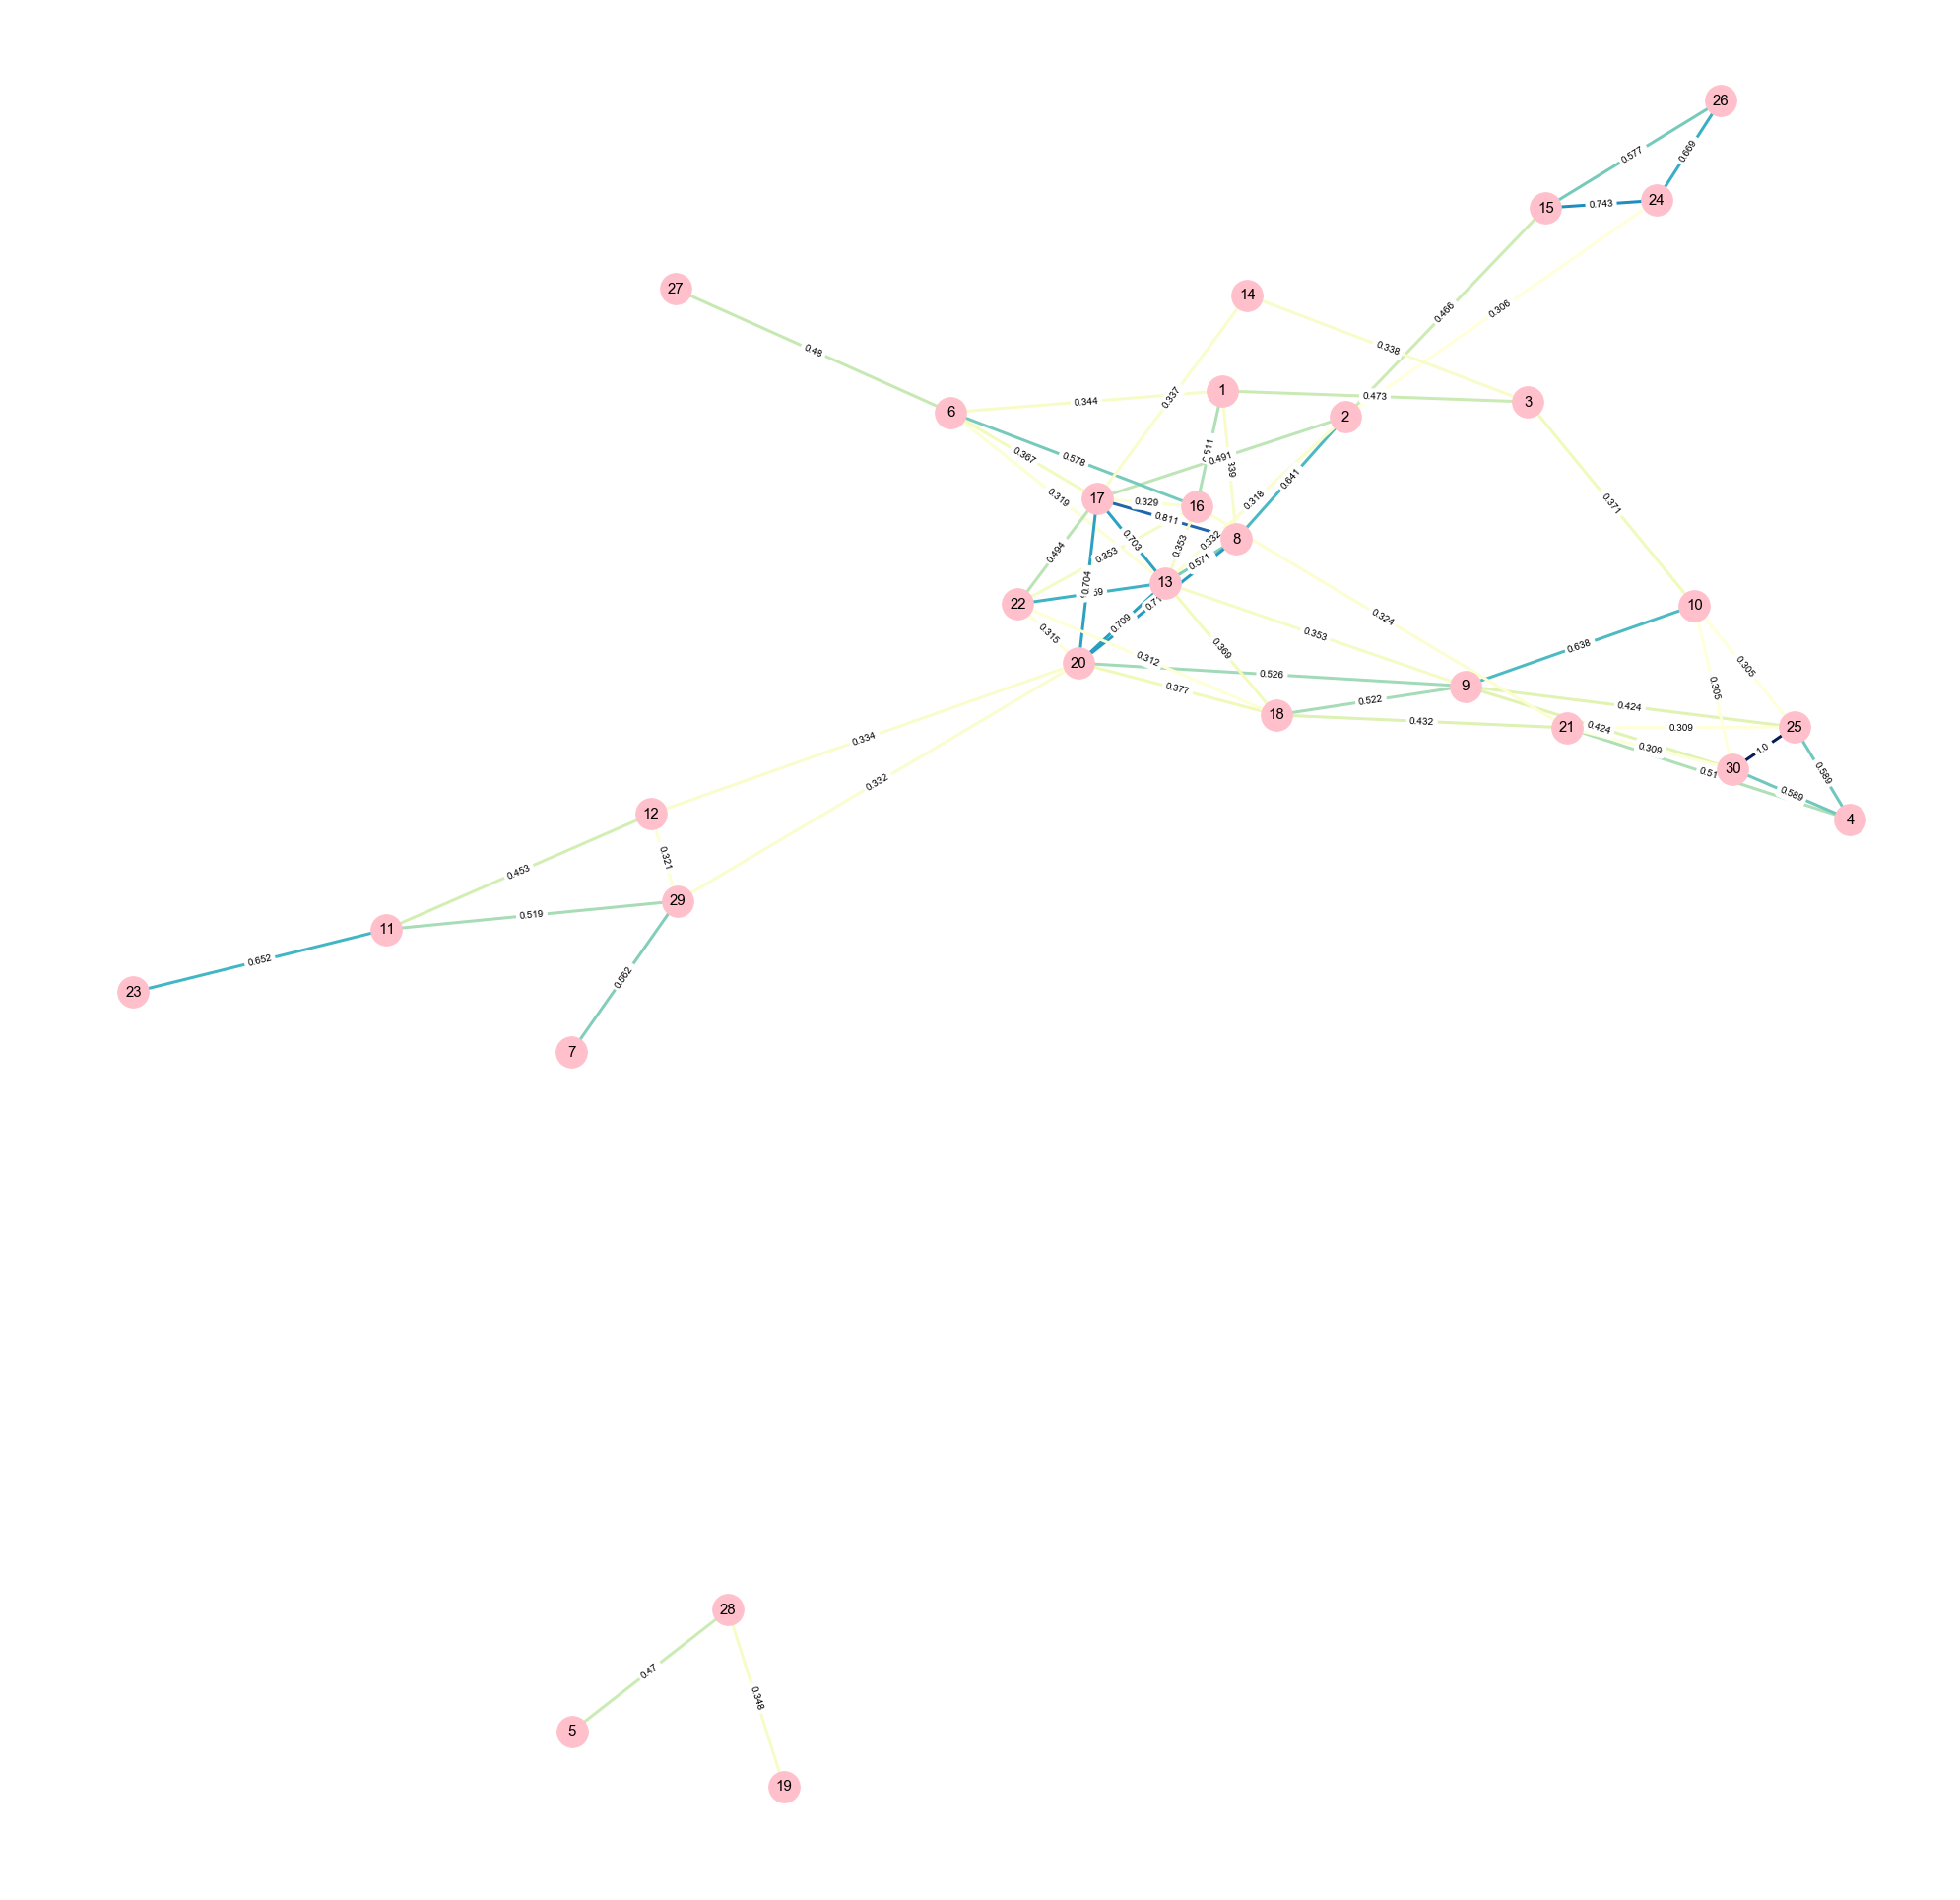

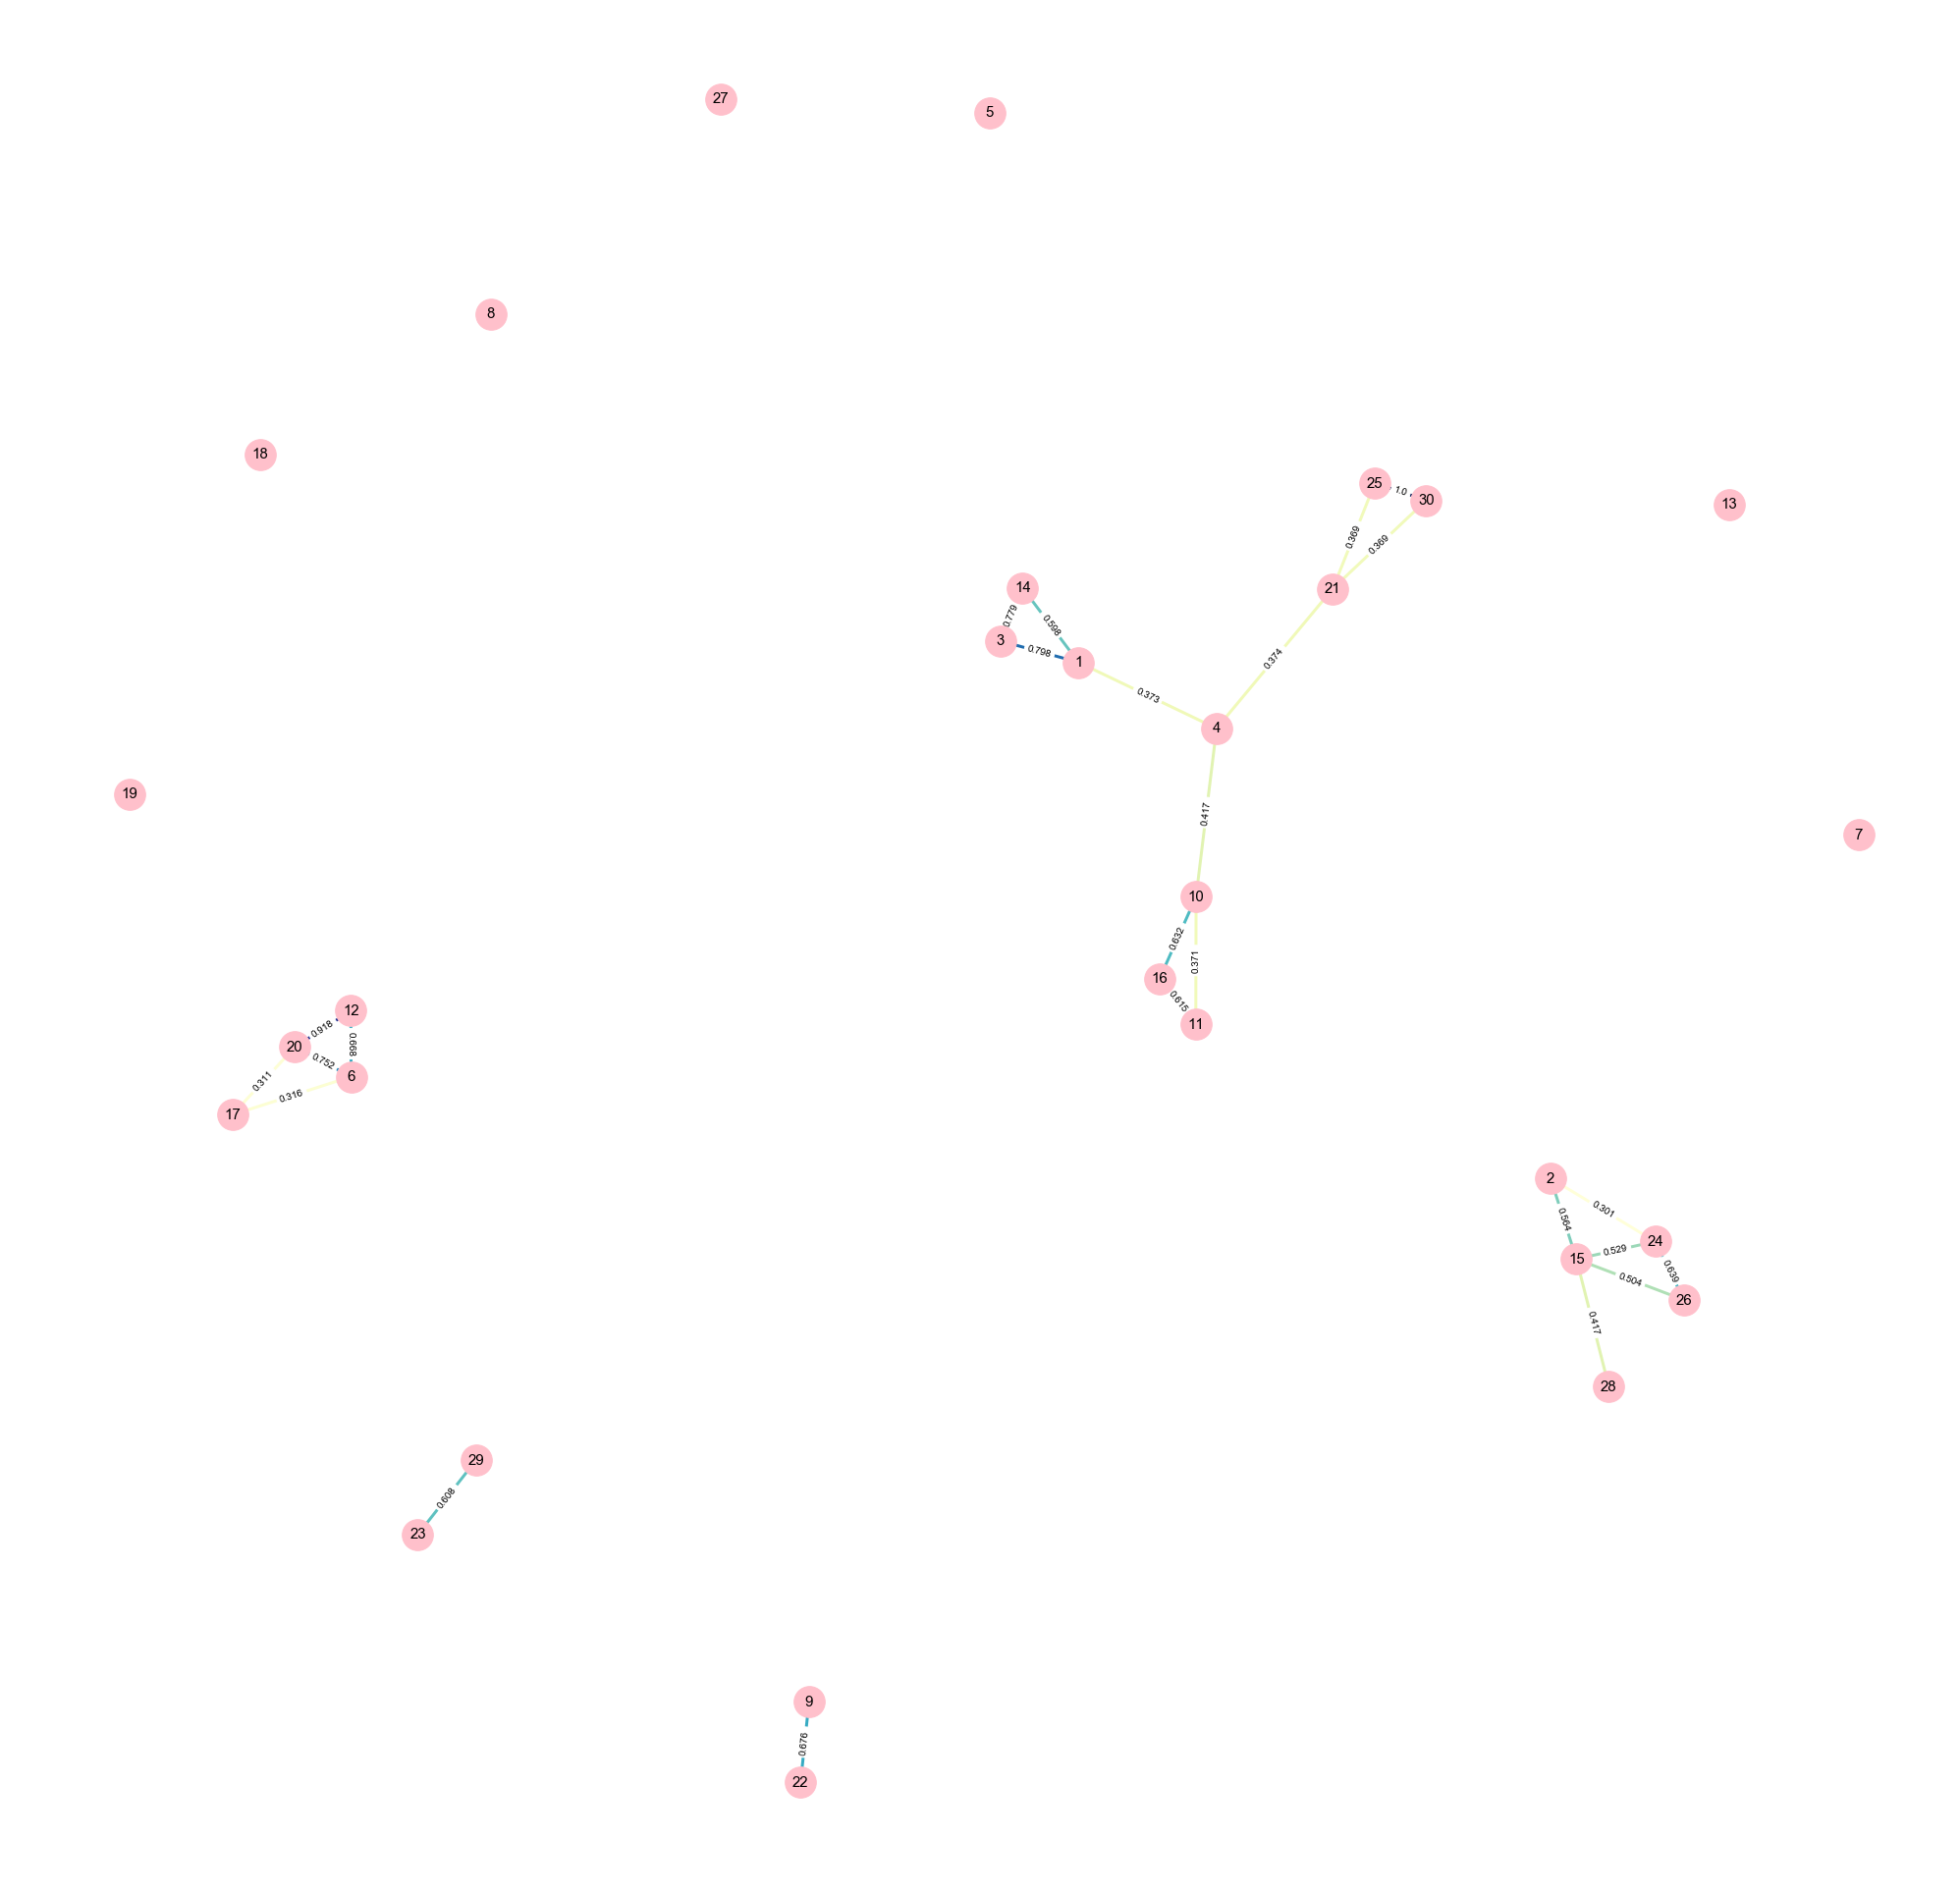

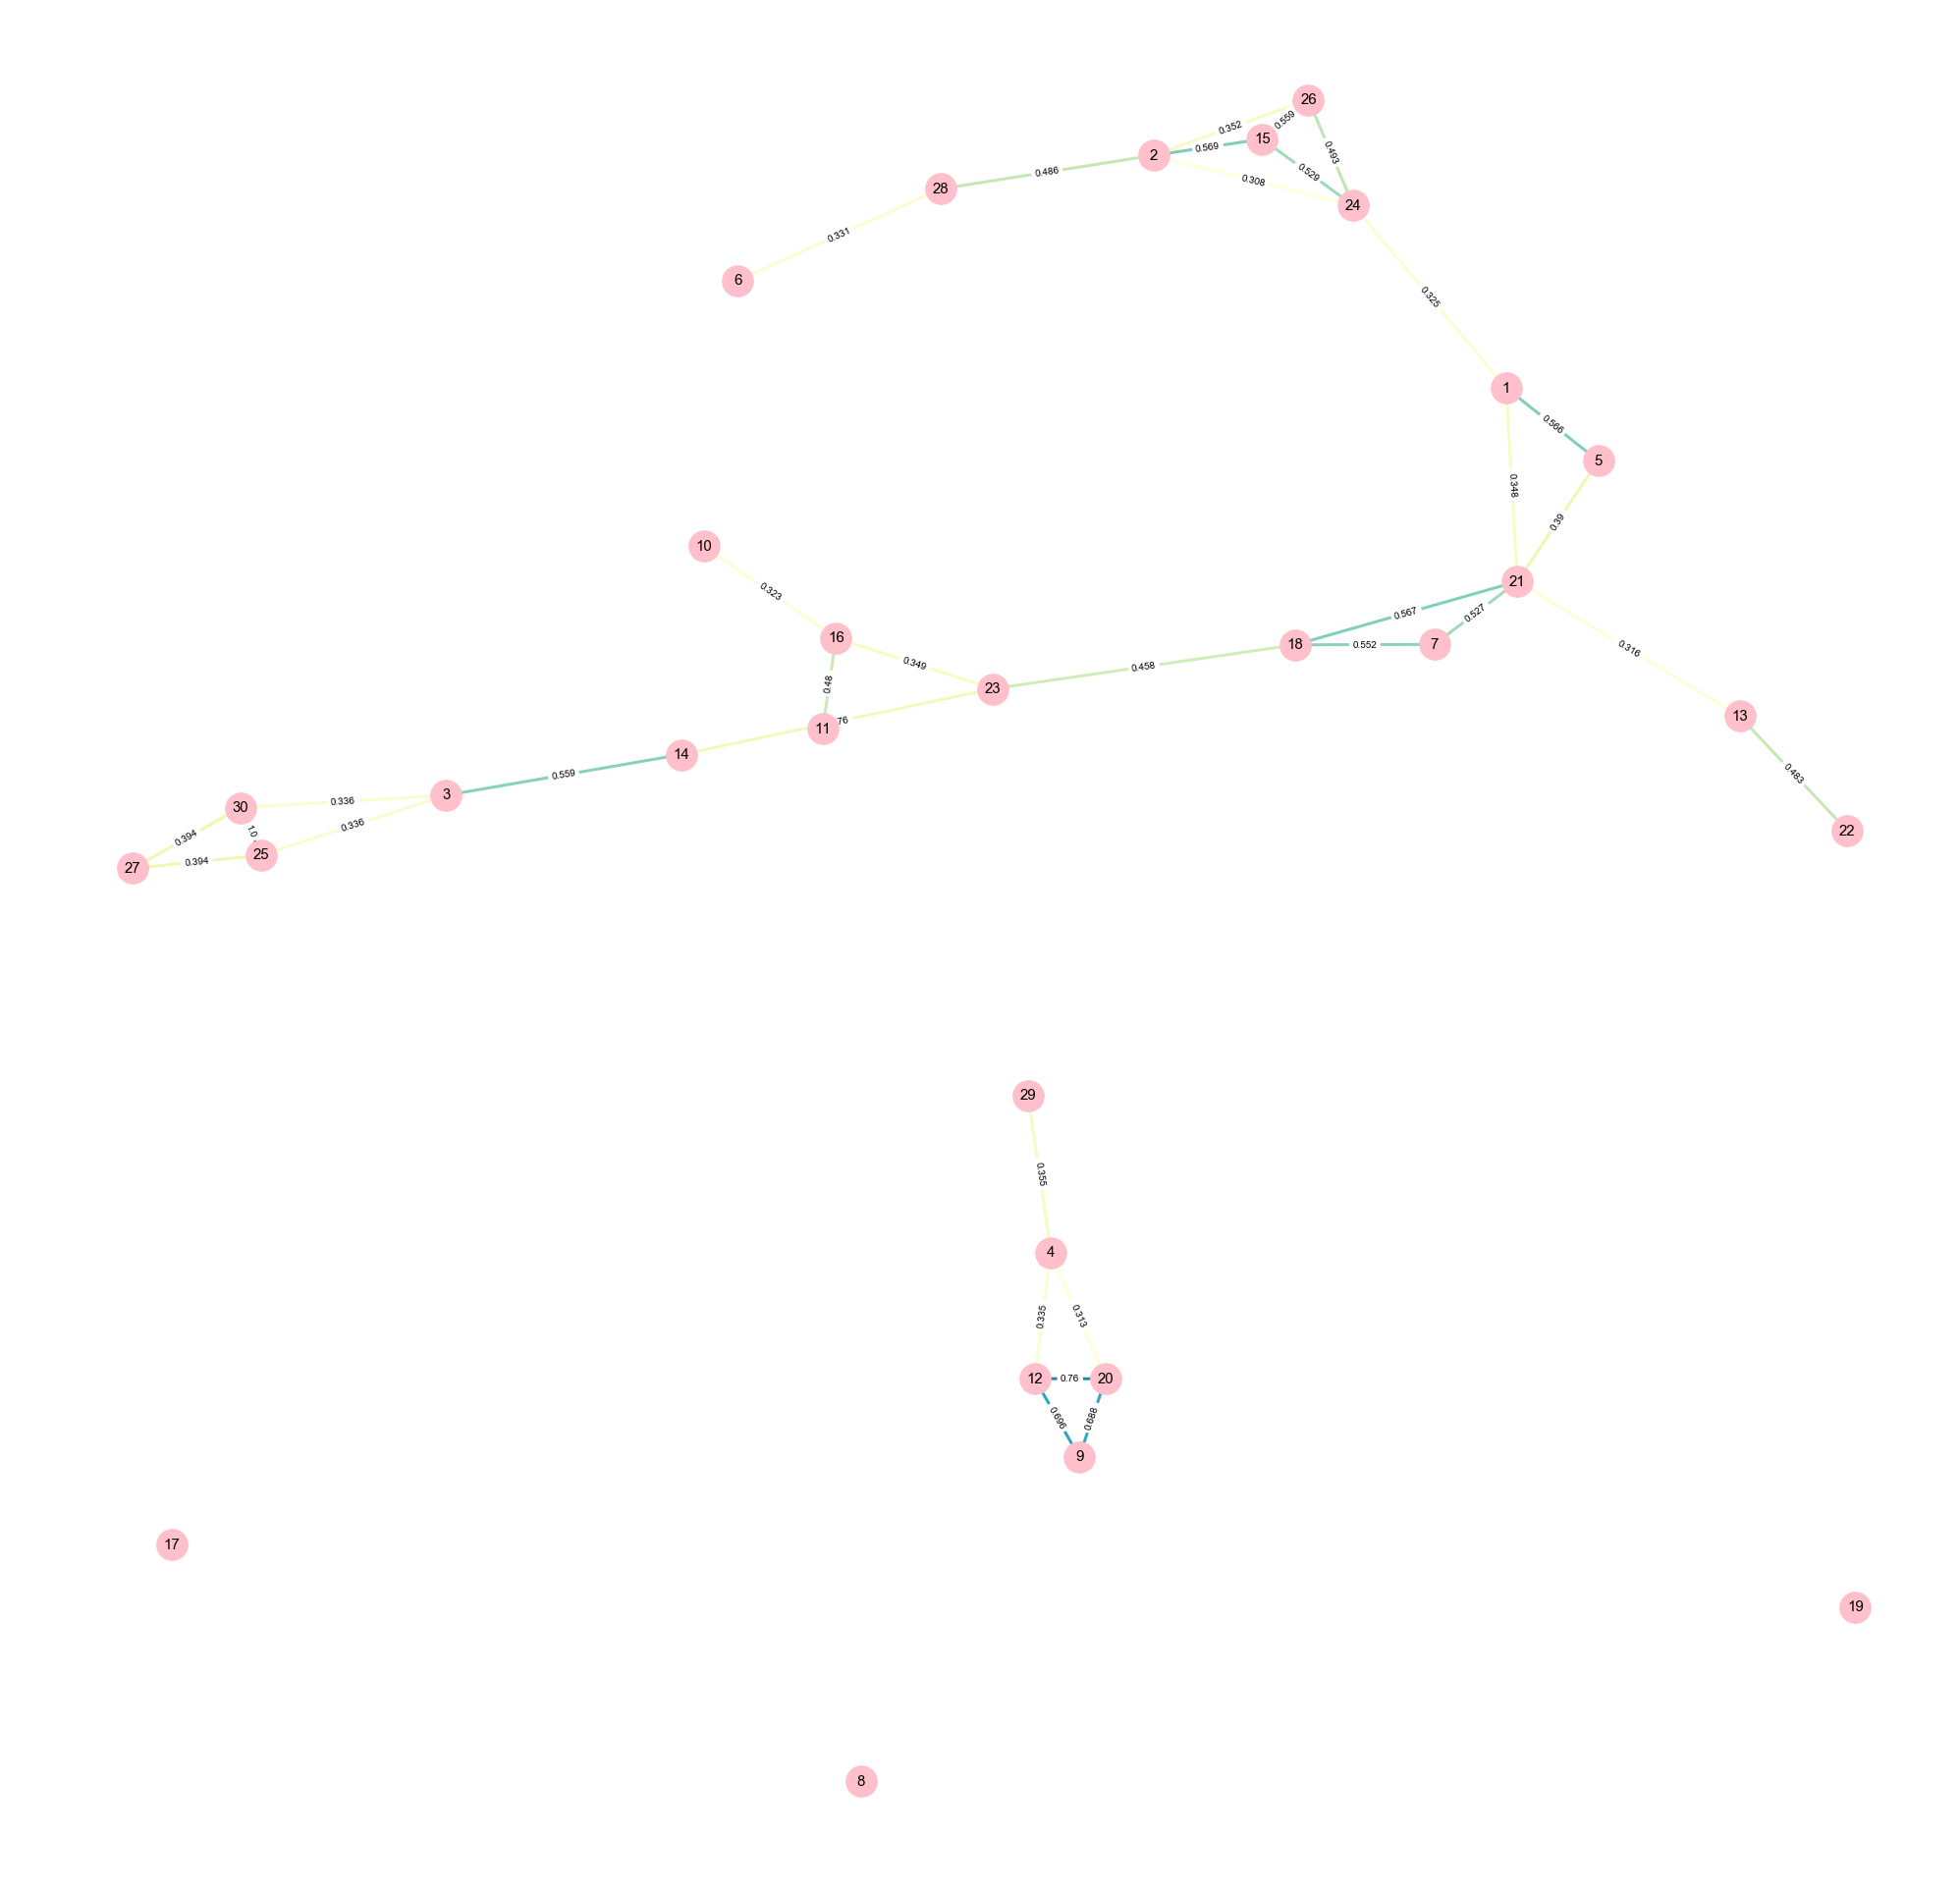

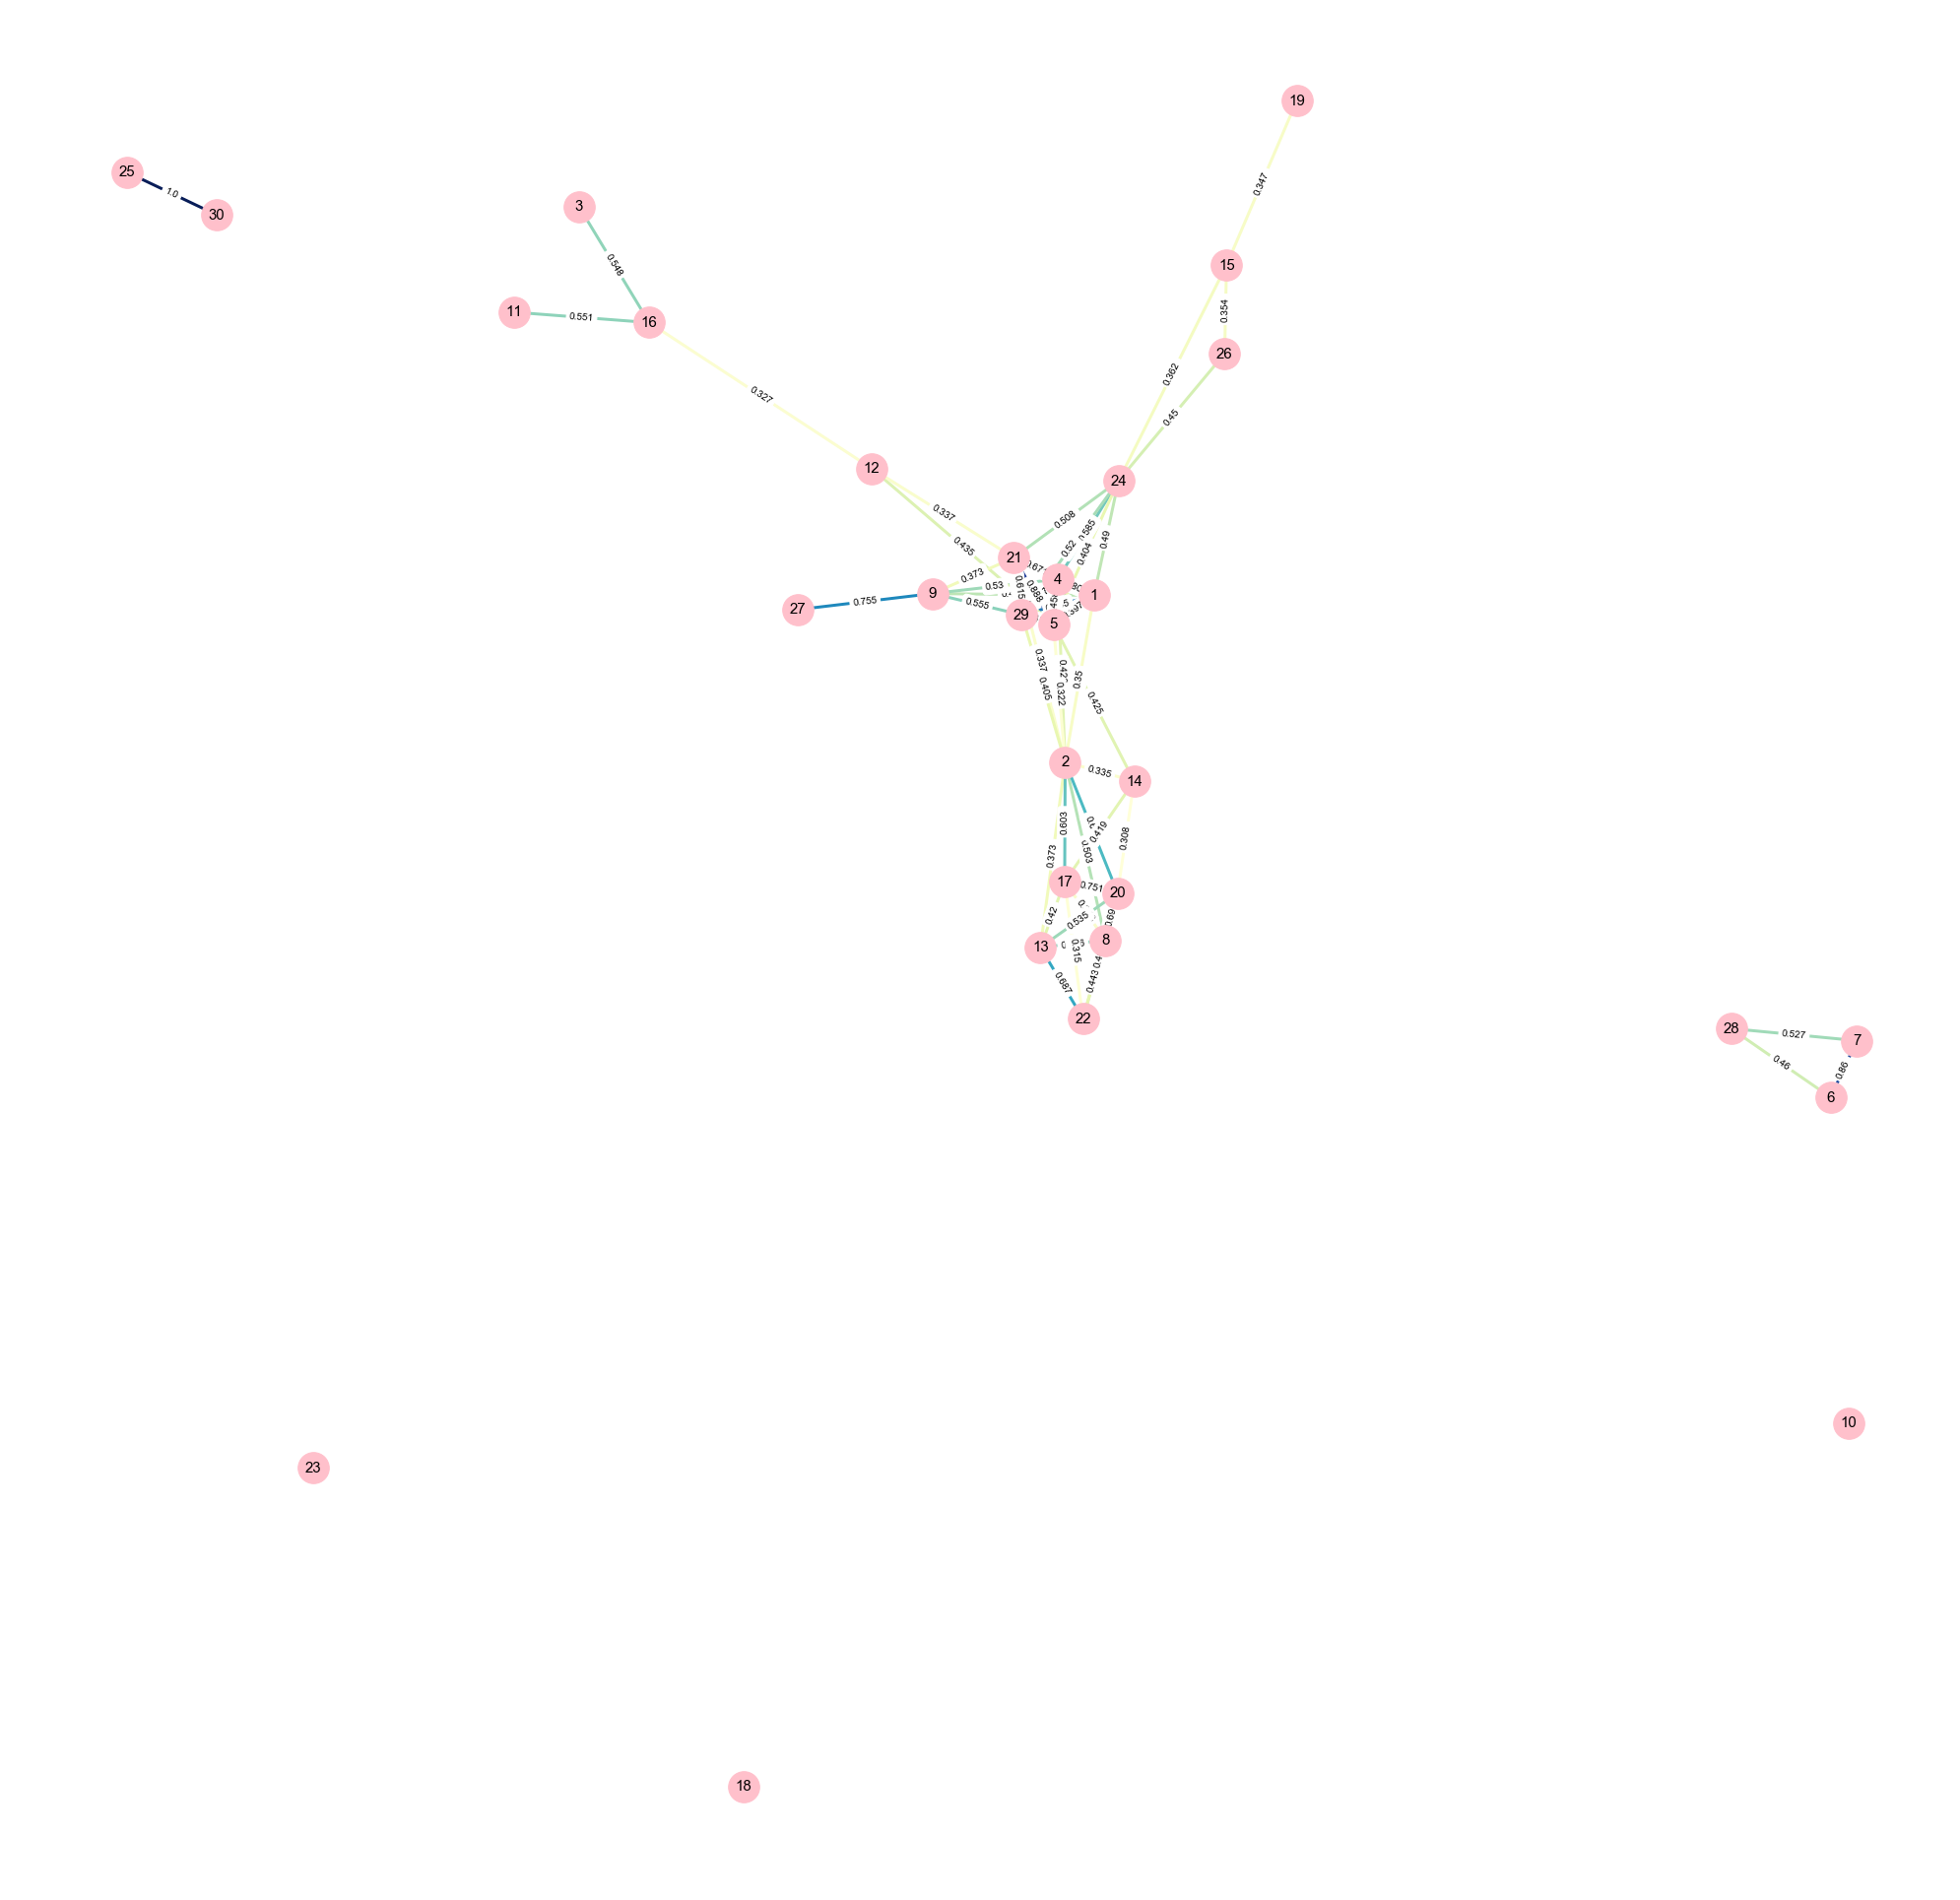

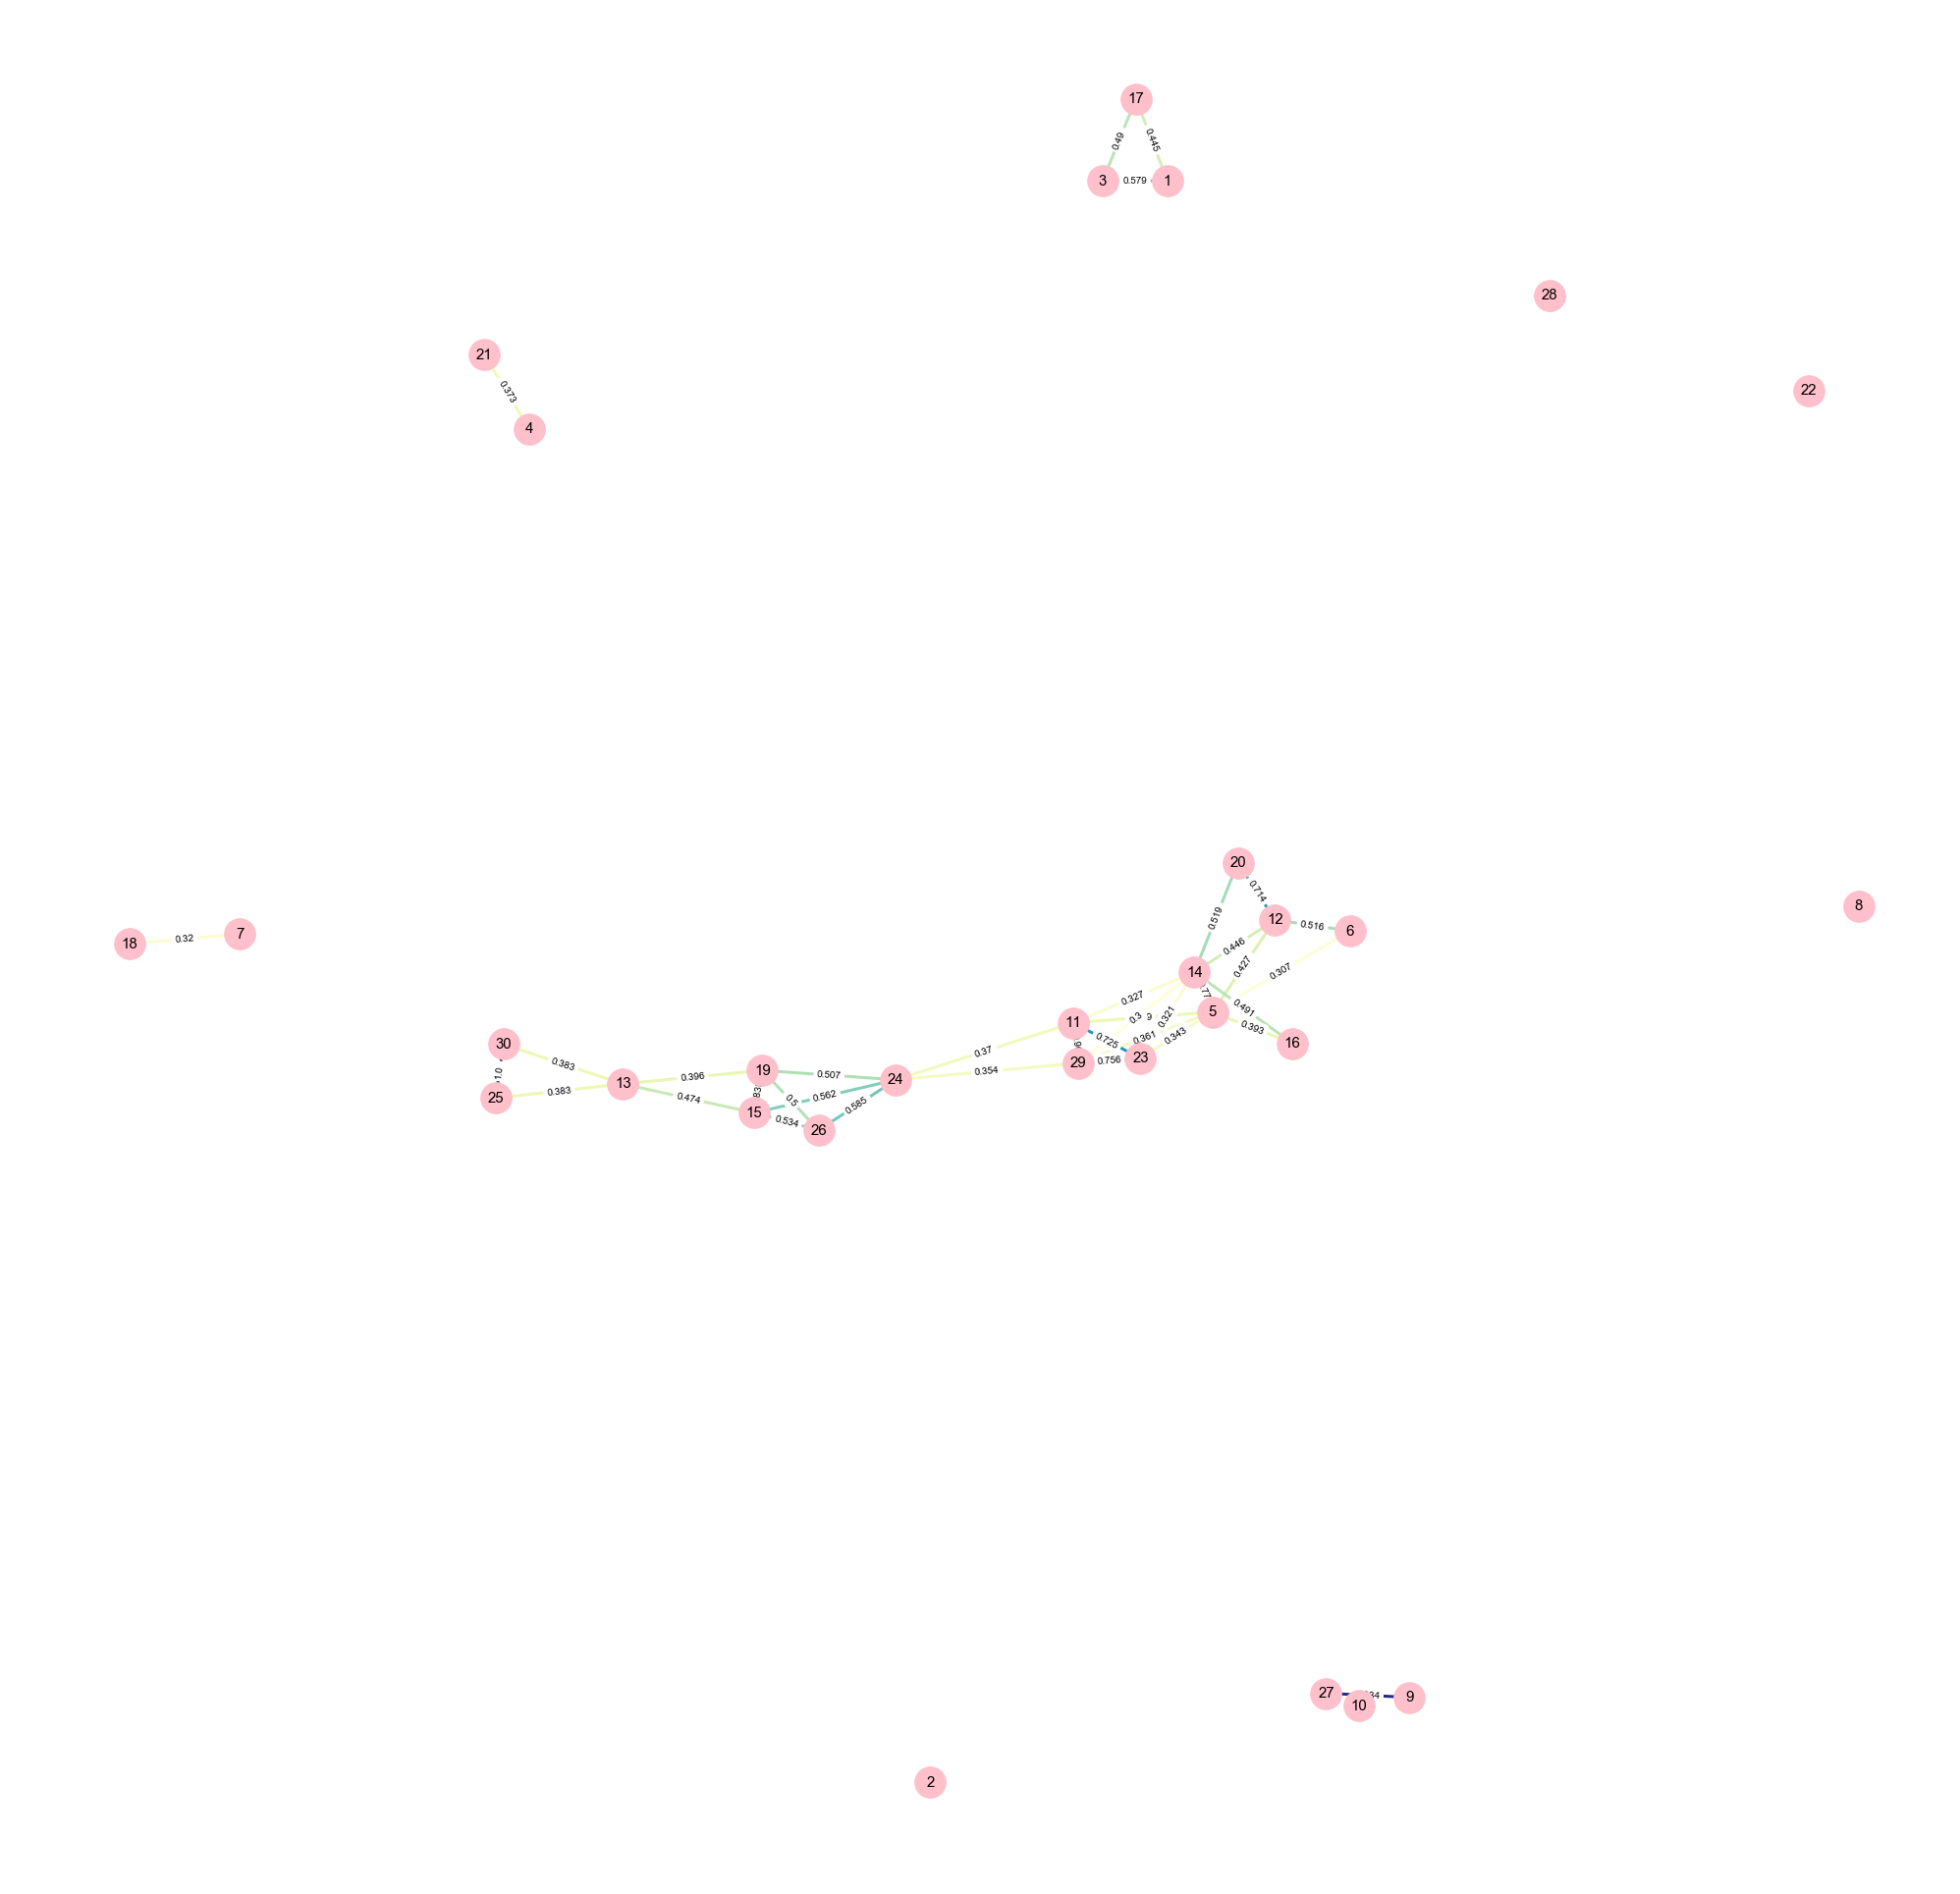

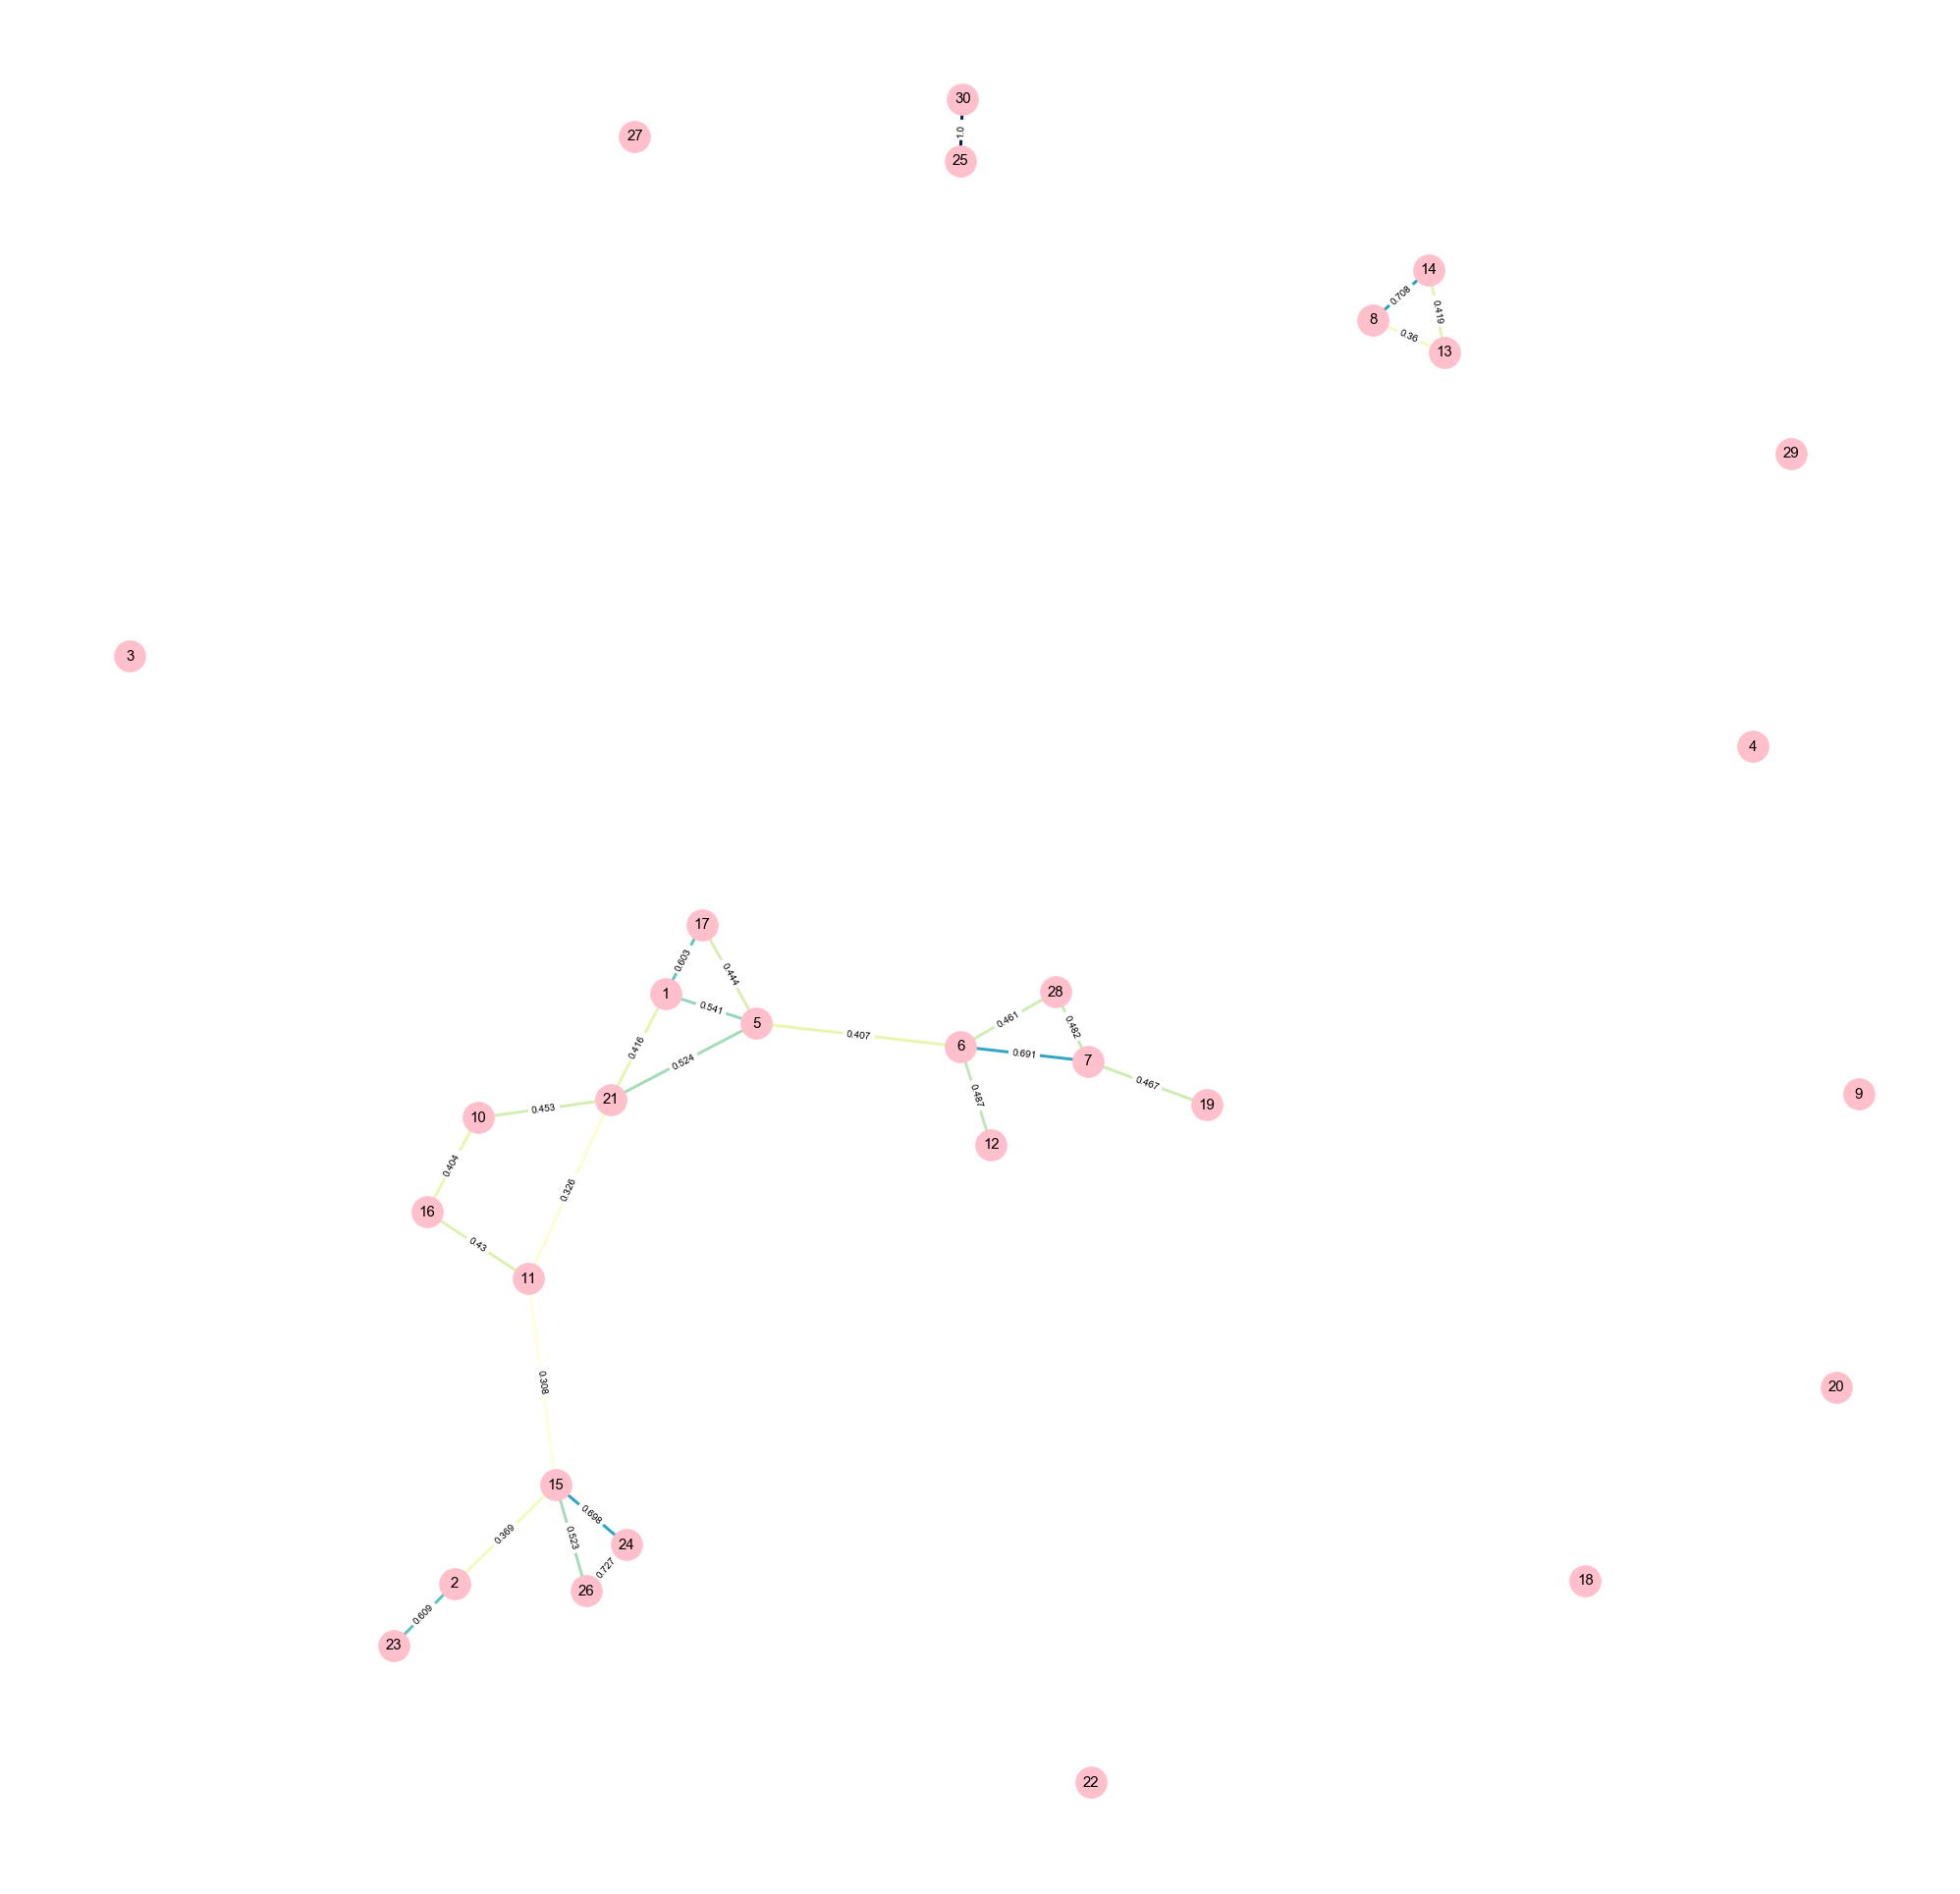

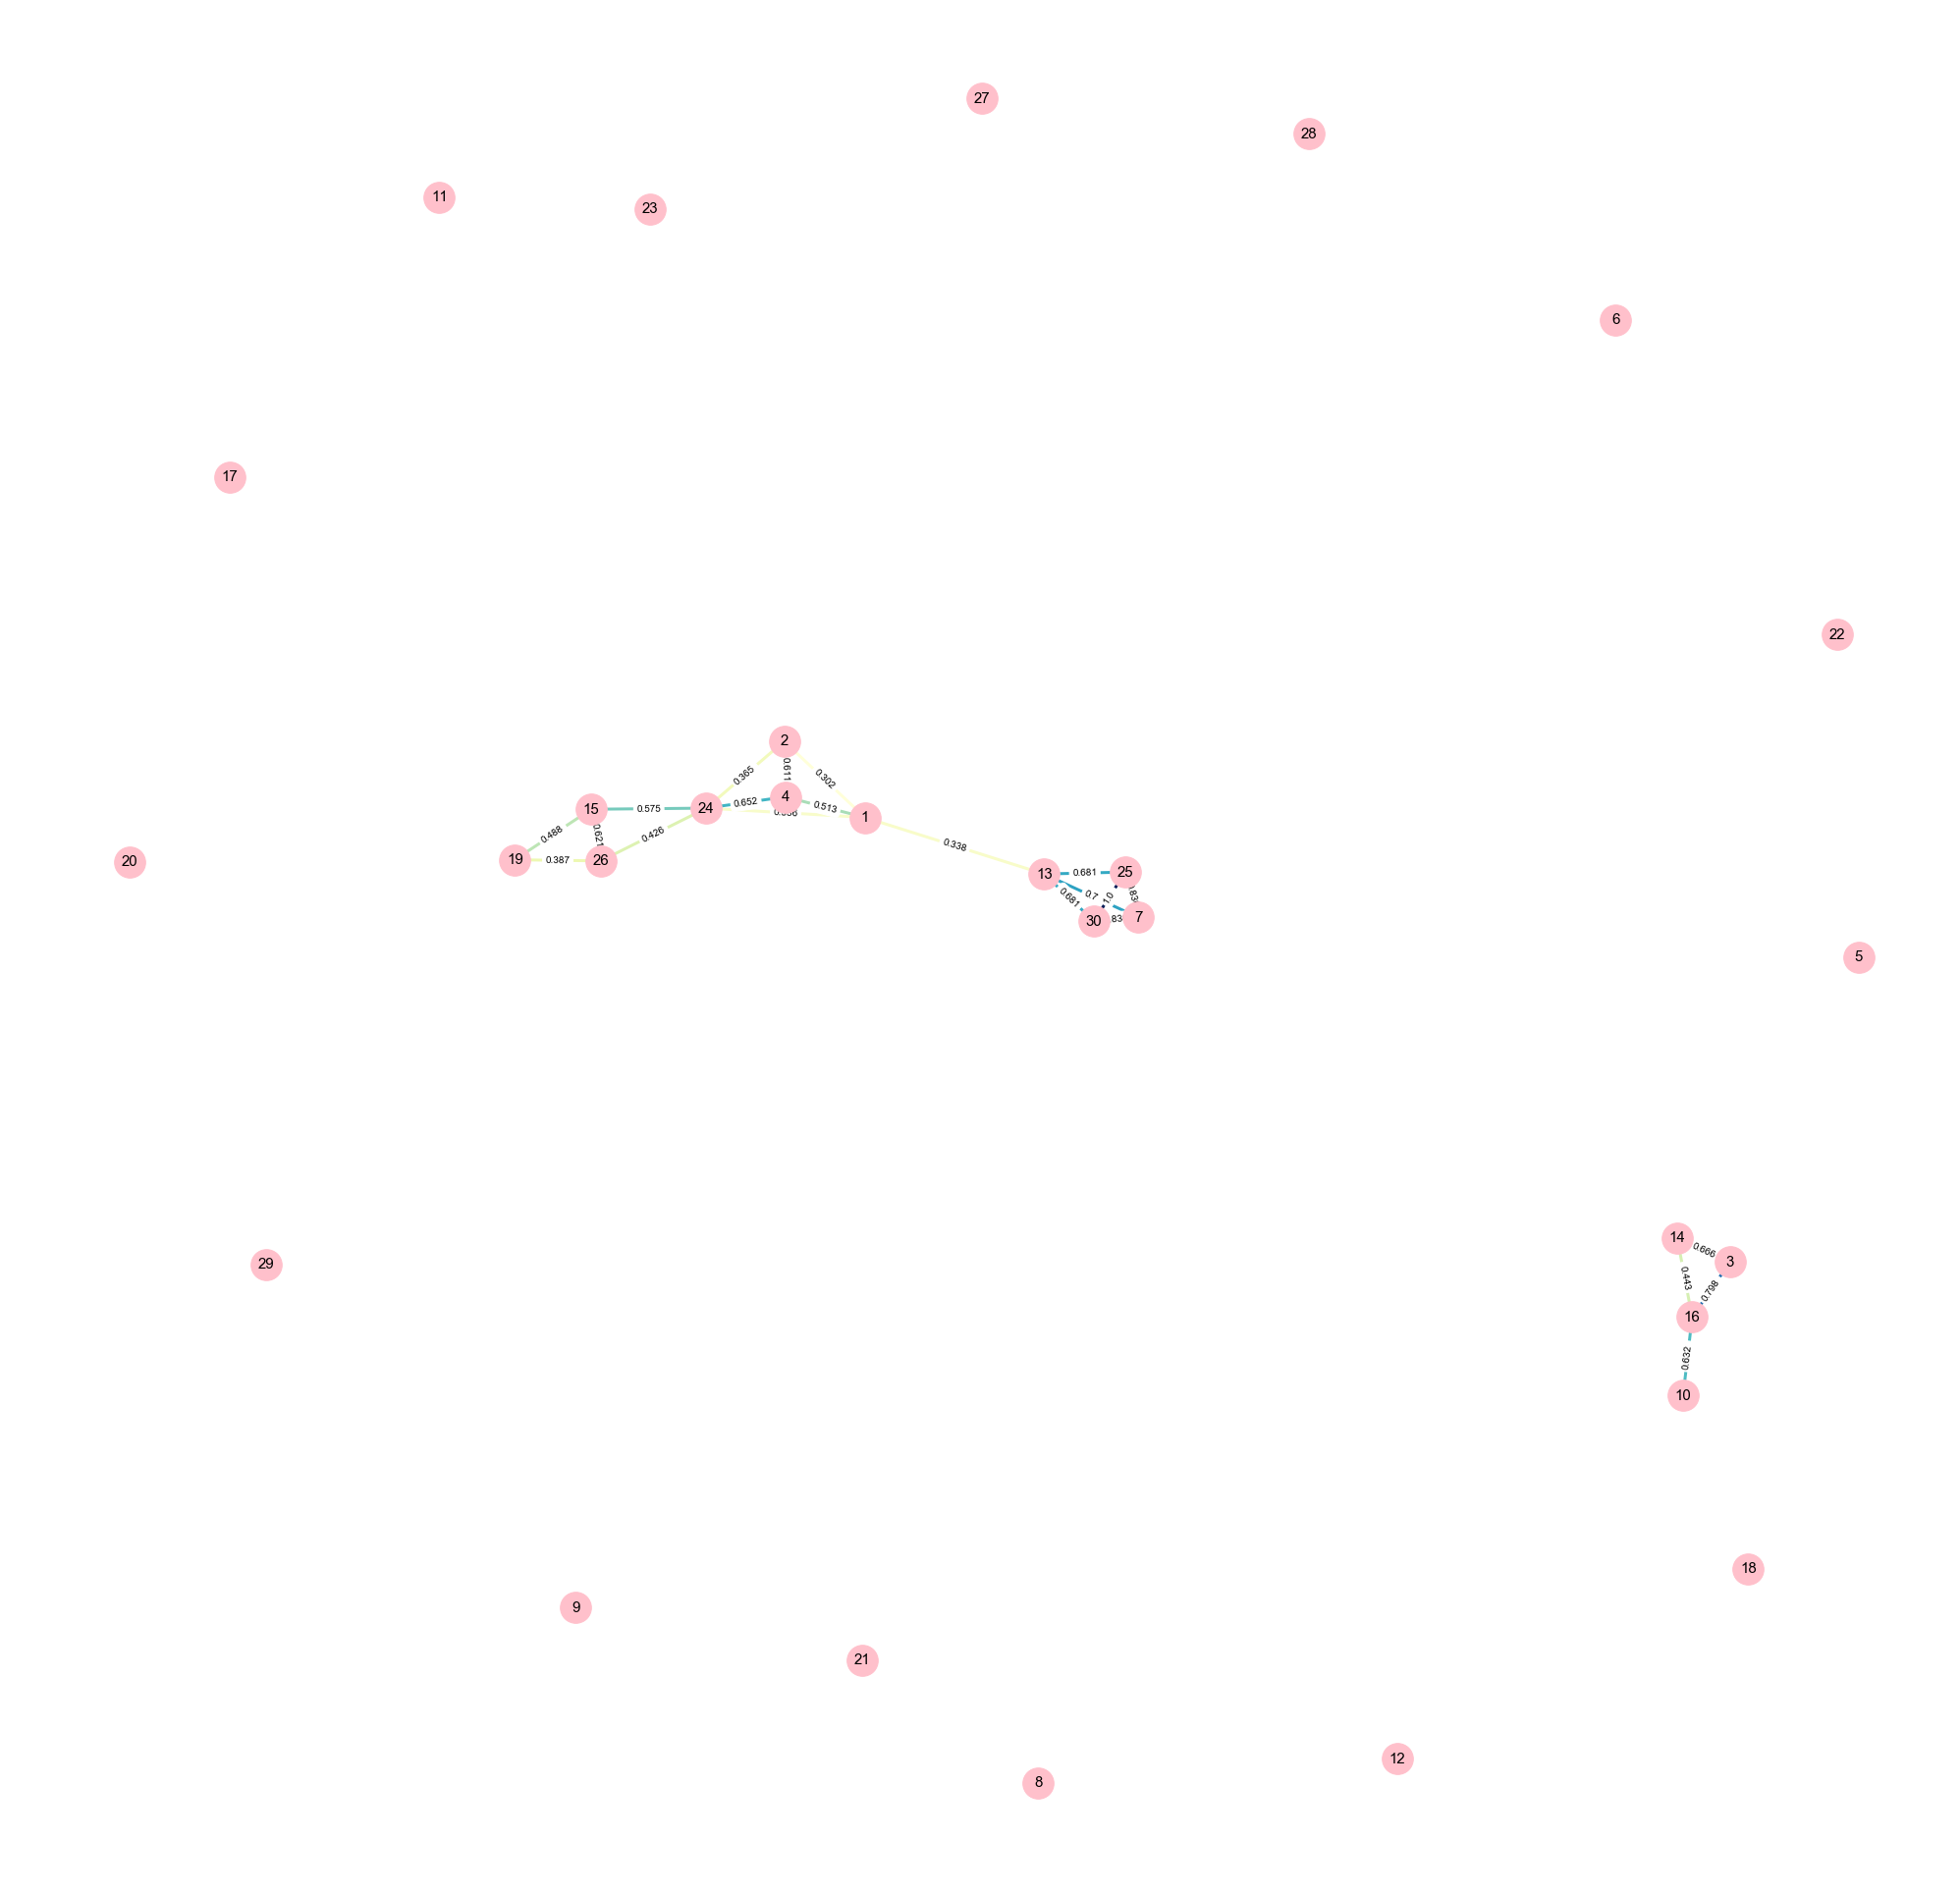

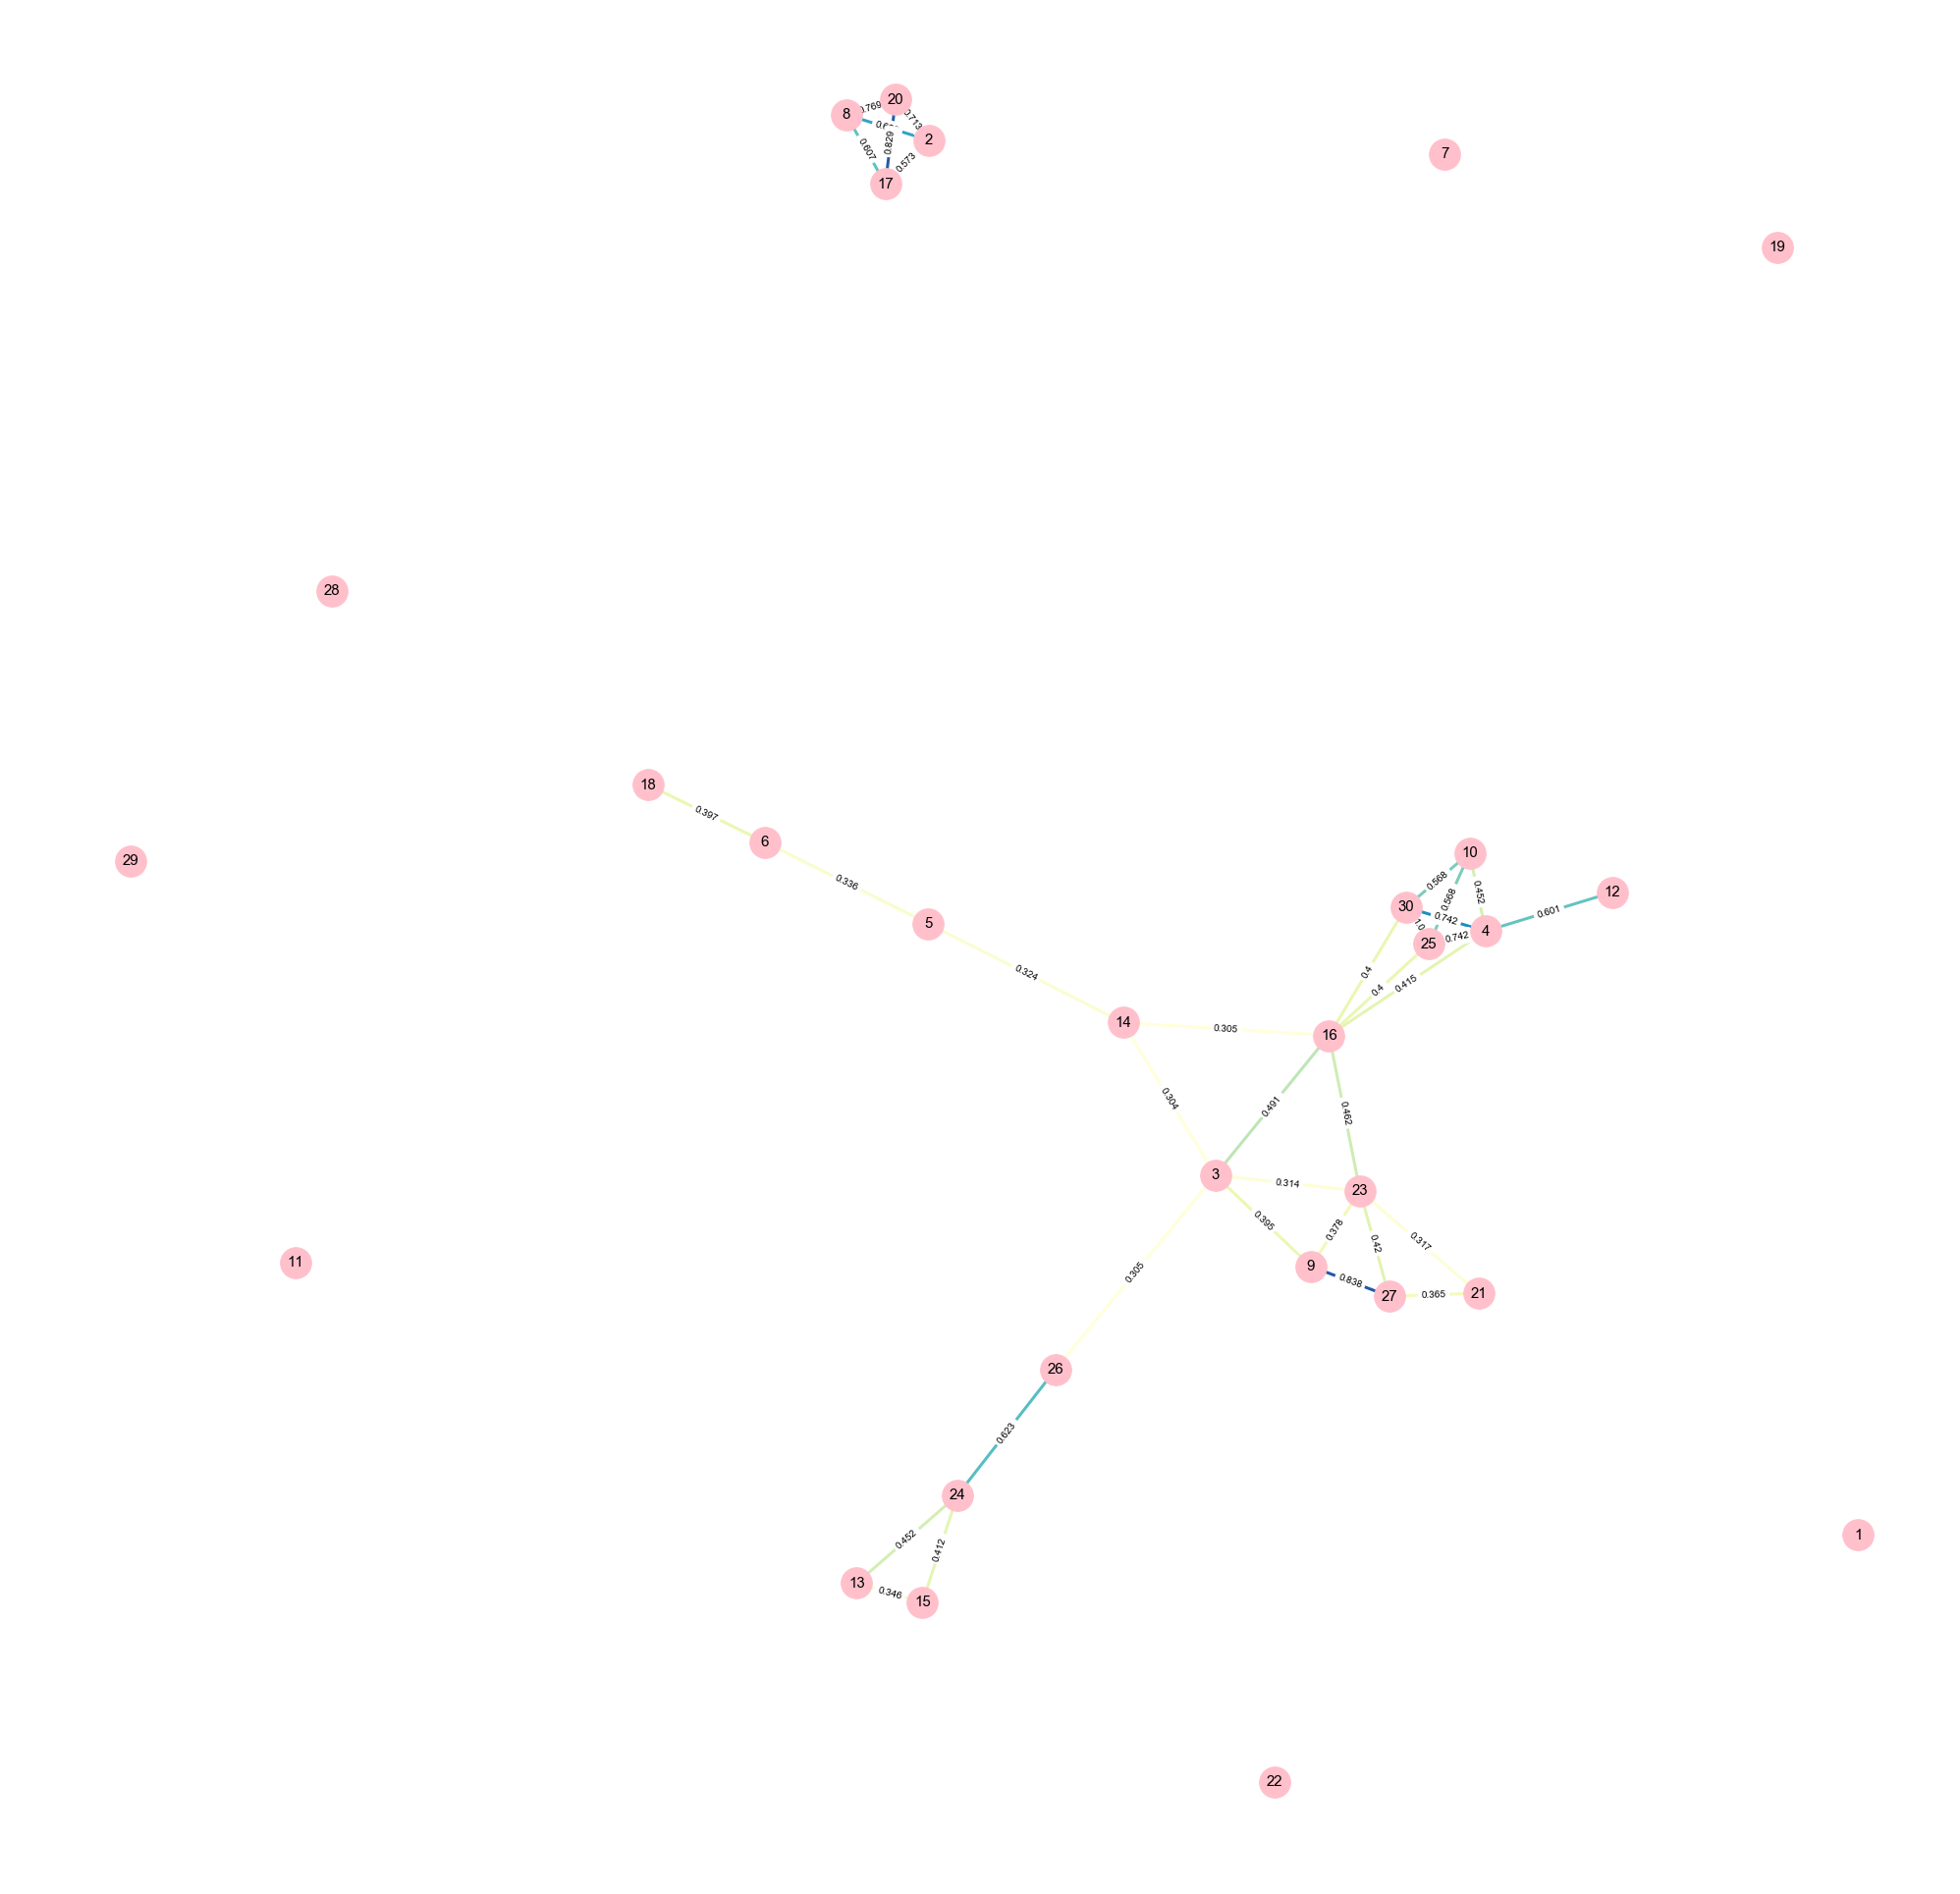

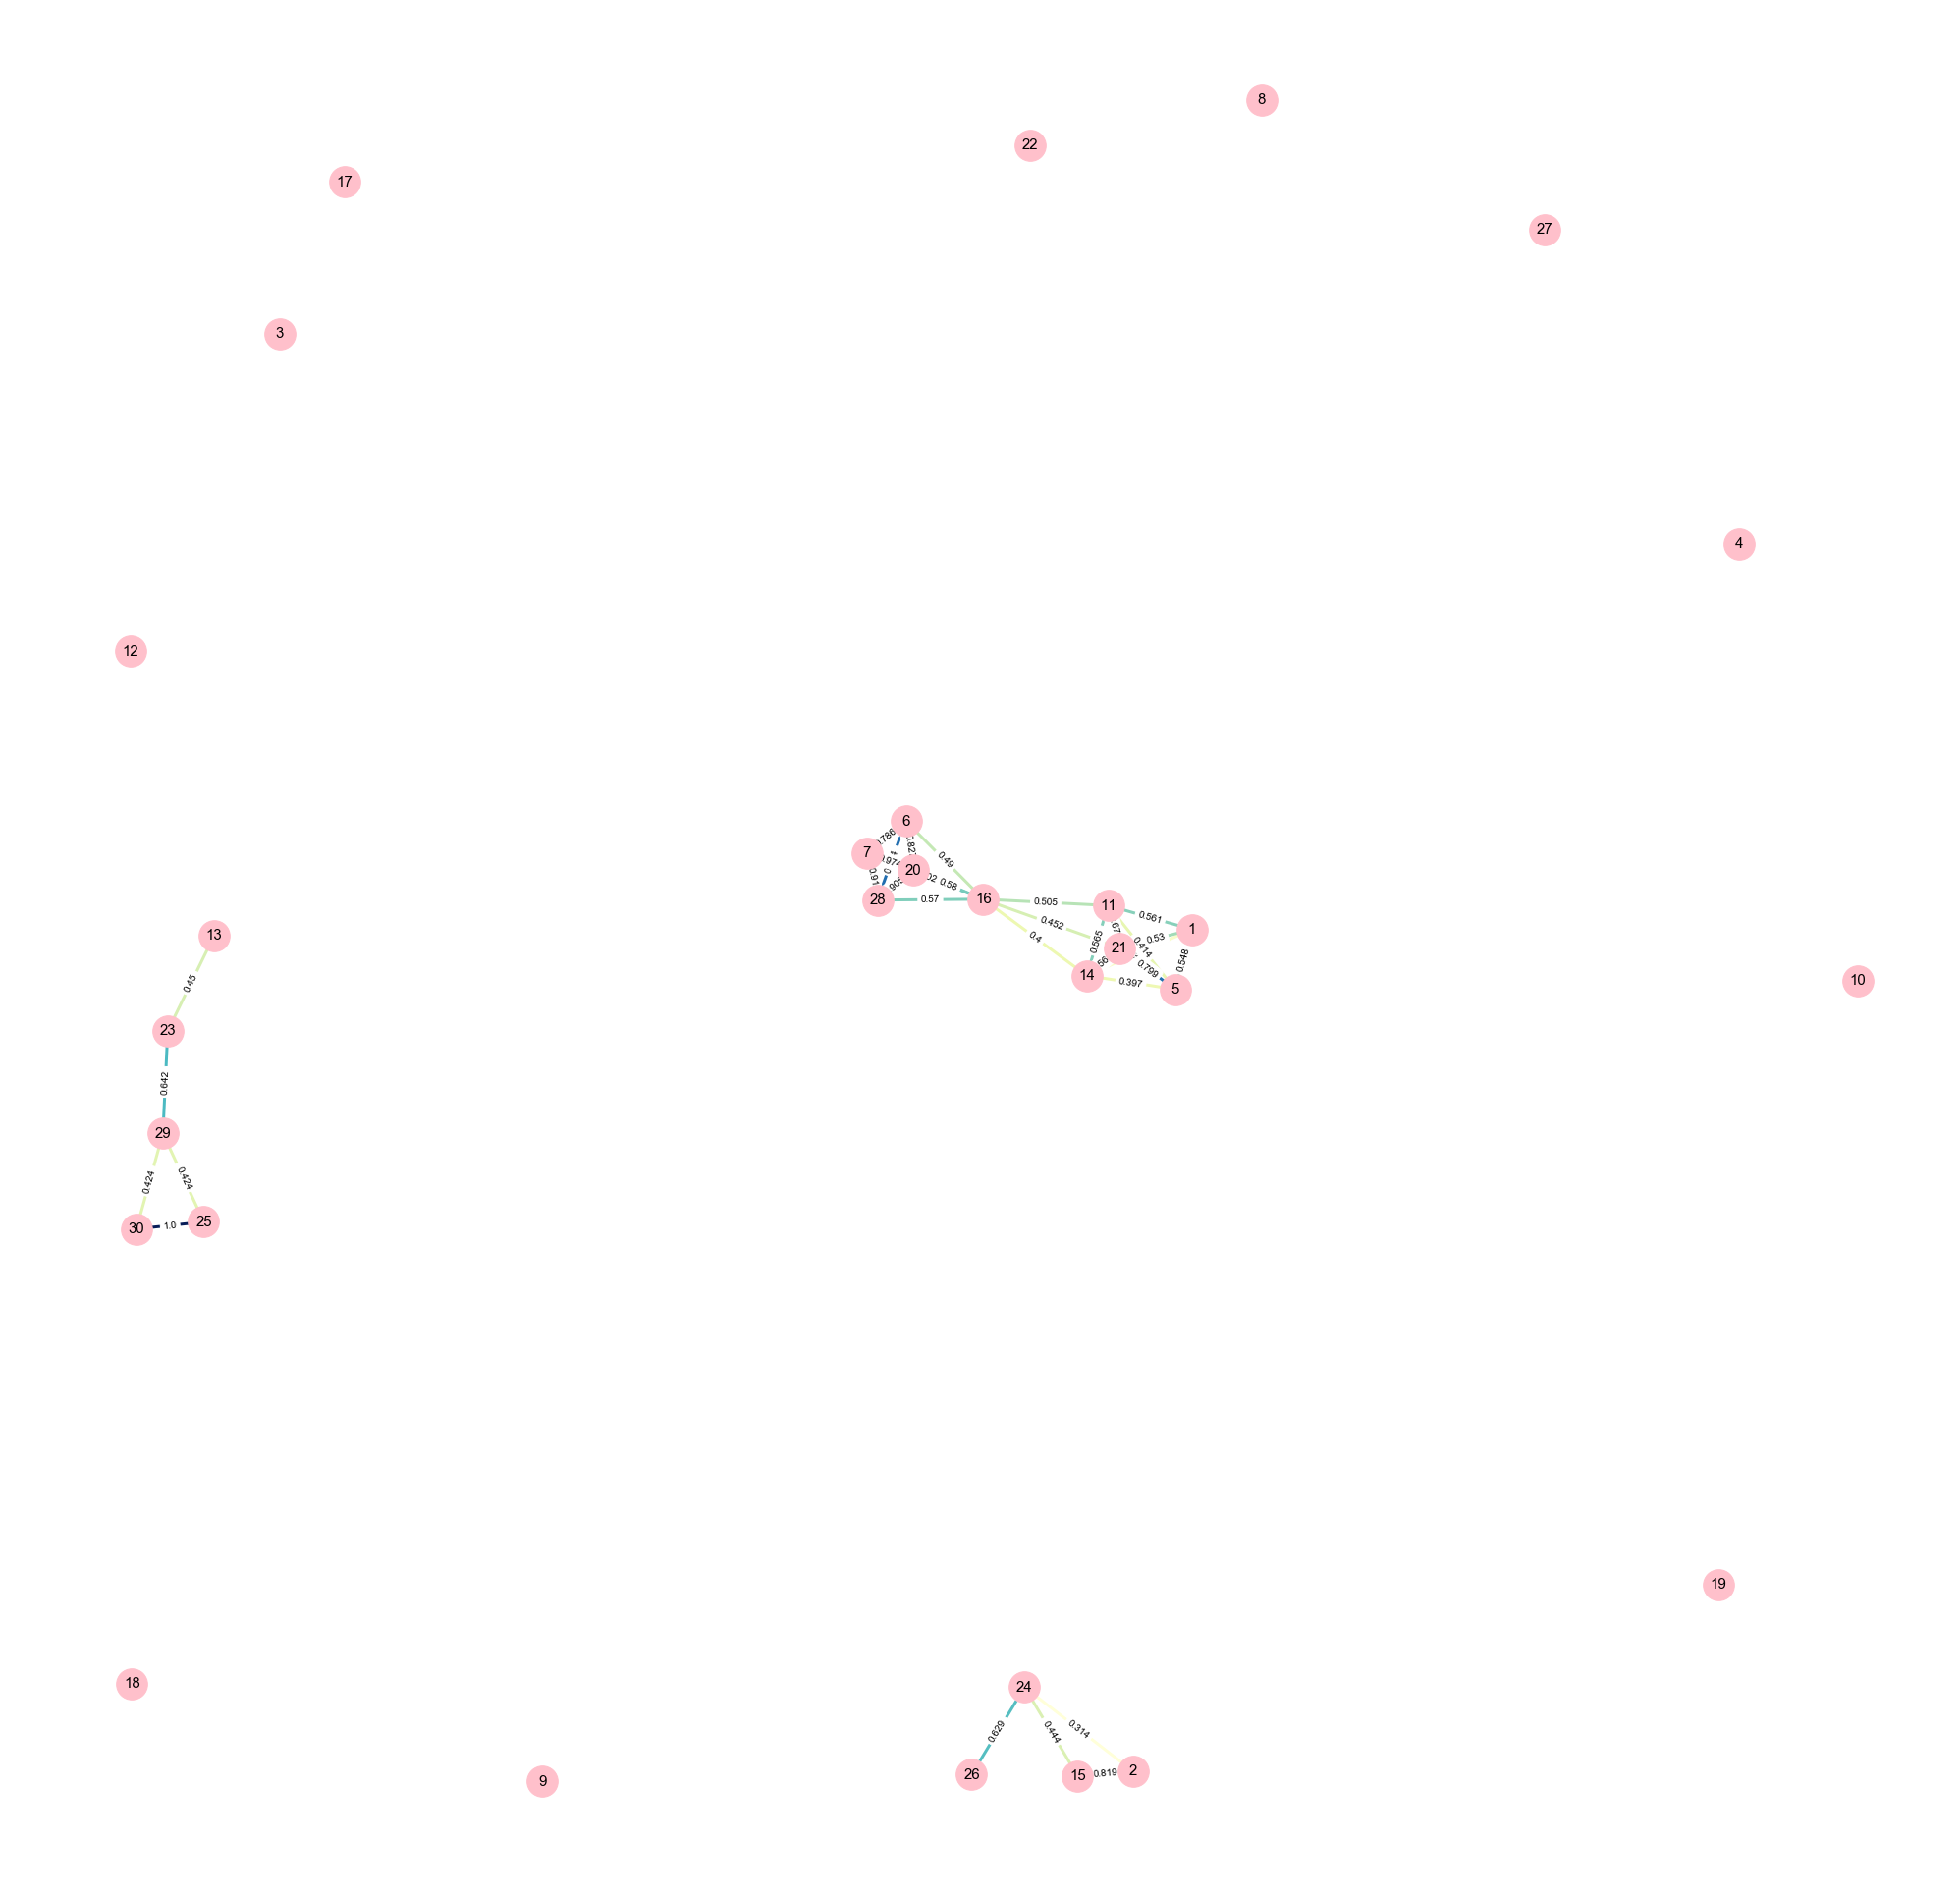

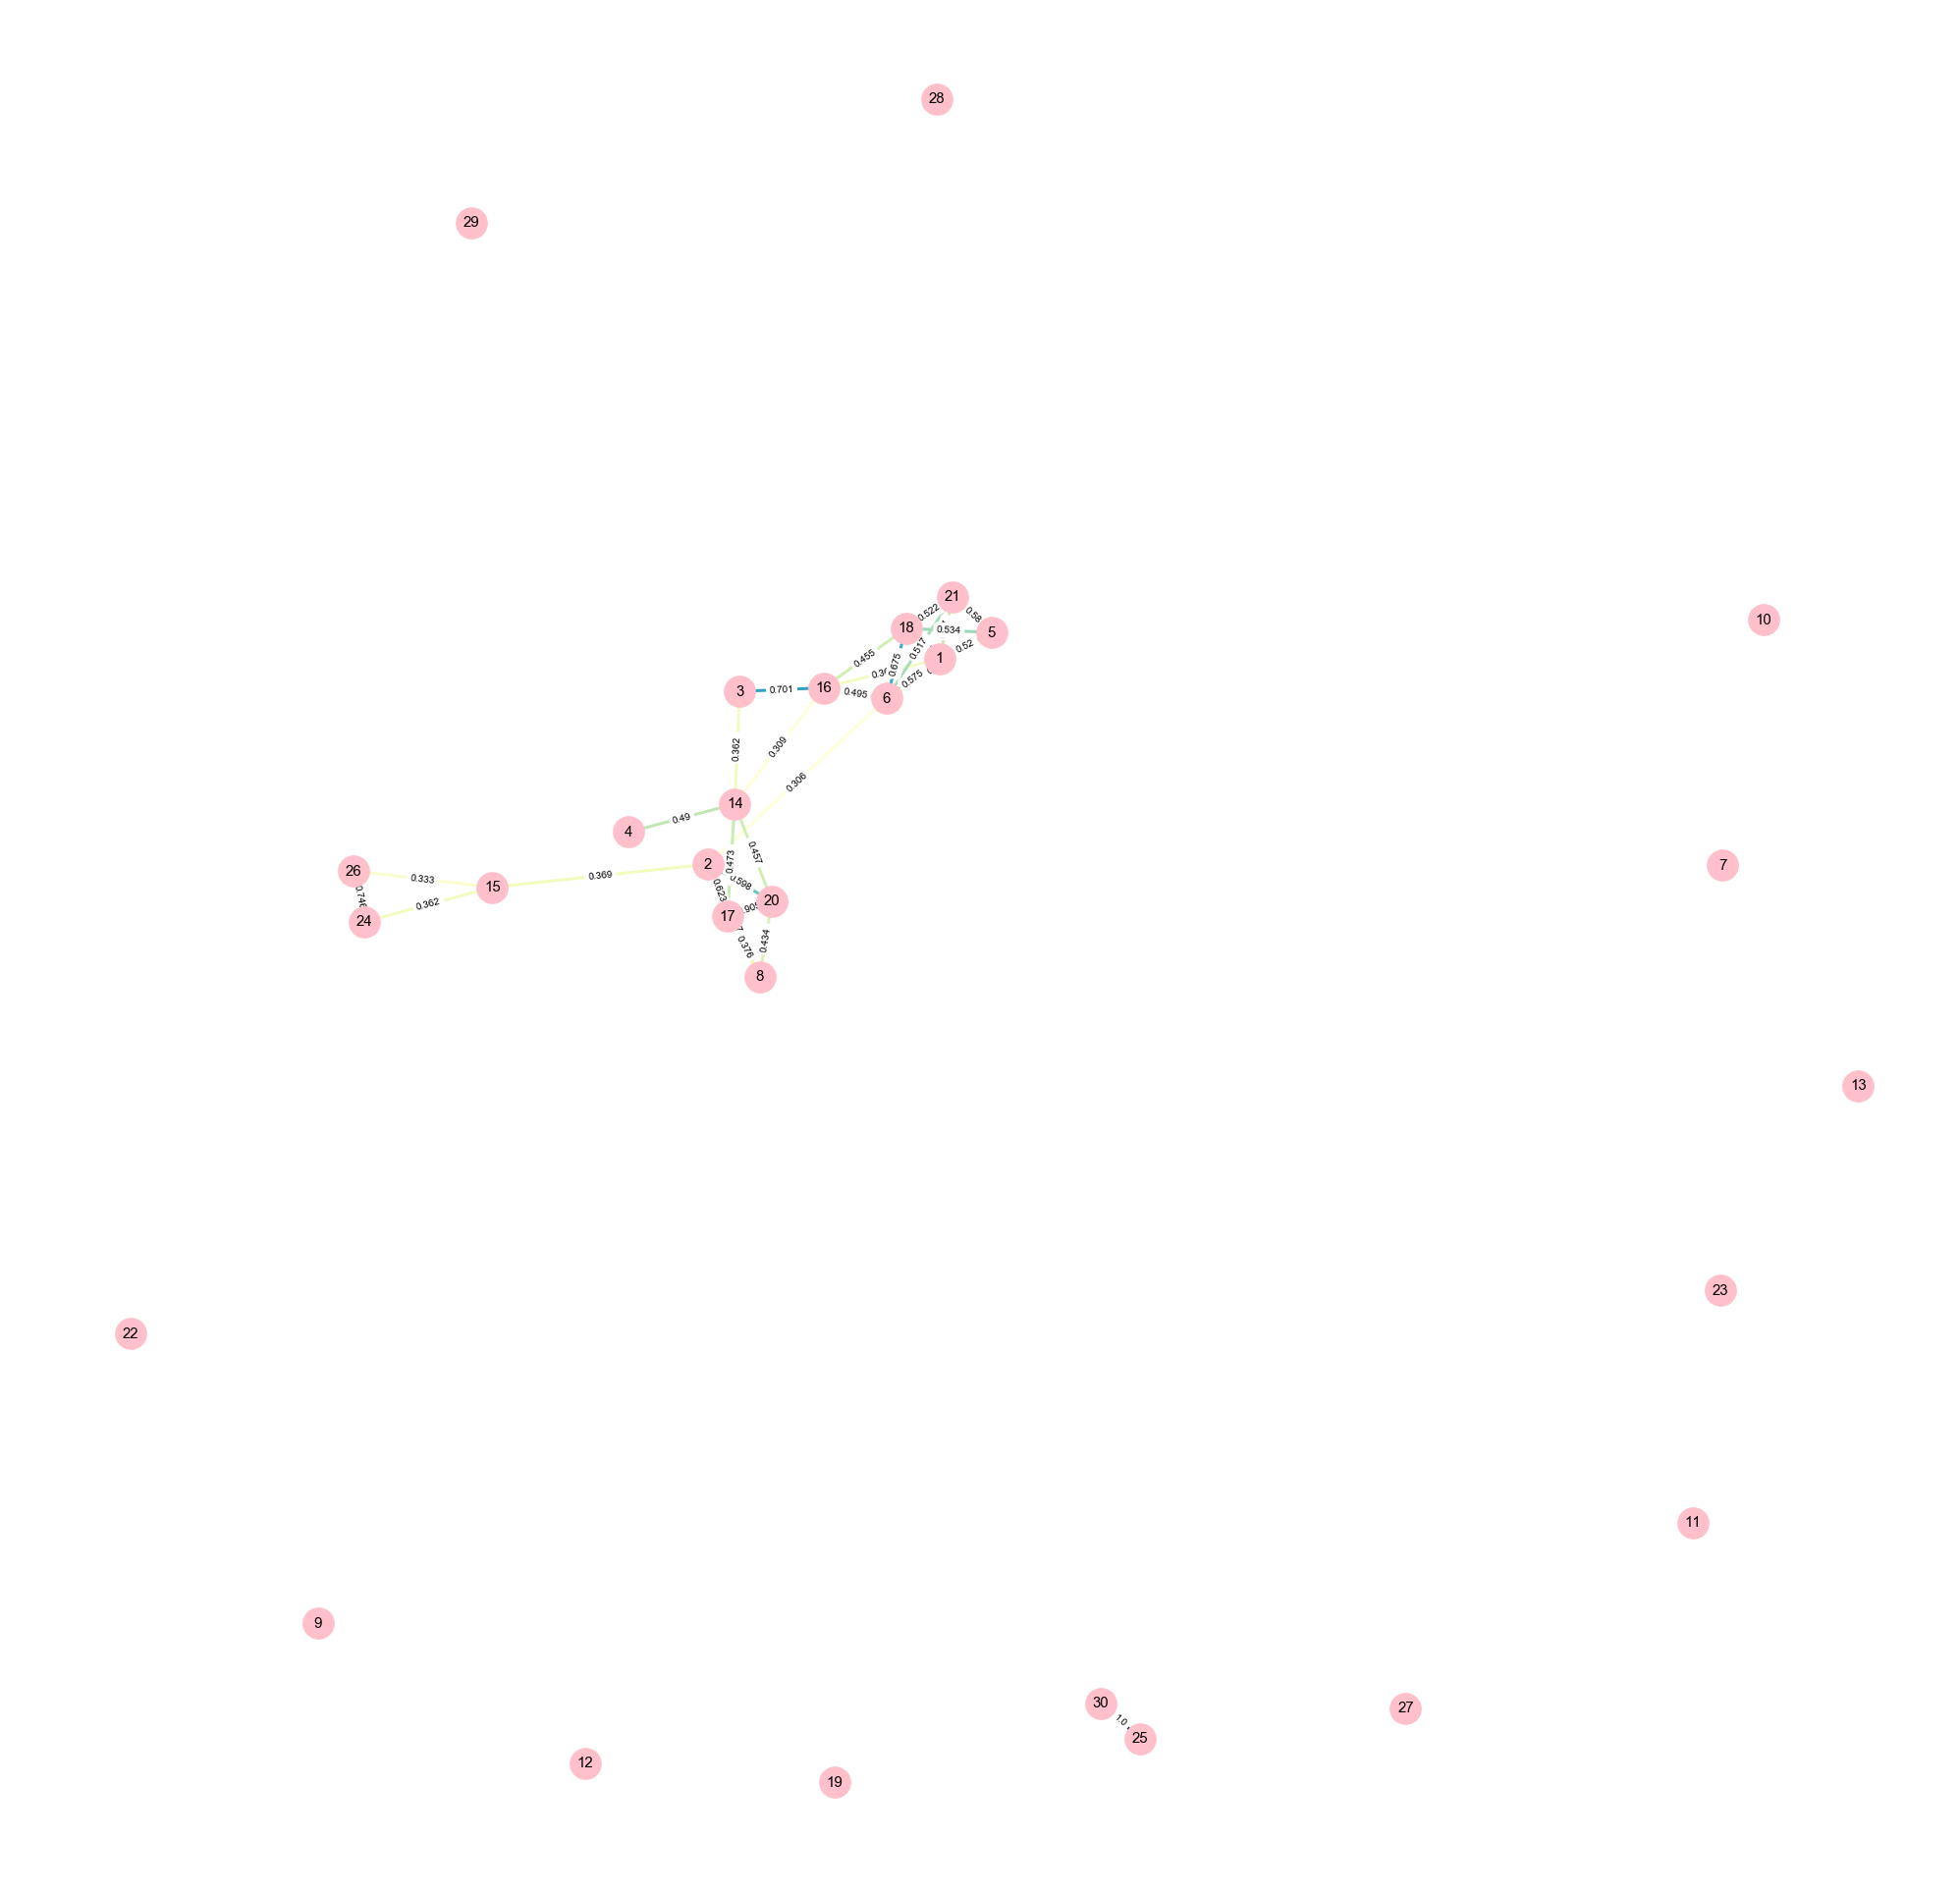

In [8]:
time_binned_dfs = bin_by_time(drd77_fe.cell_transients_df, freq="1Min")

for i in range(len(time_binned_dfs)):
    open_graph = NeuronNetwork(time_binned_dfs[i].reset_index(drop=True))
    open_graph.plot_with_spring_layout(figsize=(35,35), node_color="pink", node_size=1000)

## We get all of the indices in which DRD87 was marked as in the **OpenArms**, and we establish all the 1 minute intervals of that behavior. Namely, we create a separate dataframe for each minute of activity in the **OpenArms**.

## Then, we loop through all of the dataframes we created, and we plot their representations as graphs. Note: we reset (and drop the old) index.

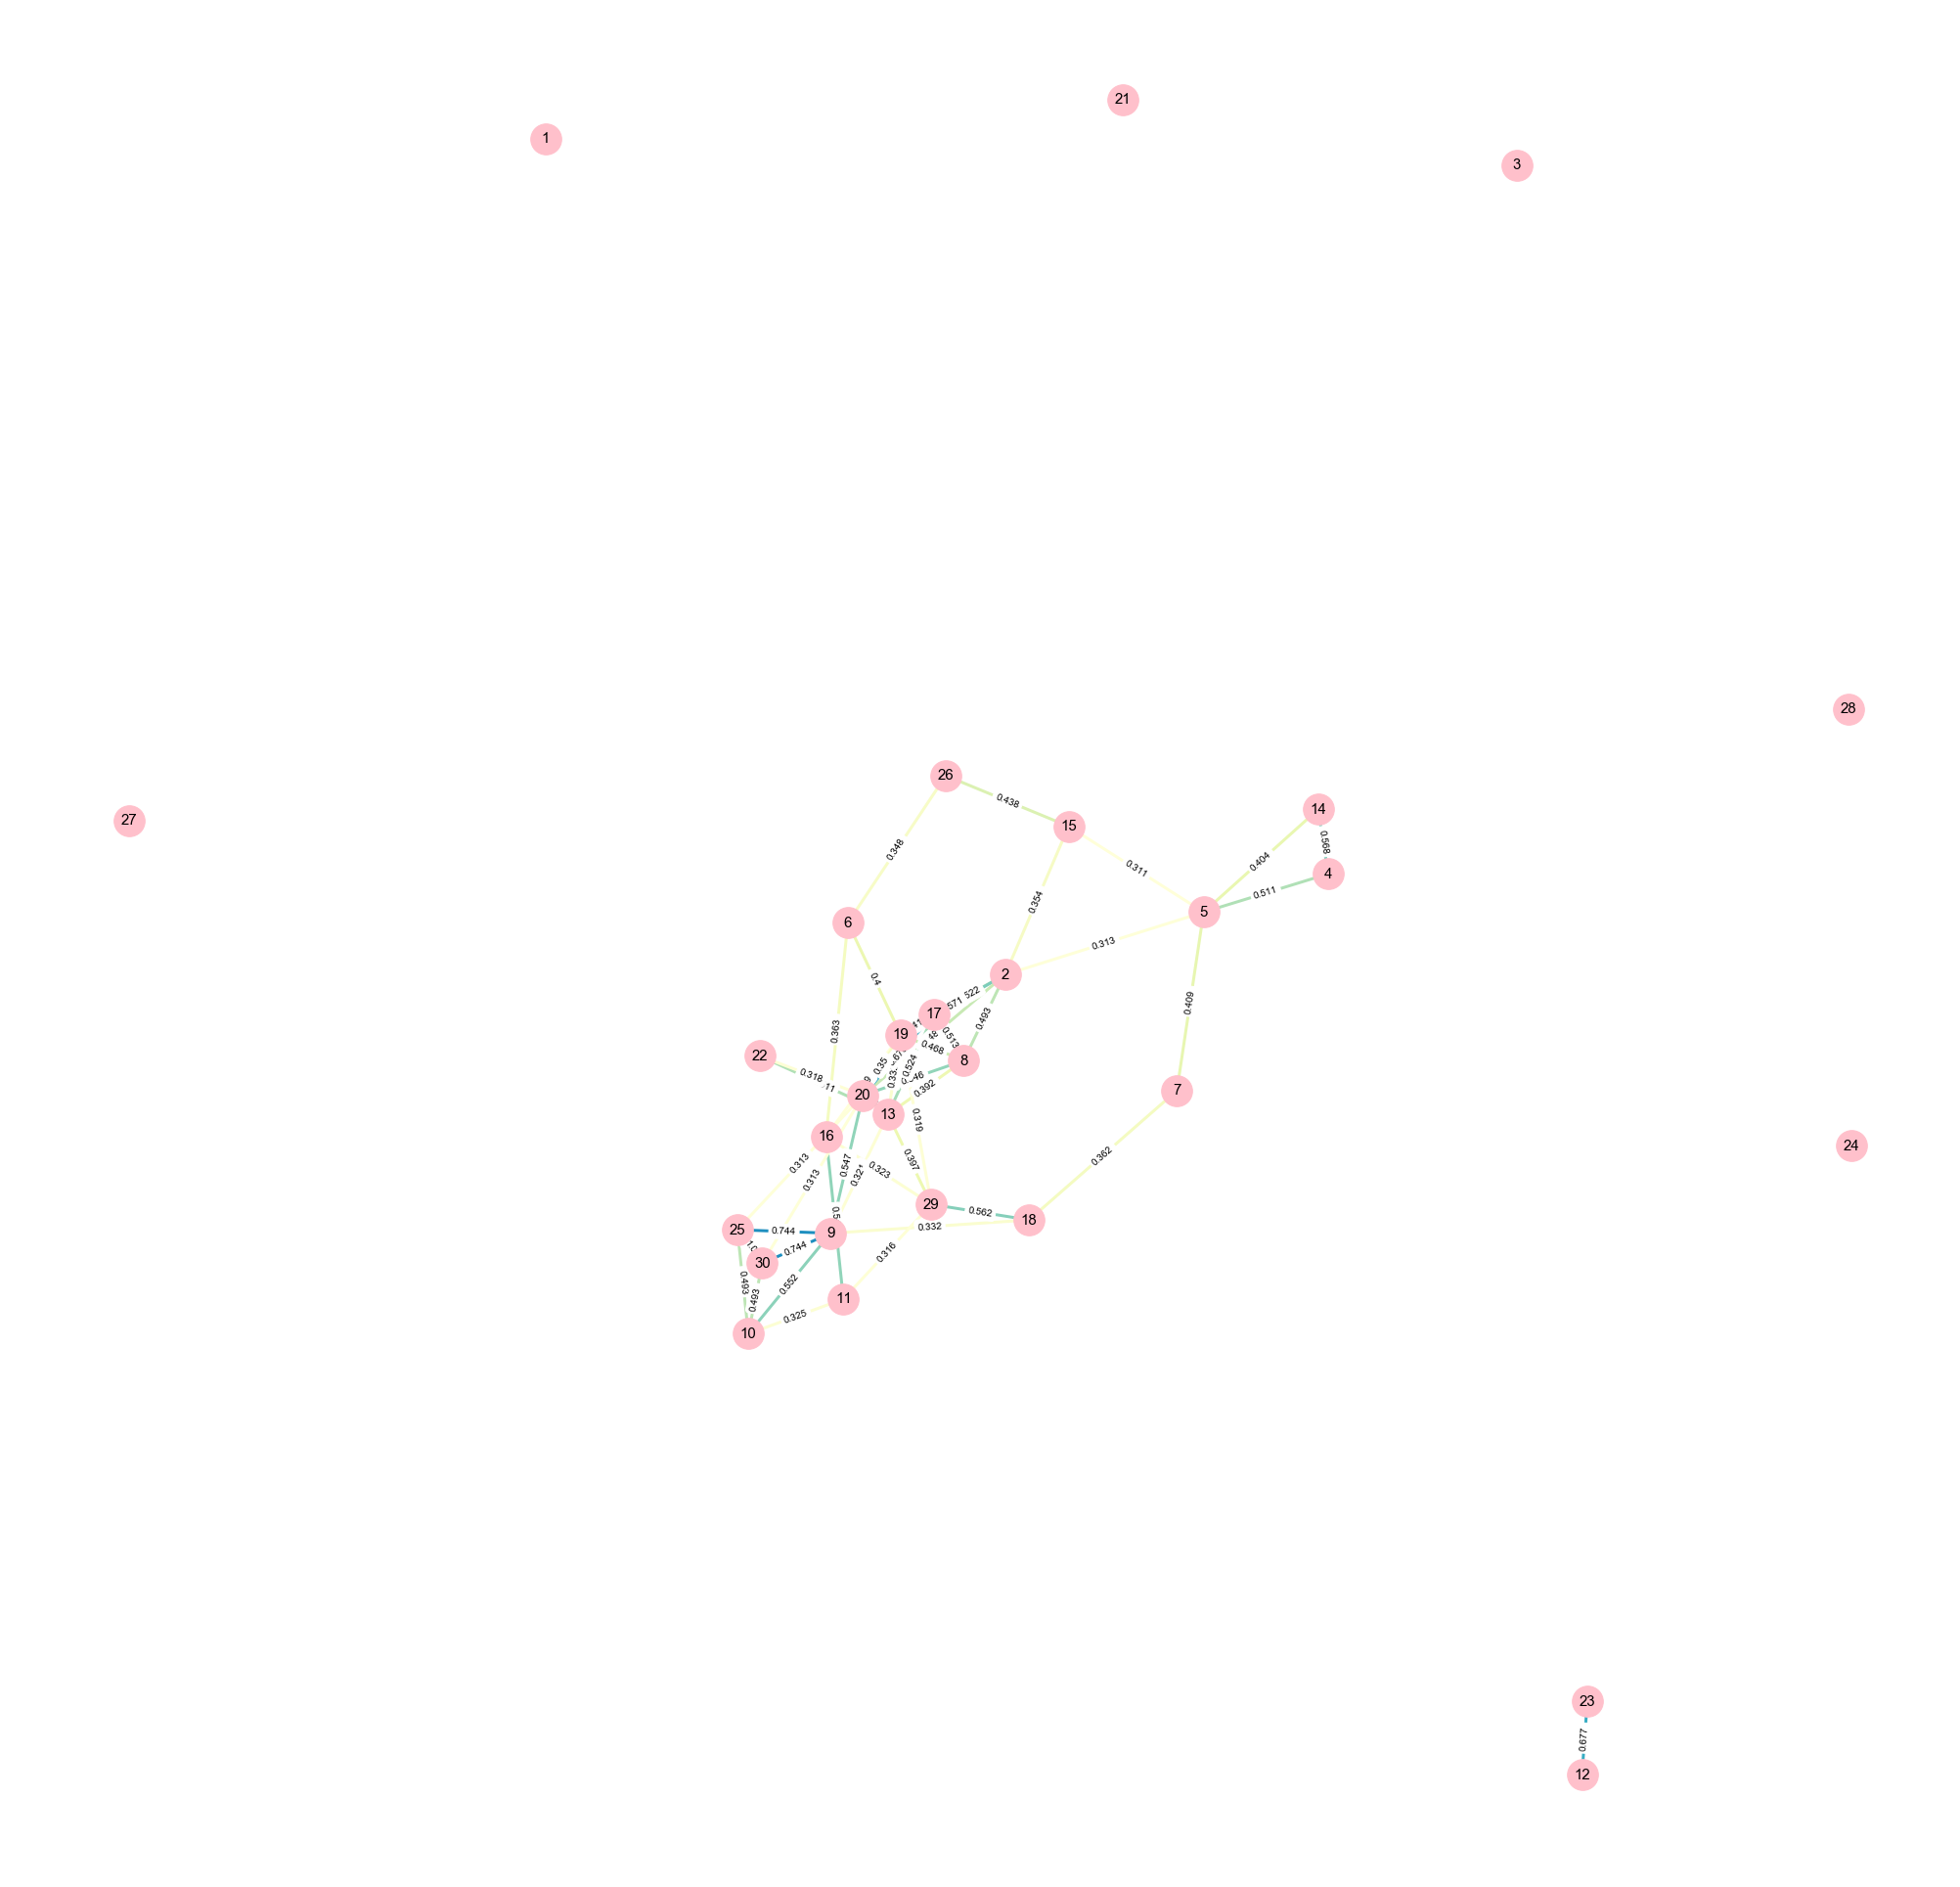

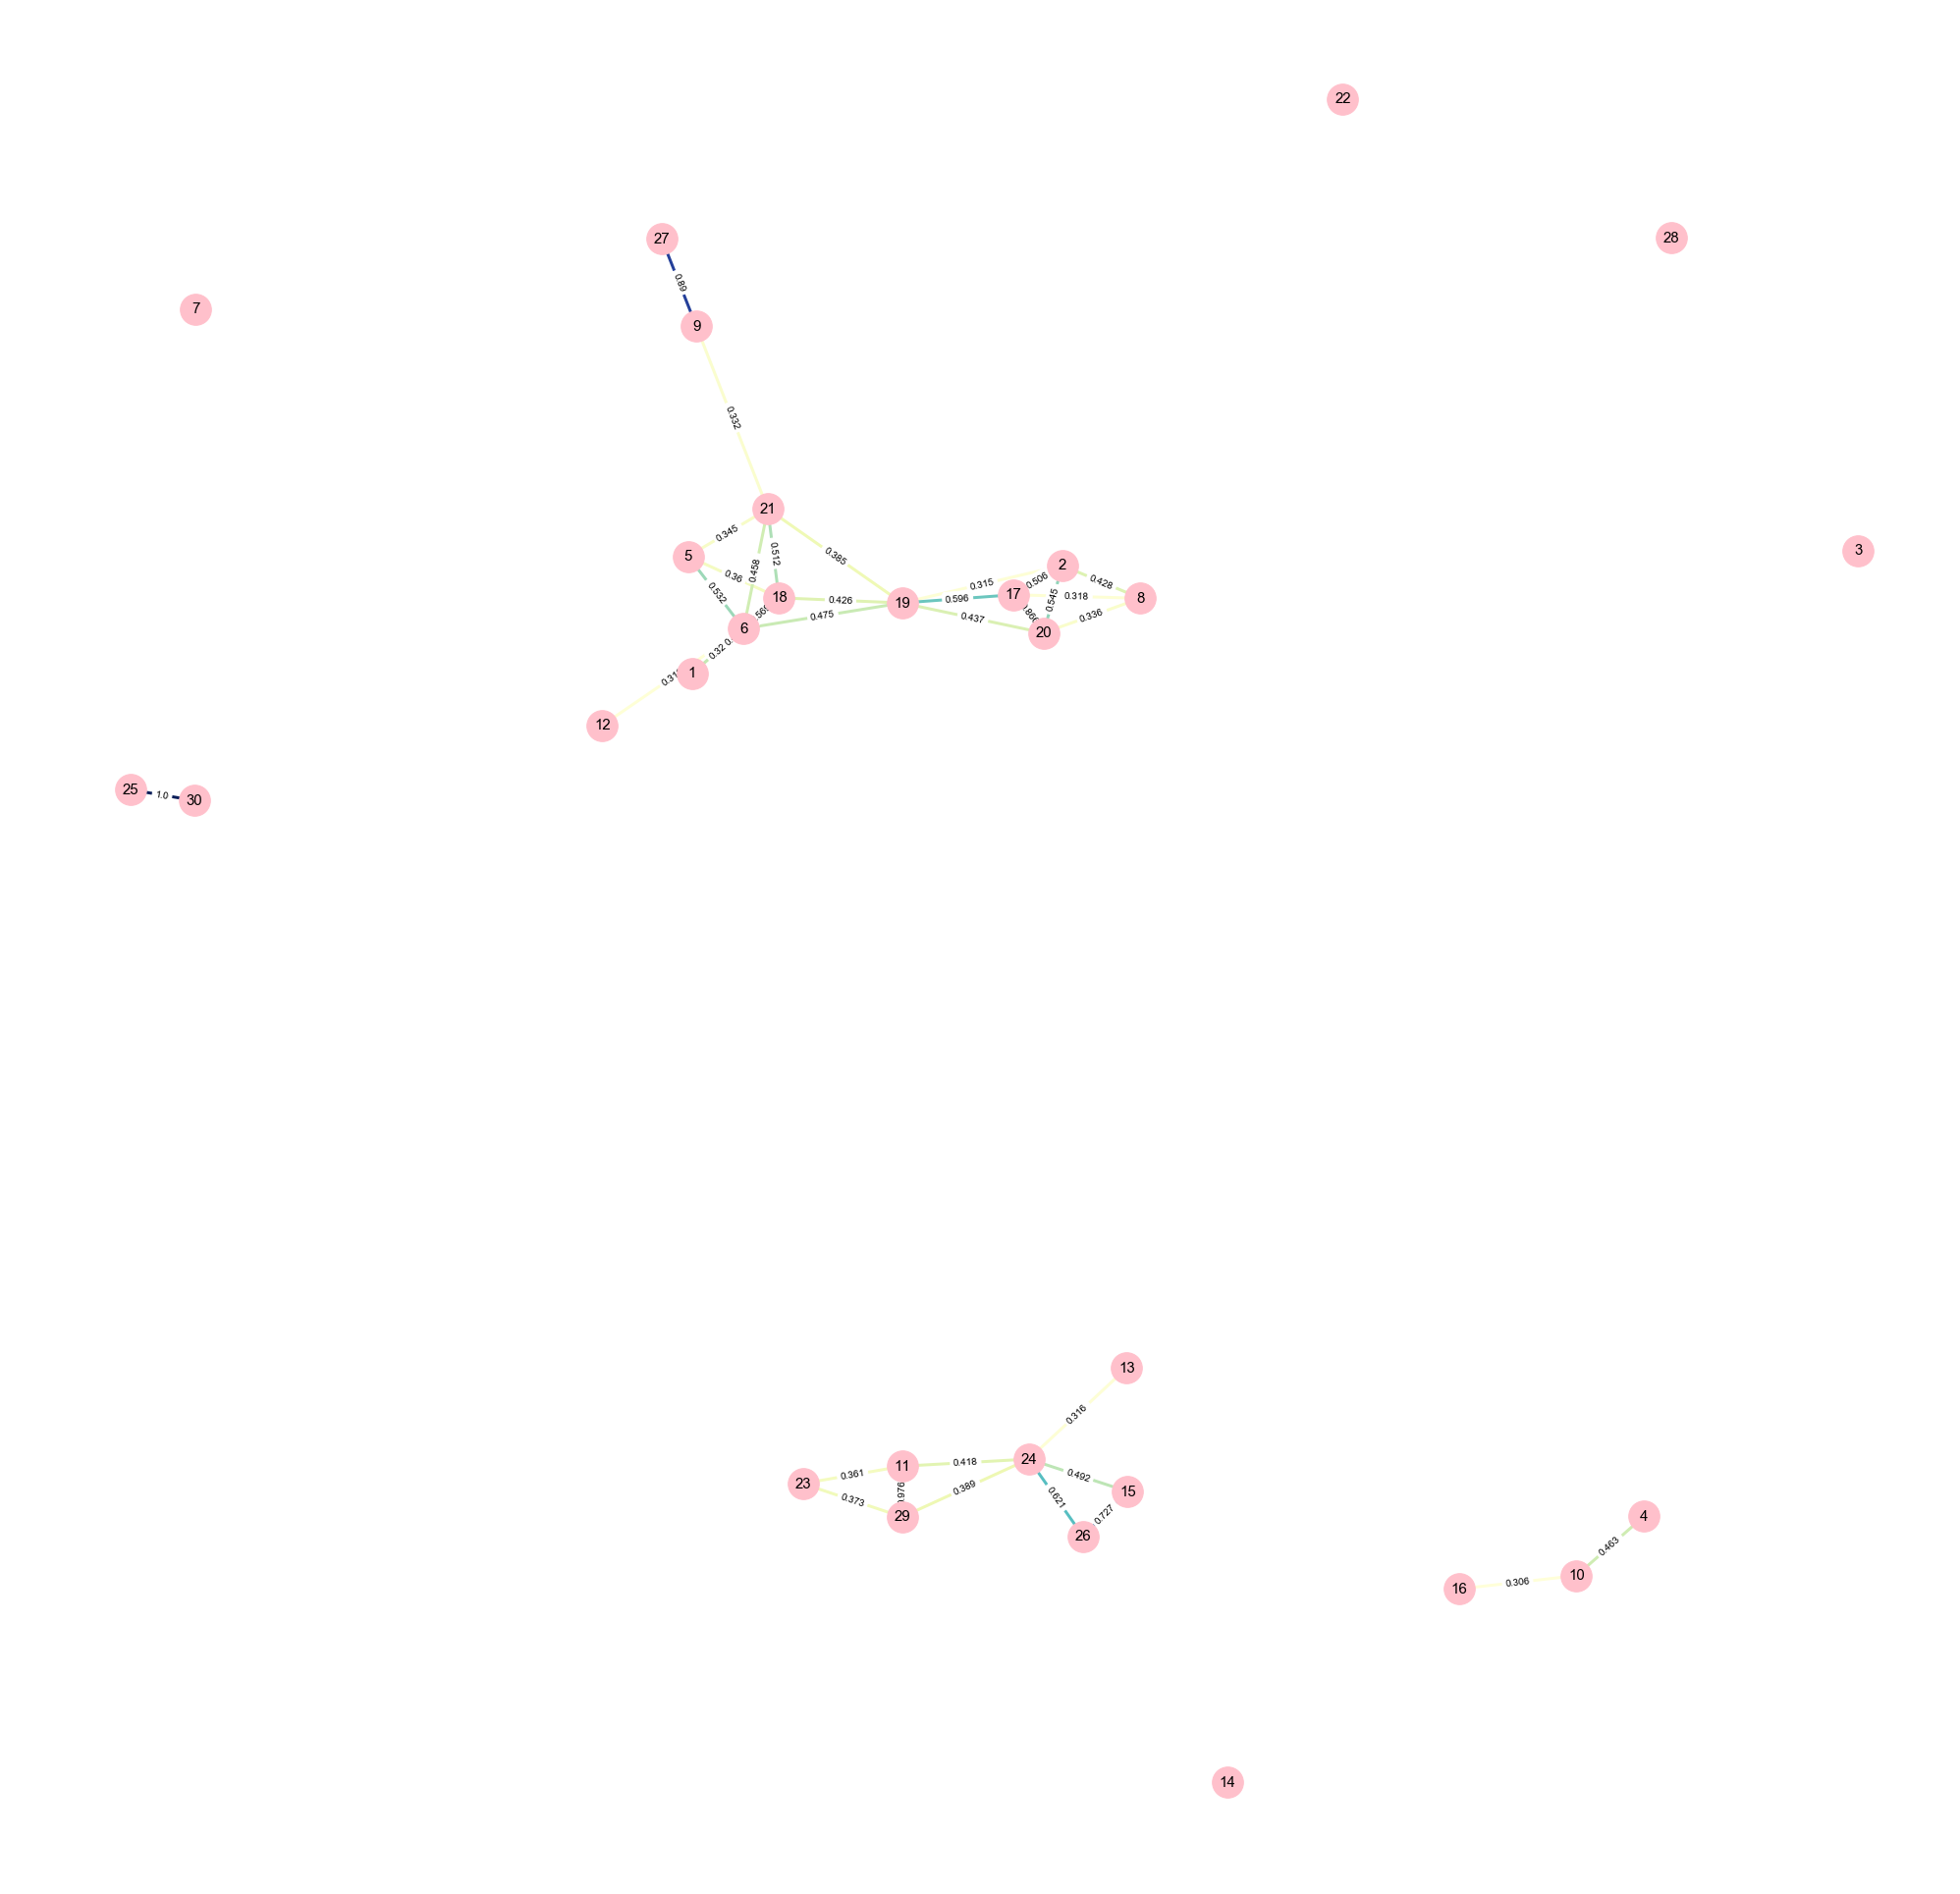

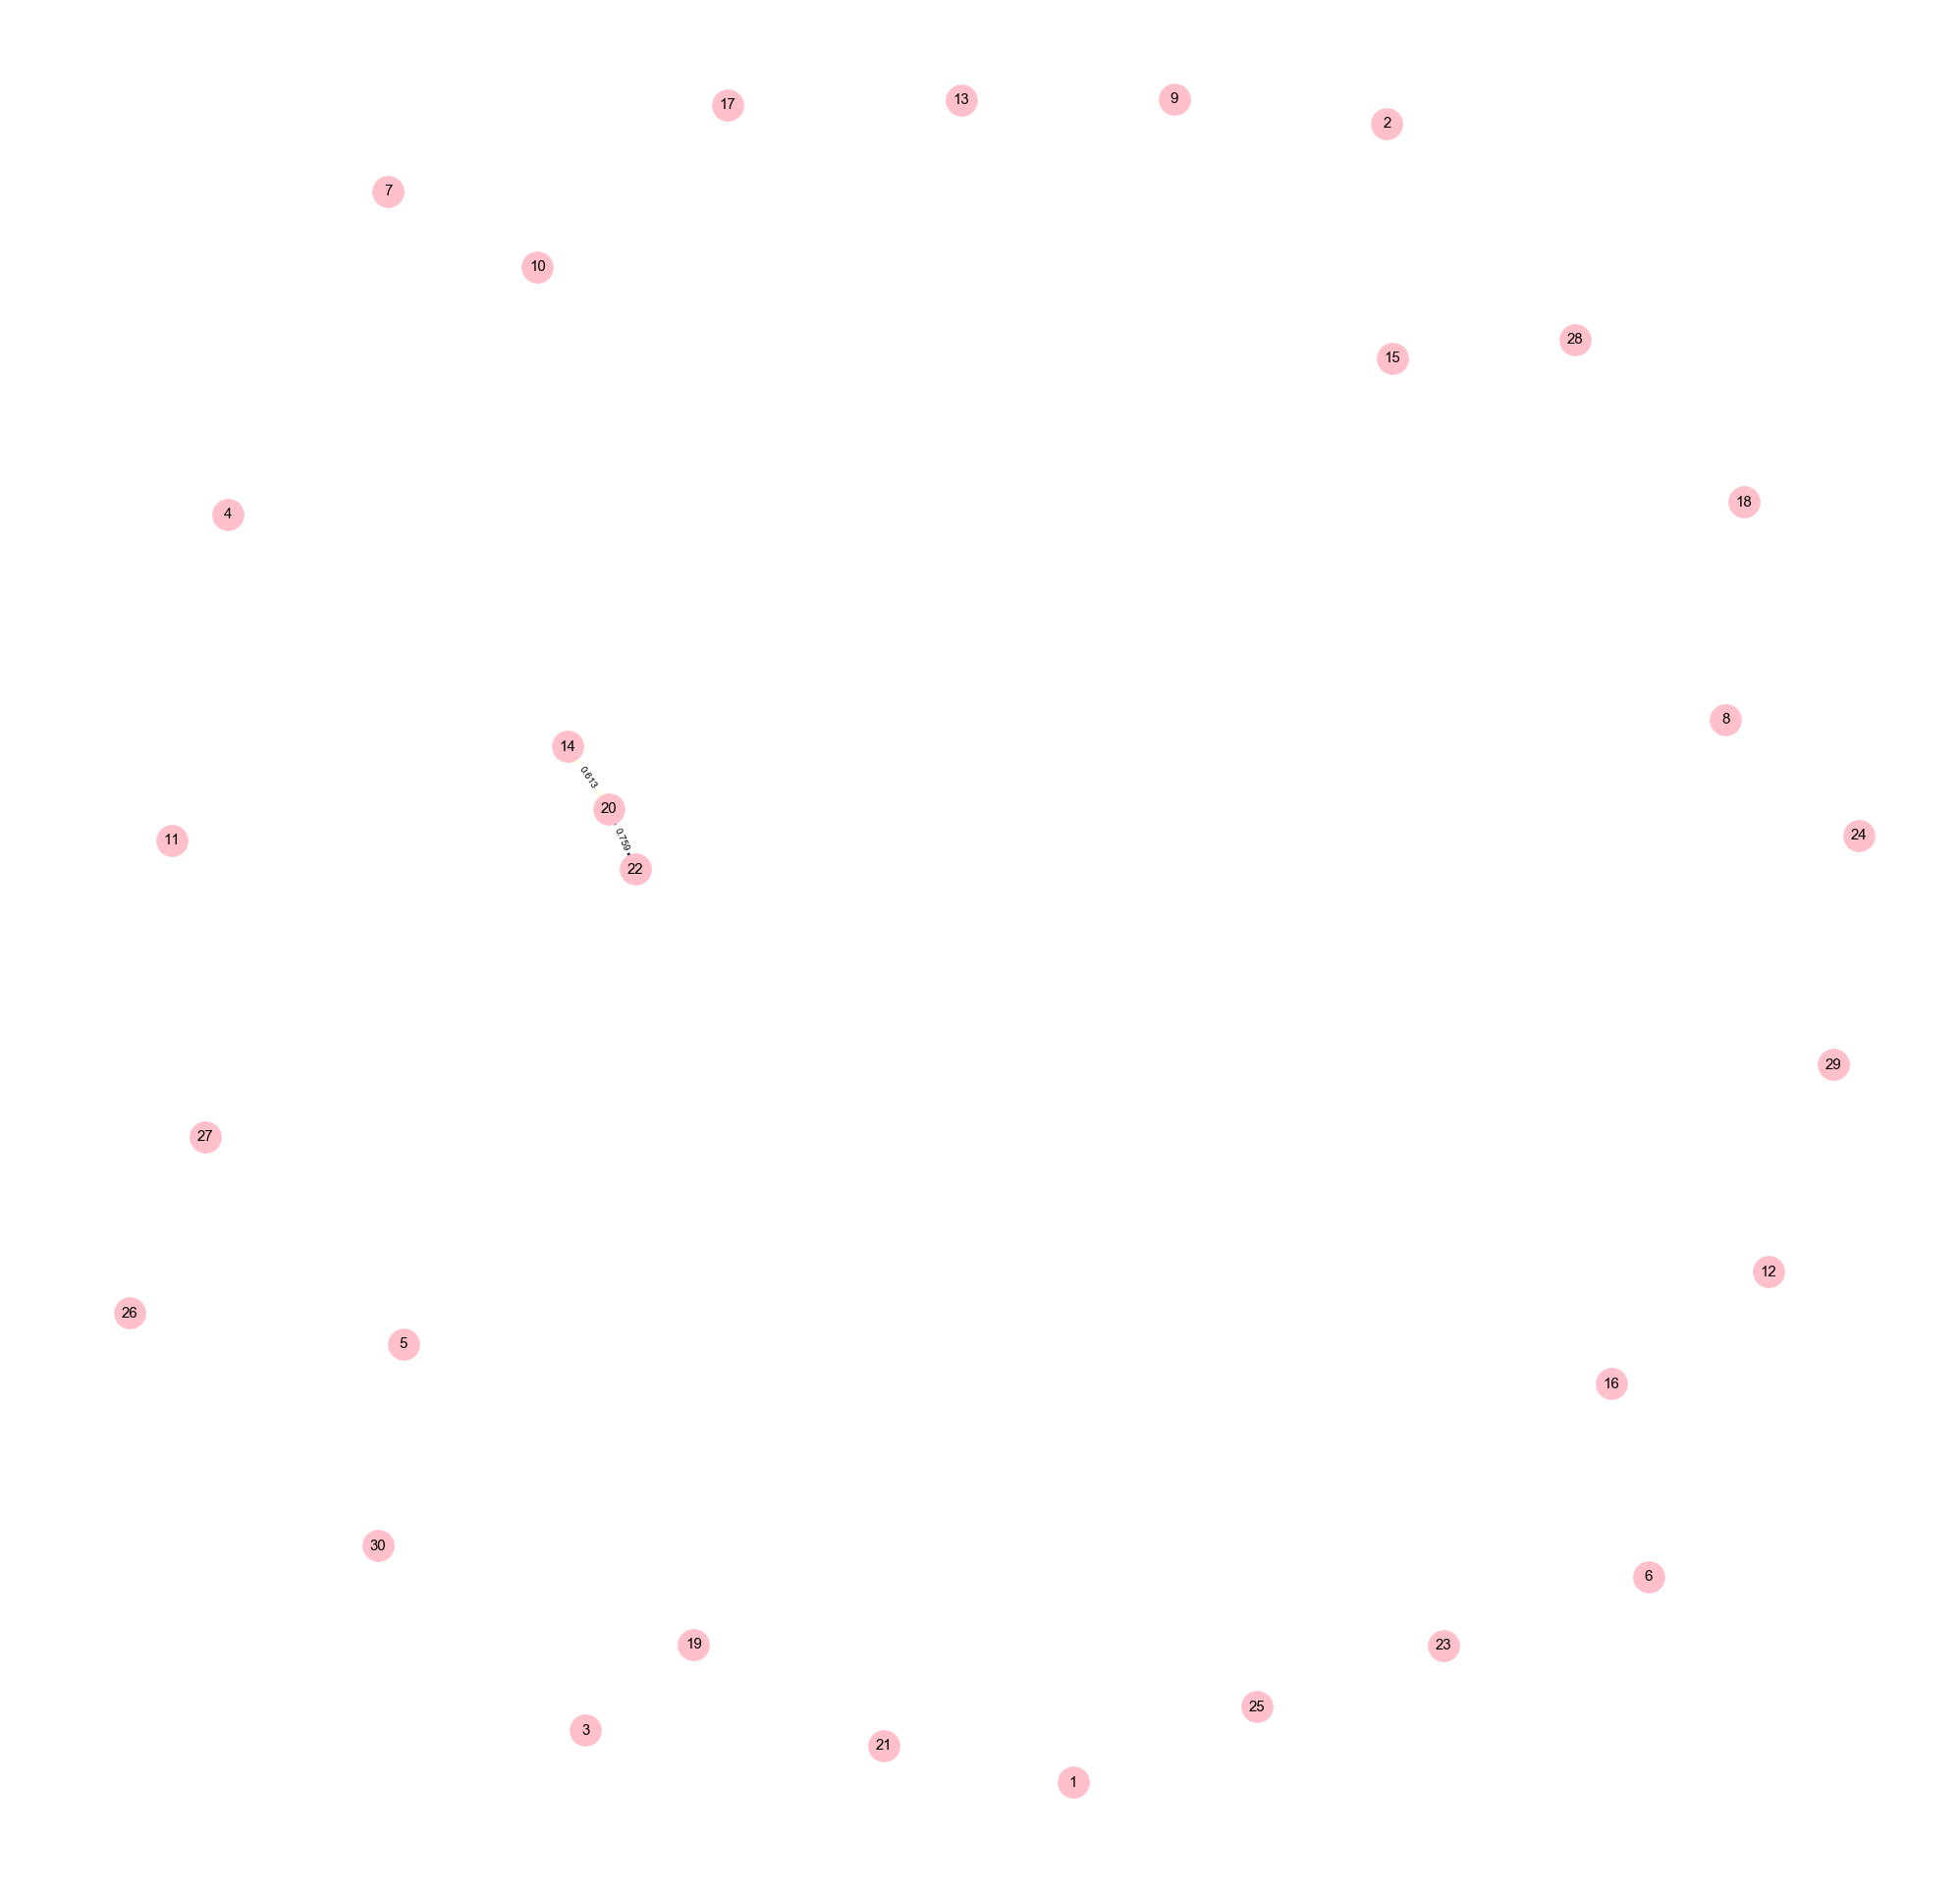

In [9]:
indices = drd77_fe.neuron_concated_behavior.loc[drd77_fe.neuron_concated_behavior["OpenArms_centerpoint"] != 0].index
time_binned_dfs = bin_by_time(drd77_fe.cell_transients_df.iloc[indices], freq="1Min")

for i in range(len(time_binned_dfs)):
    open_graph = NeuronNetwork(time_binned_dfs[i].reset_index(drop=True))
    open_graph.plot_with_spring_layout(figsize=(35, 35), node_color="pink", node_size=1000)

## Now we repeat the same exact procedure, but for the **ClosedArms**

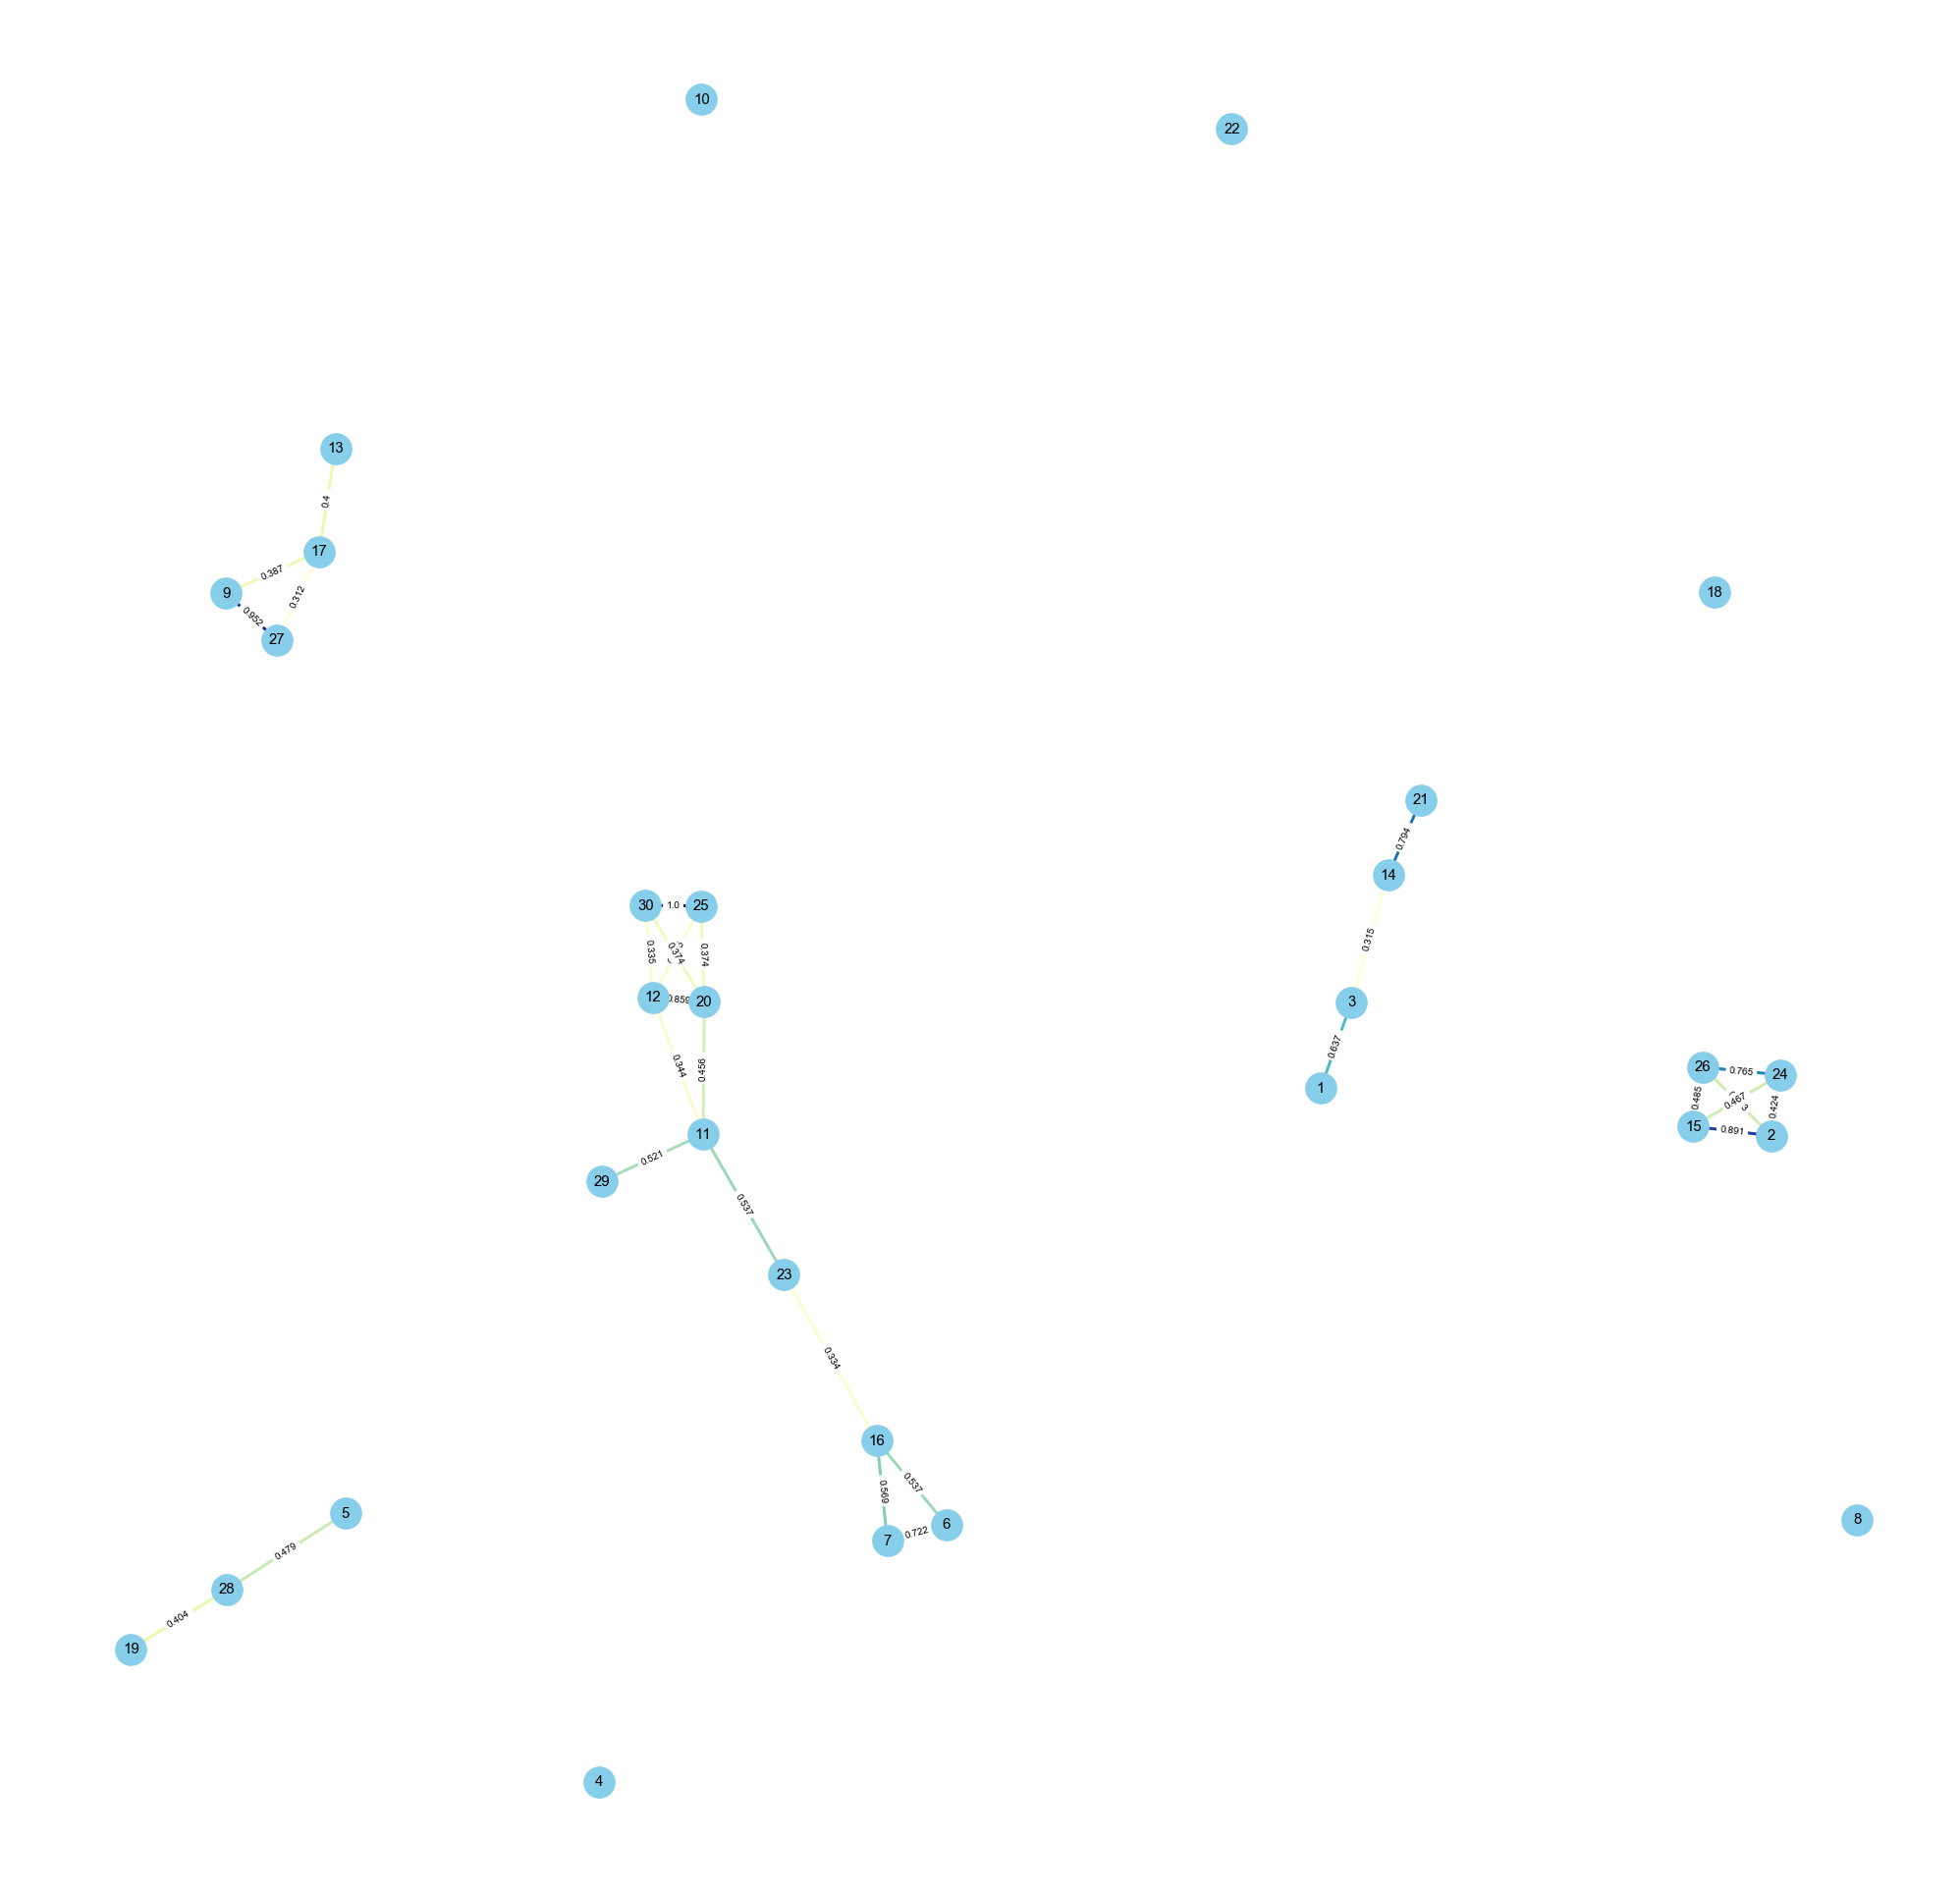

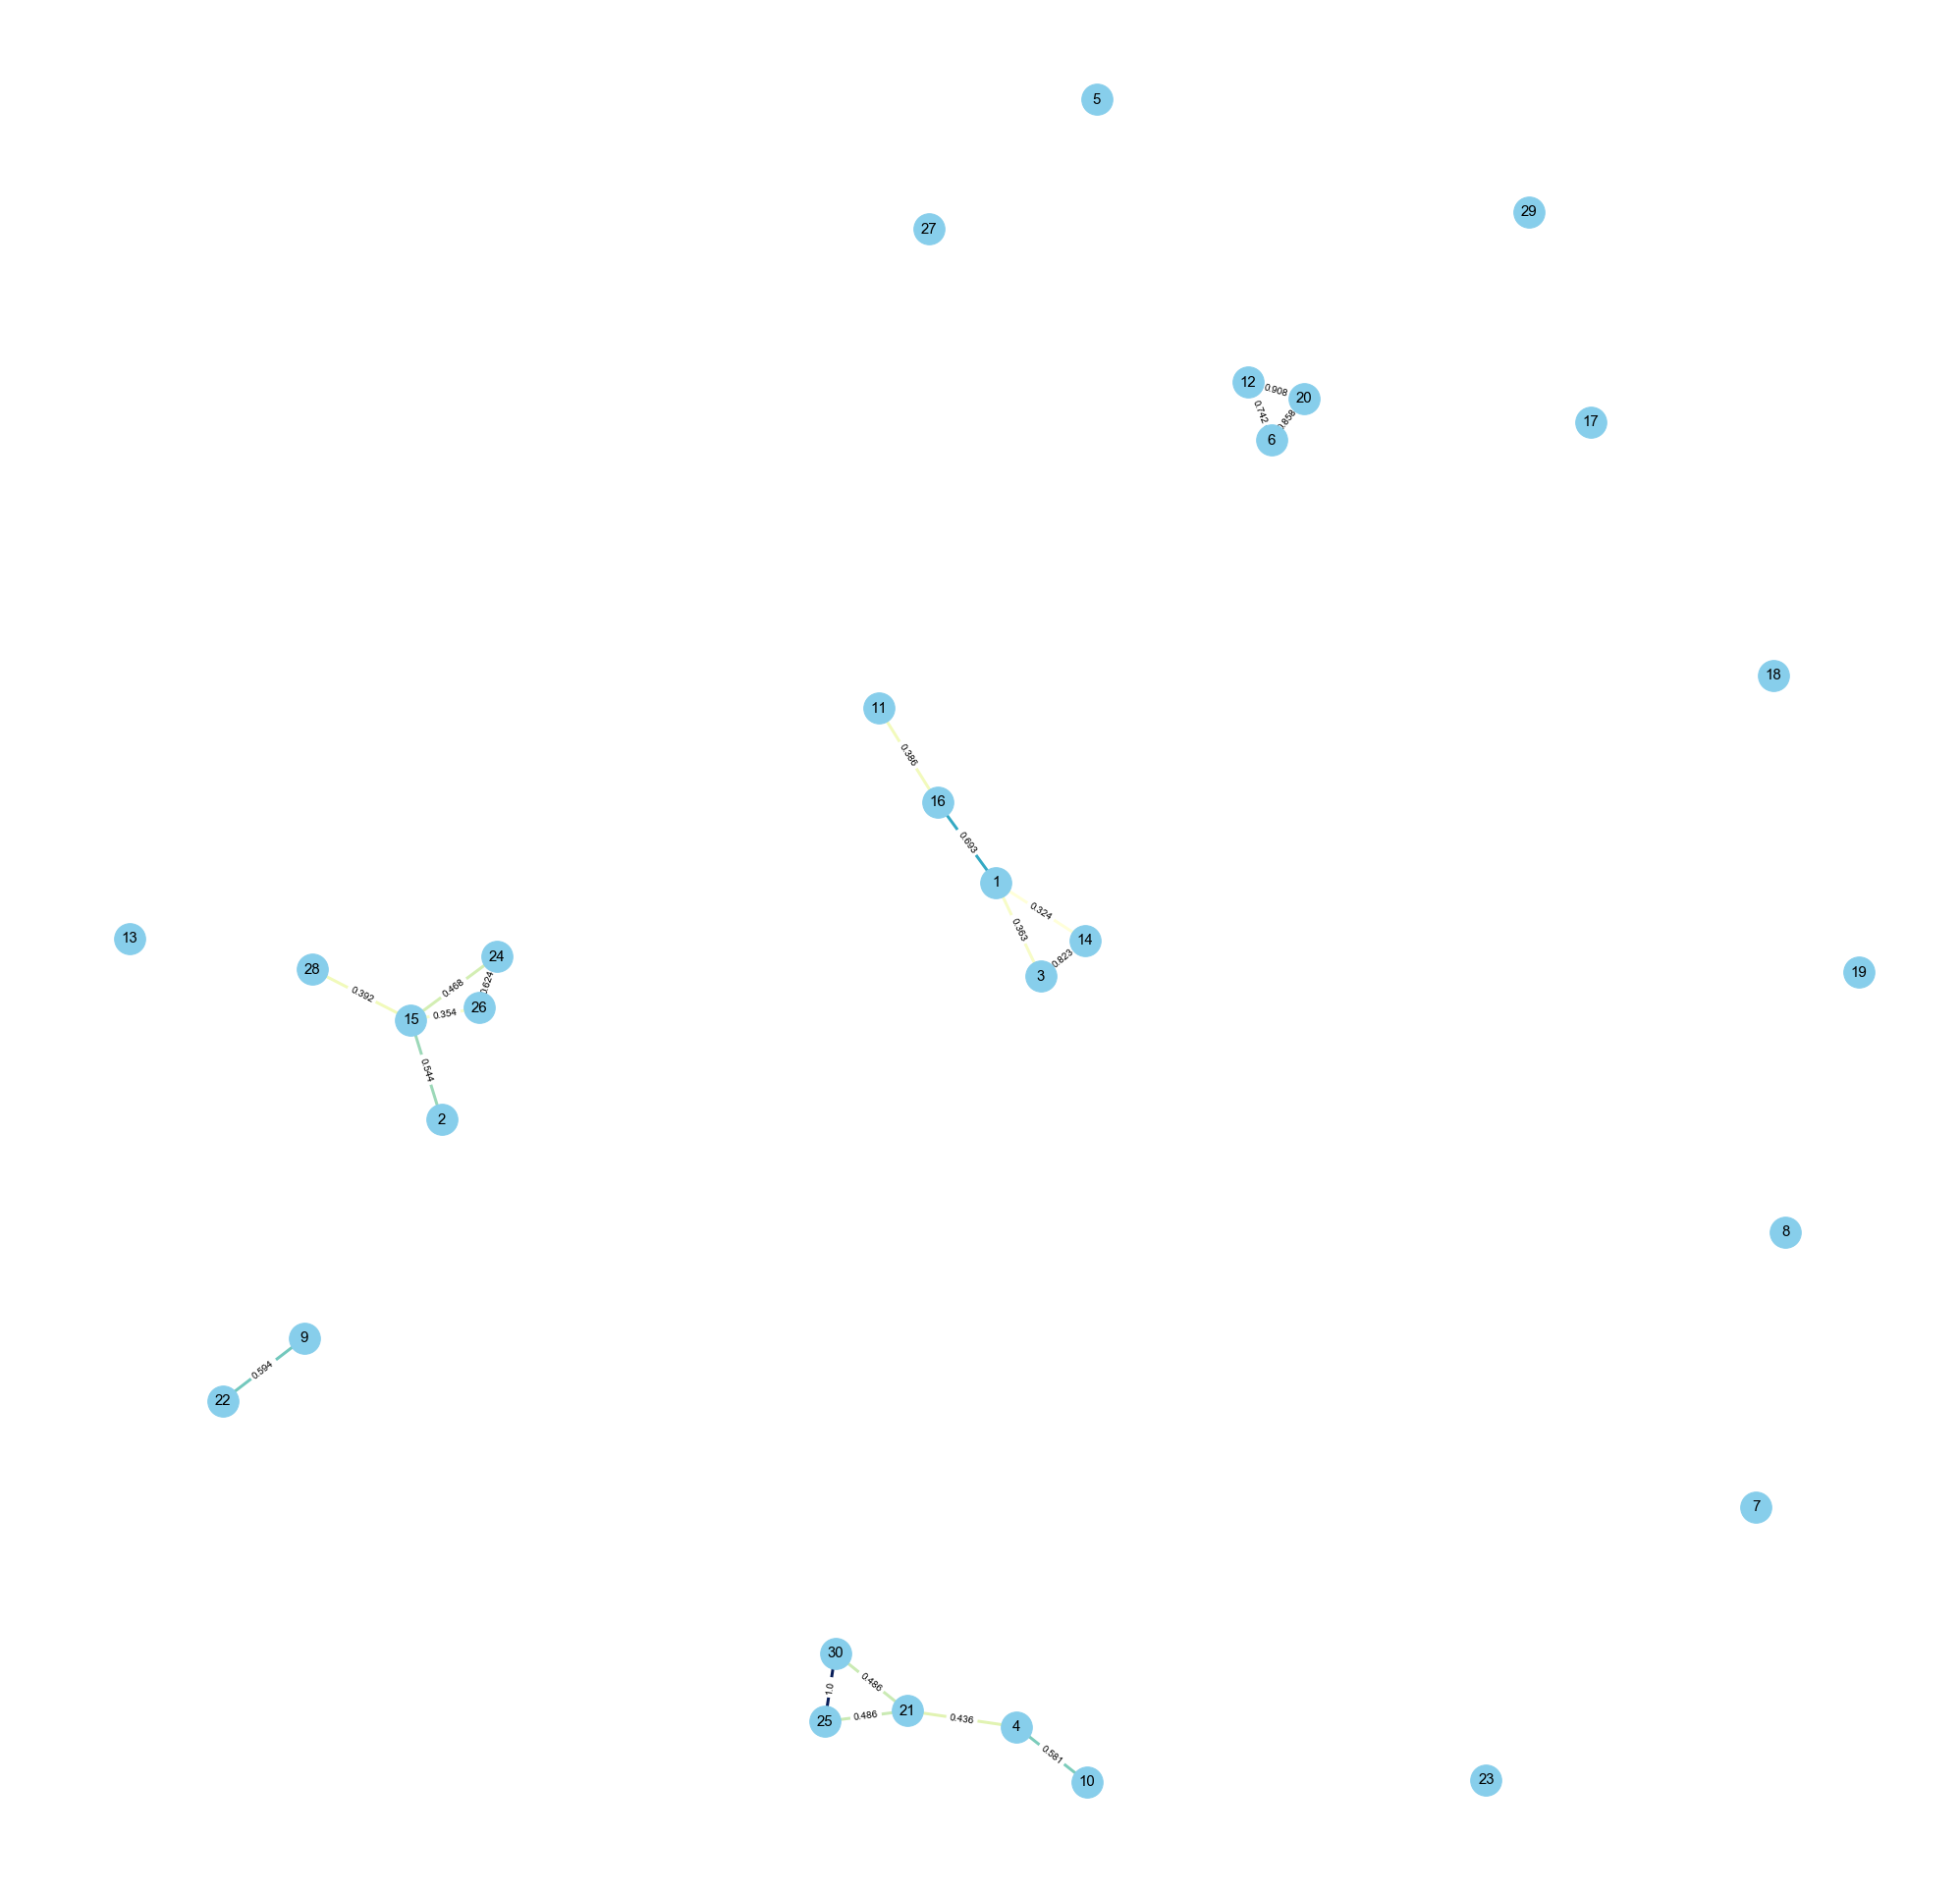

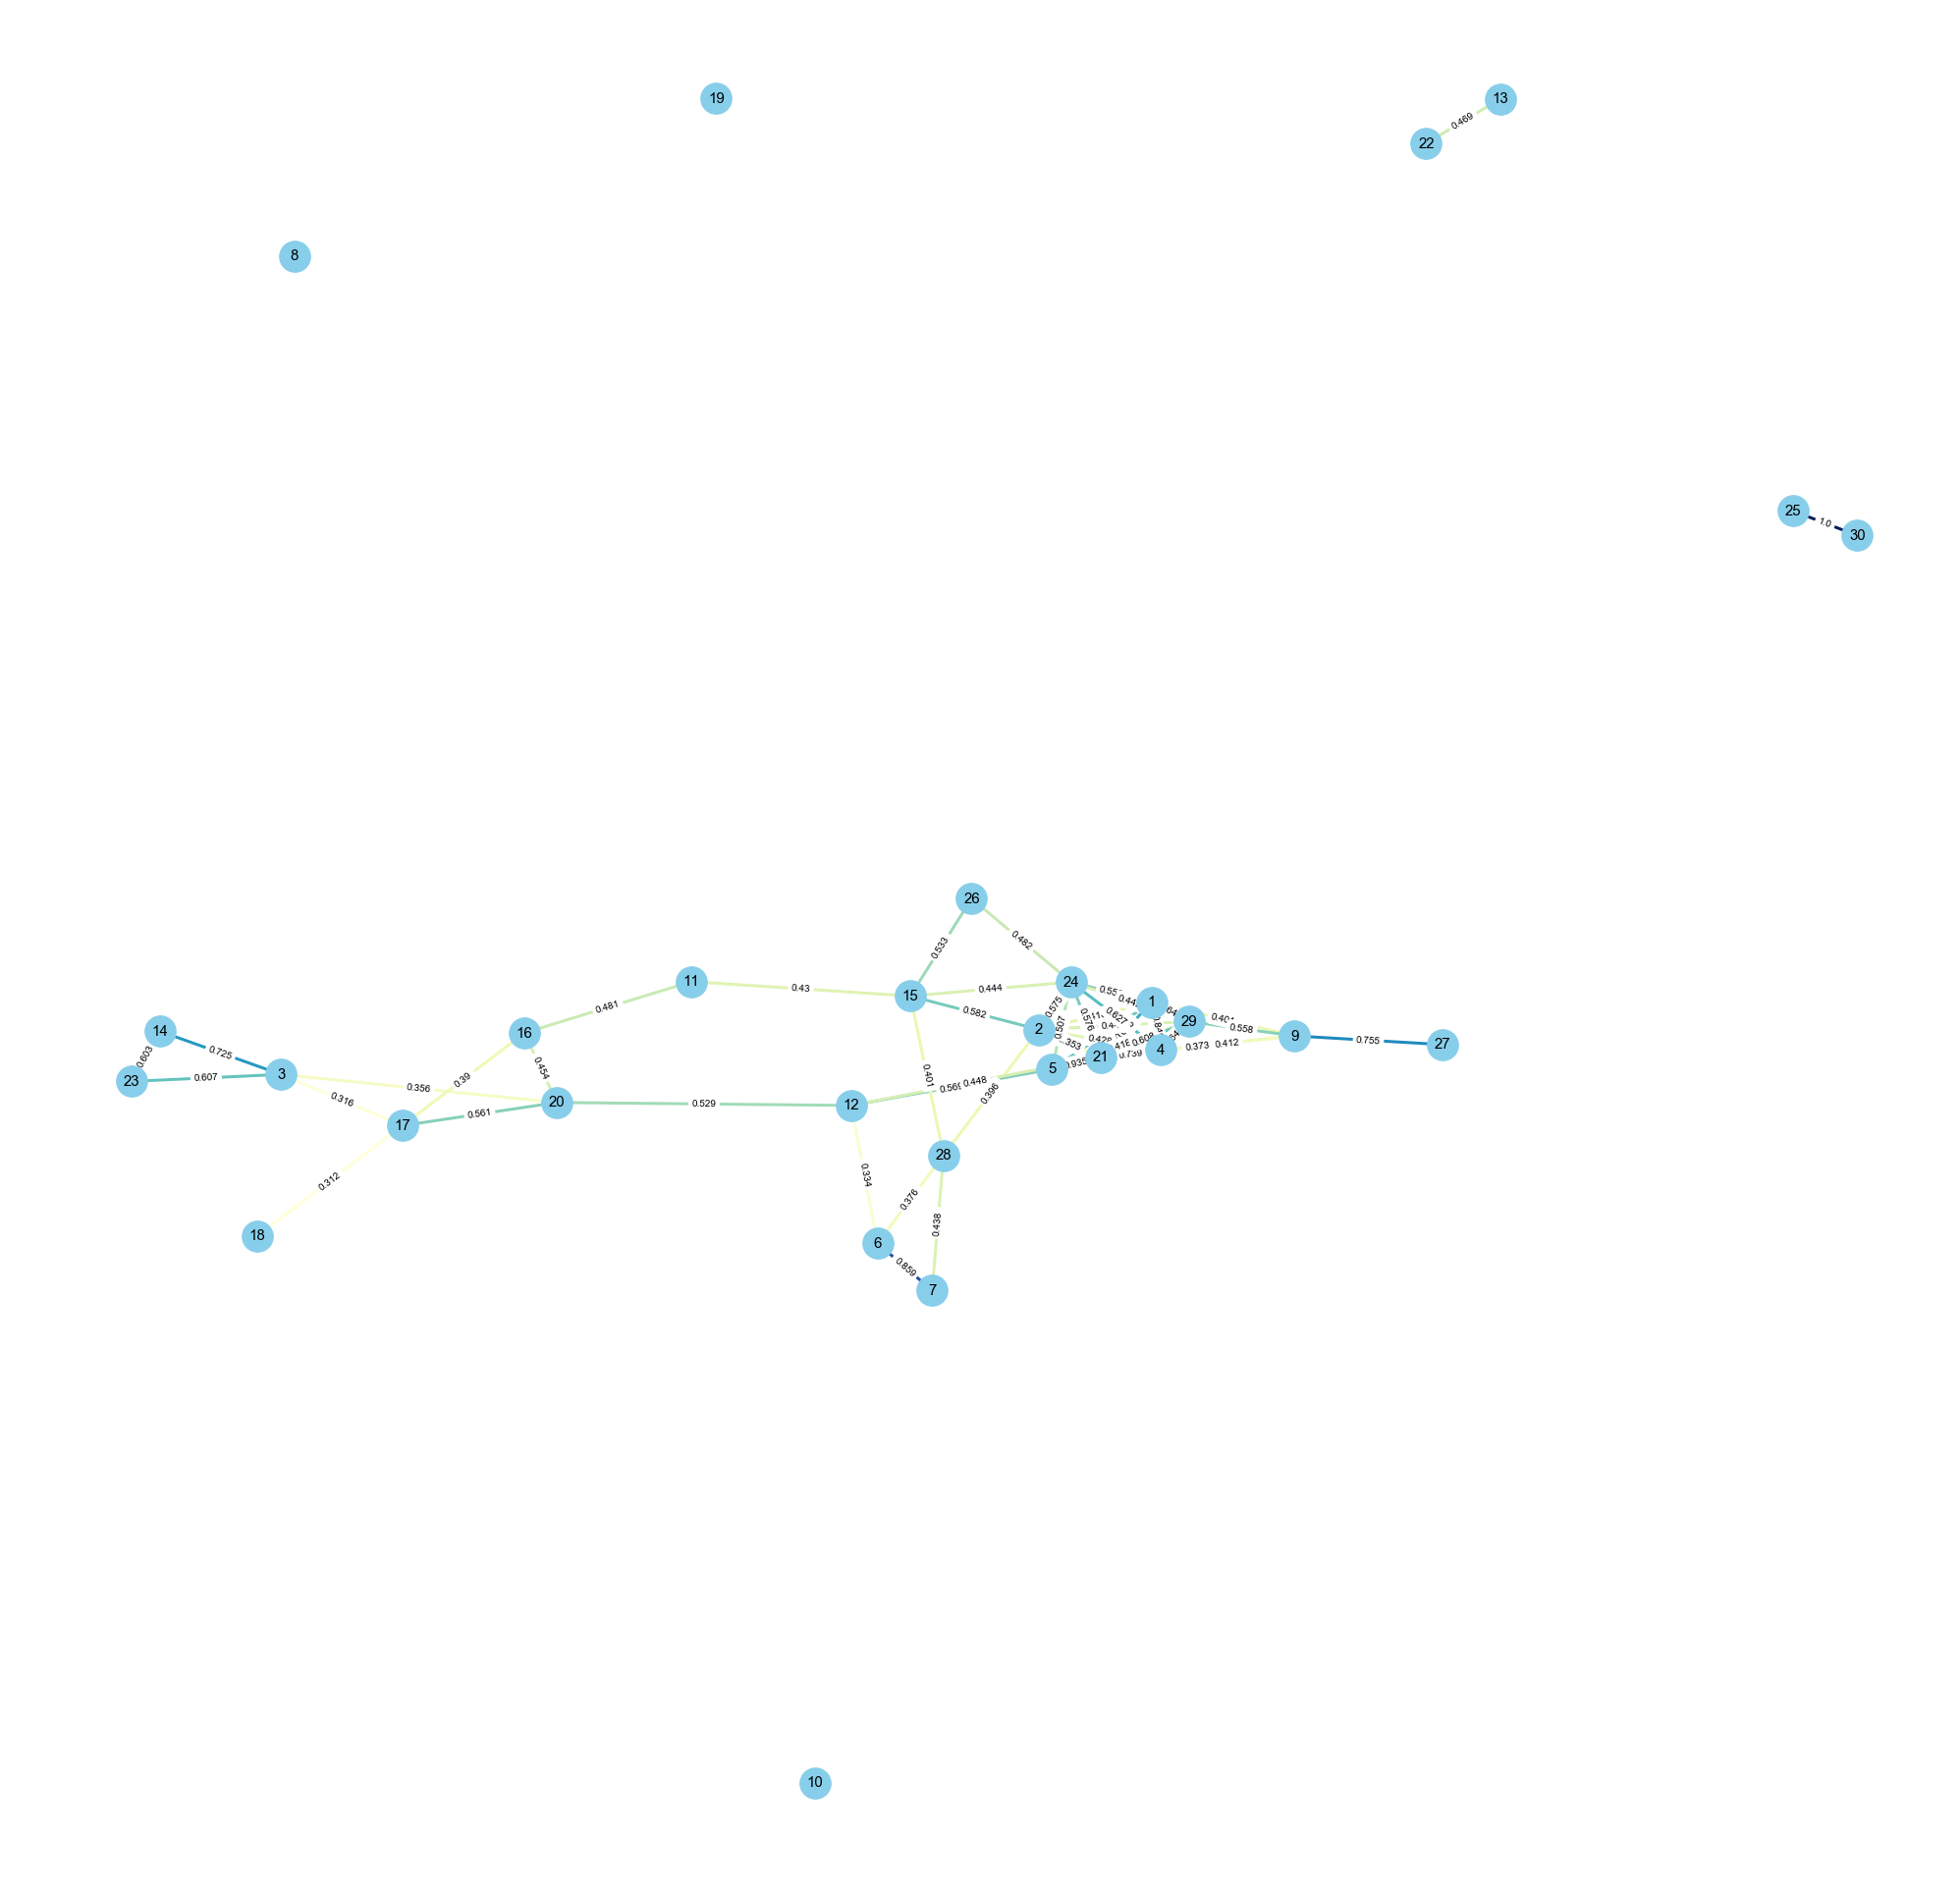

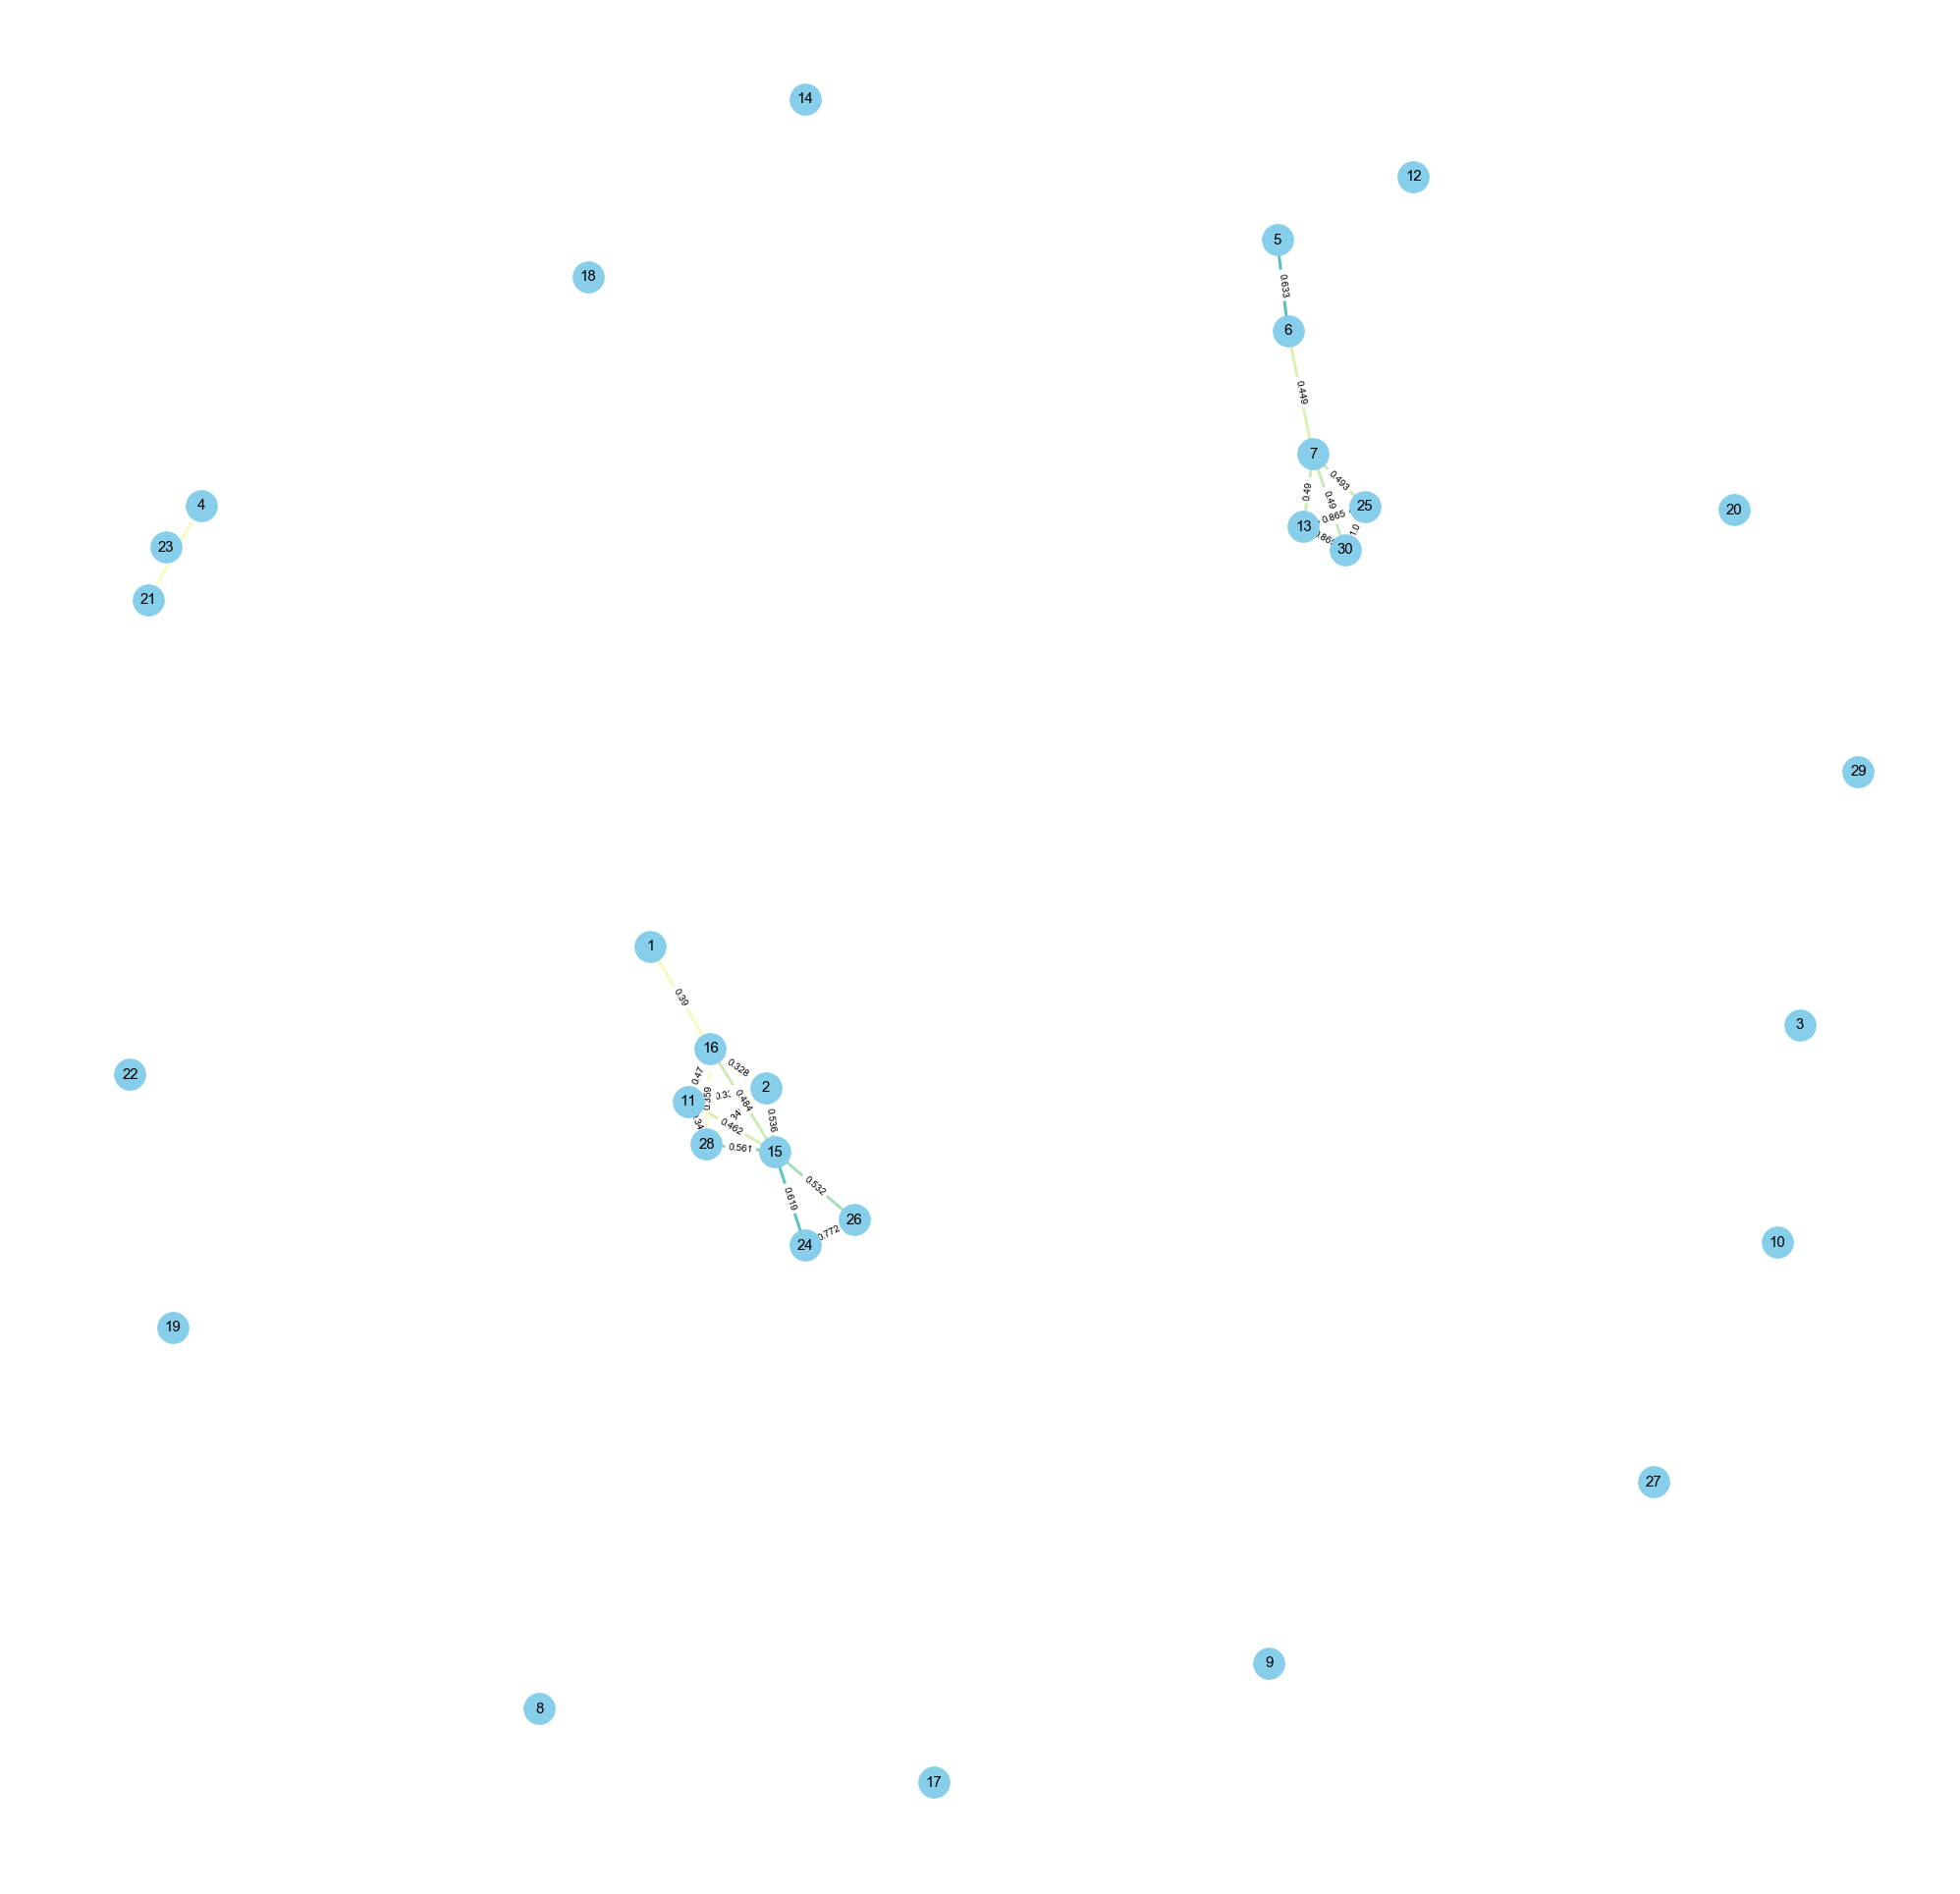

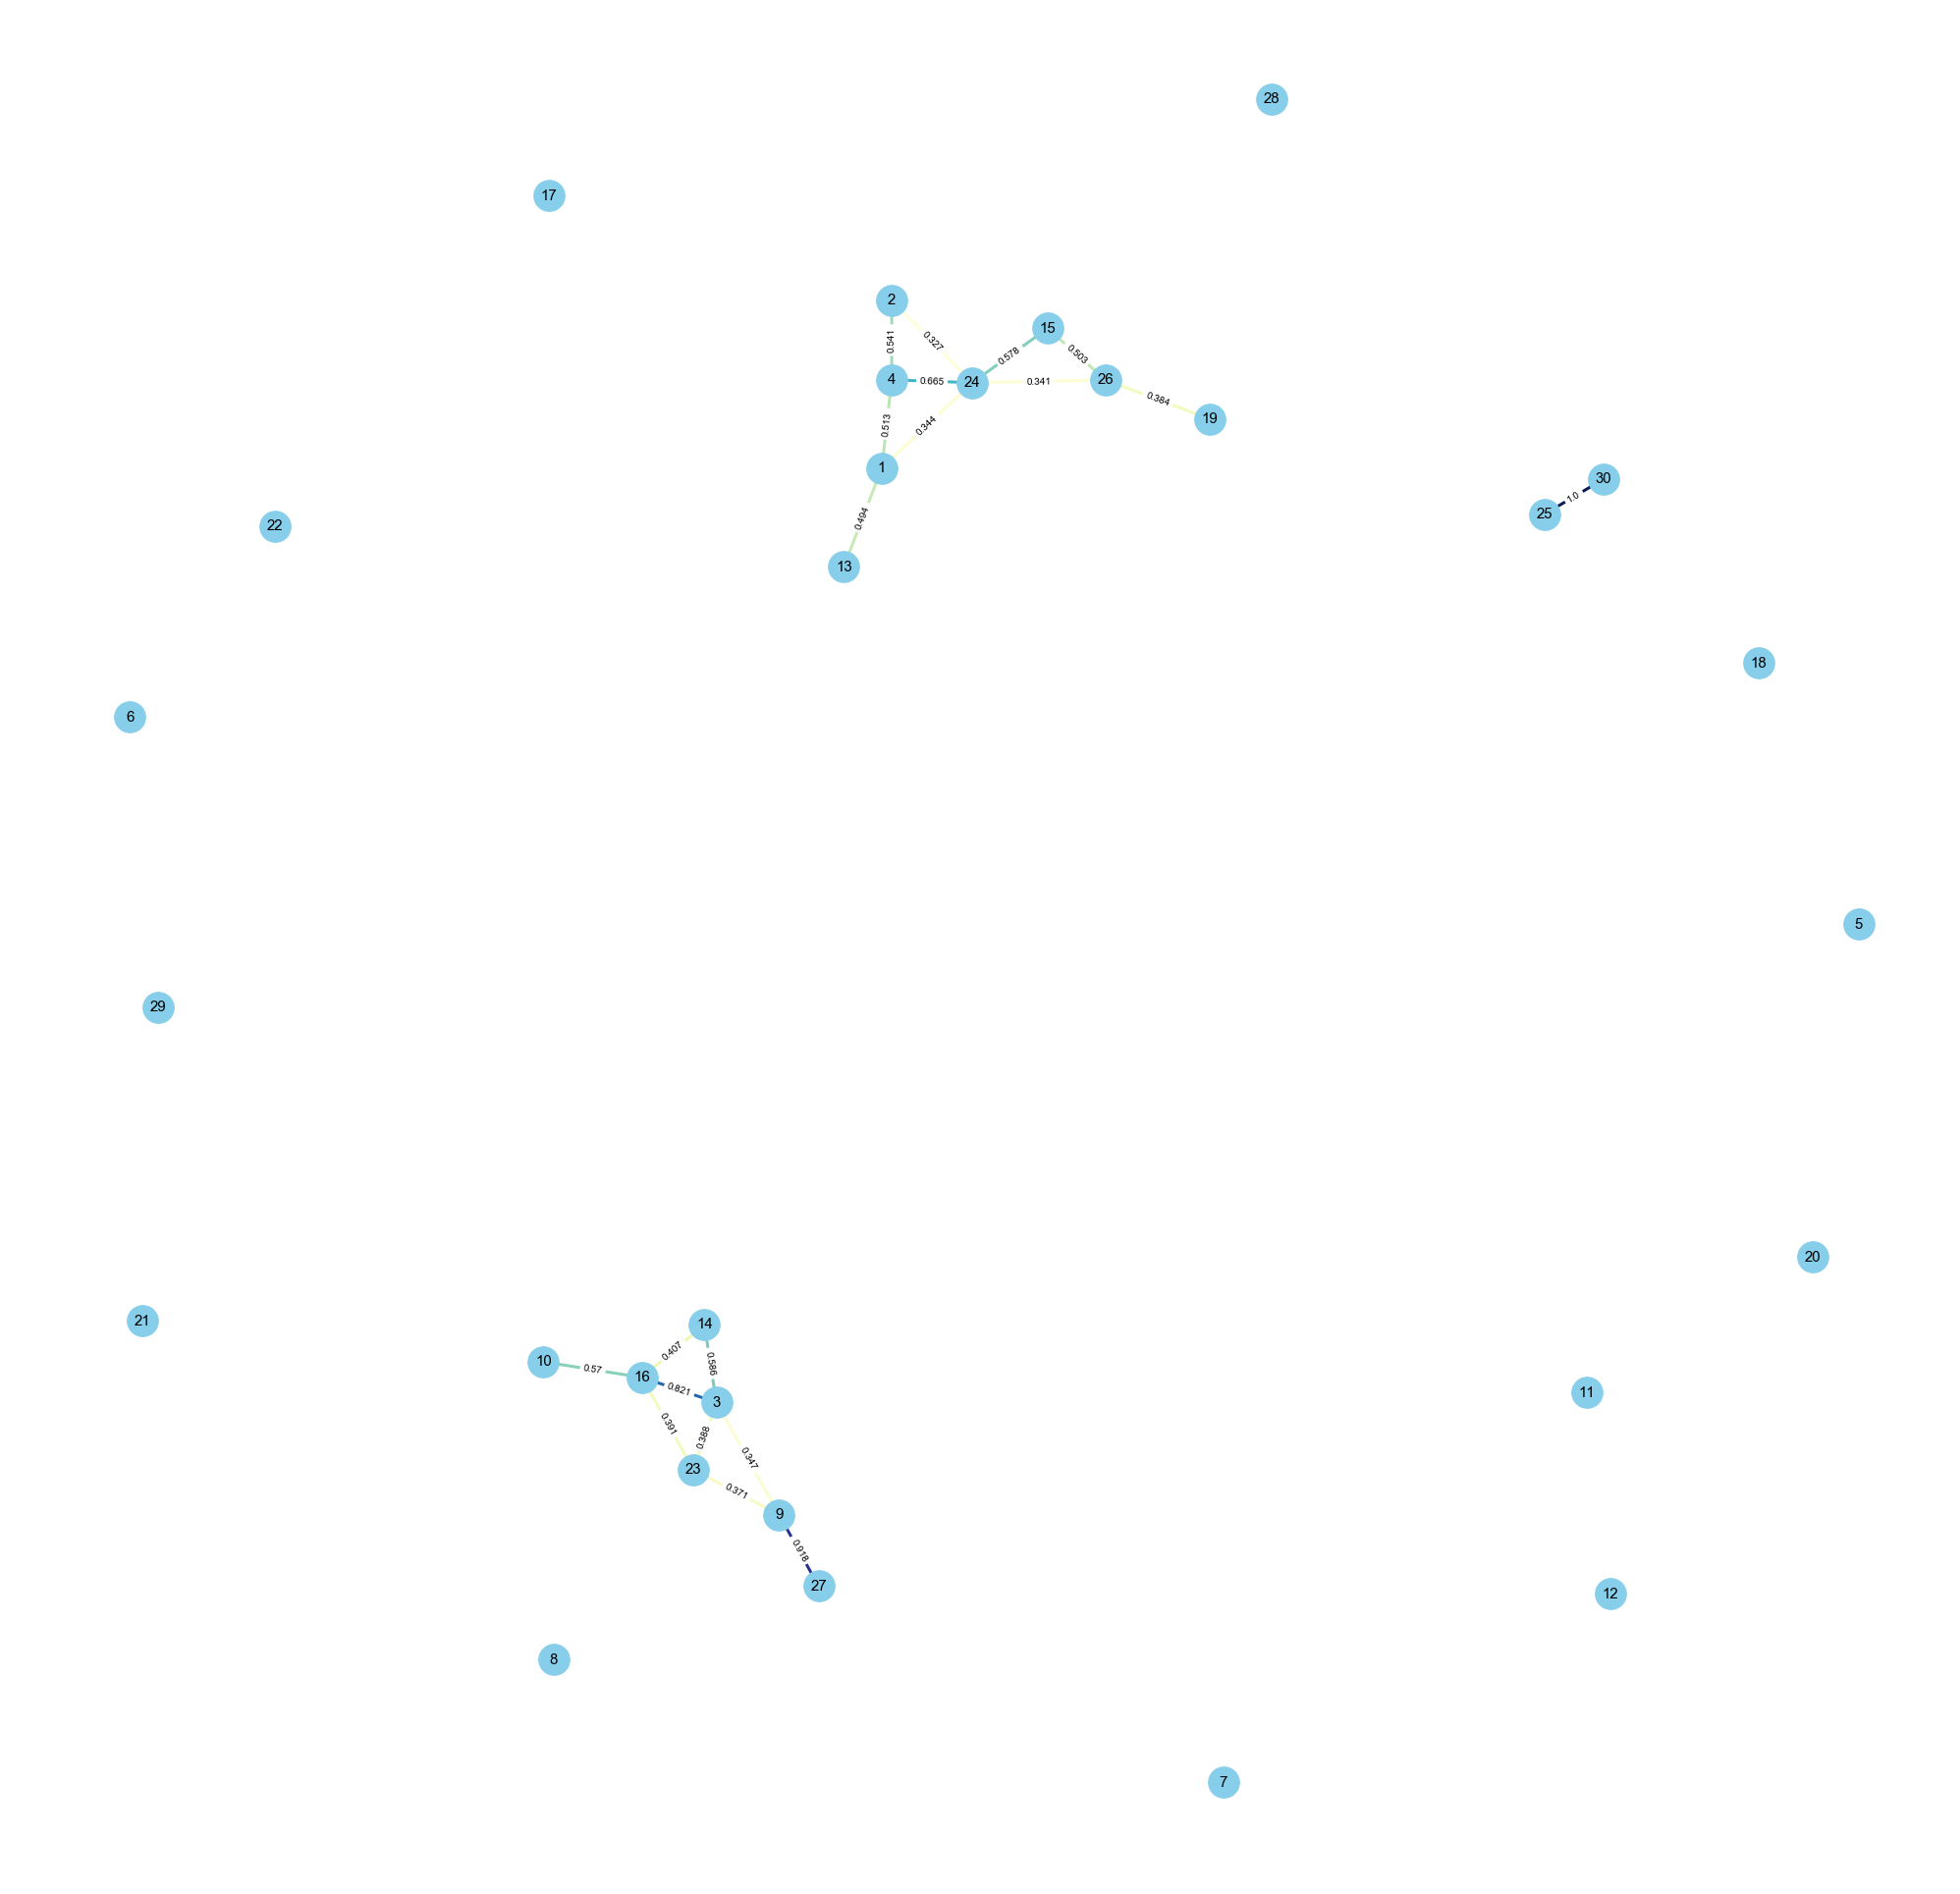

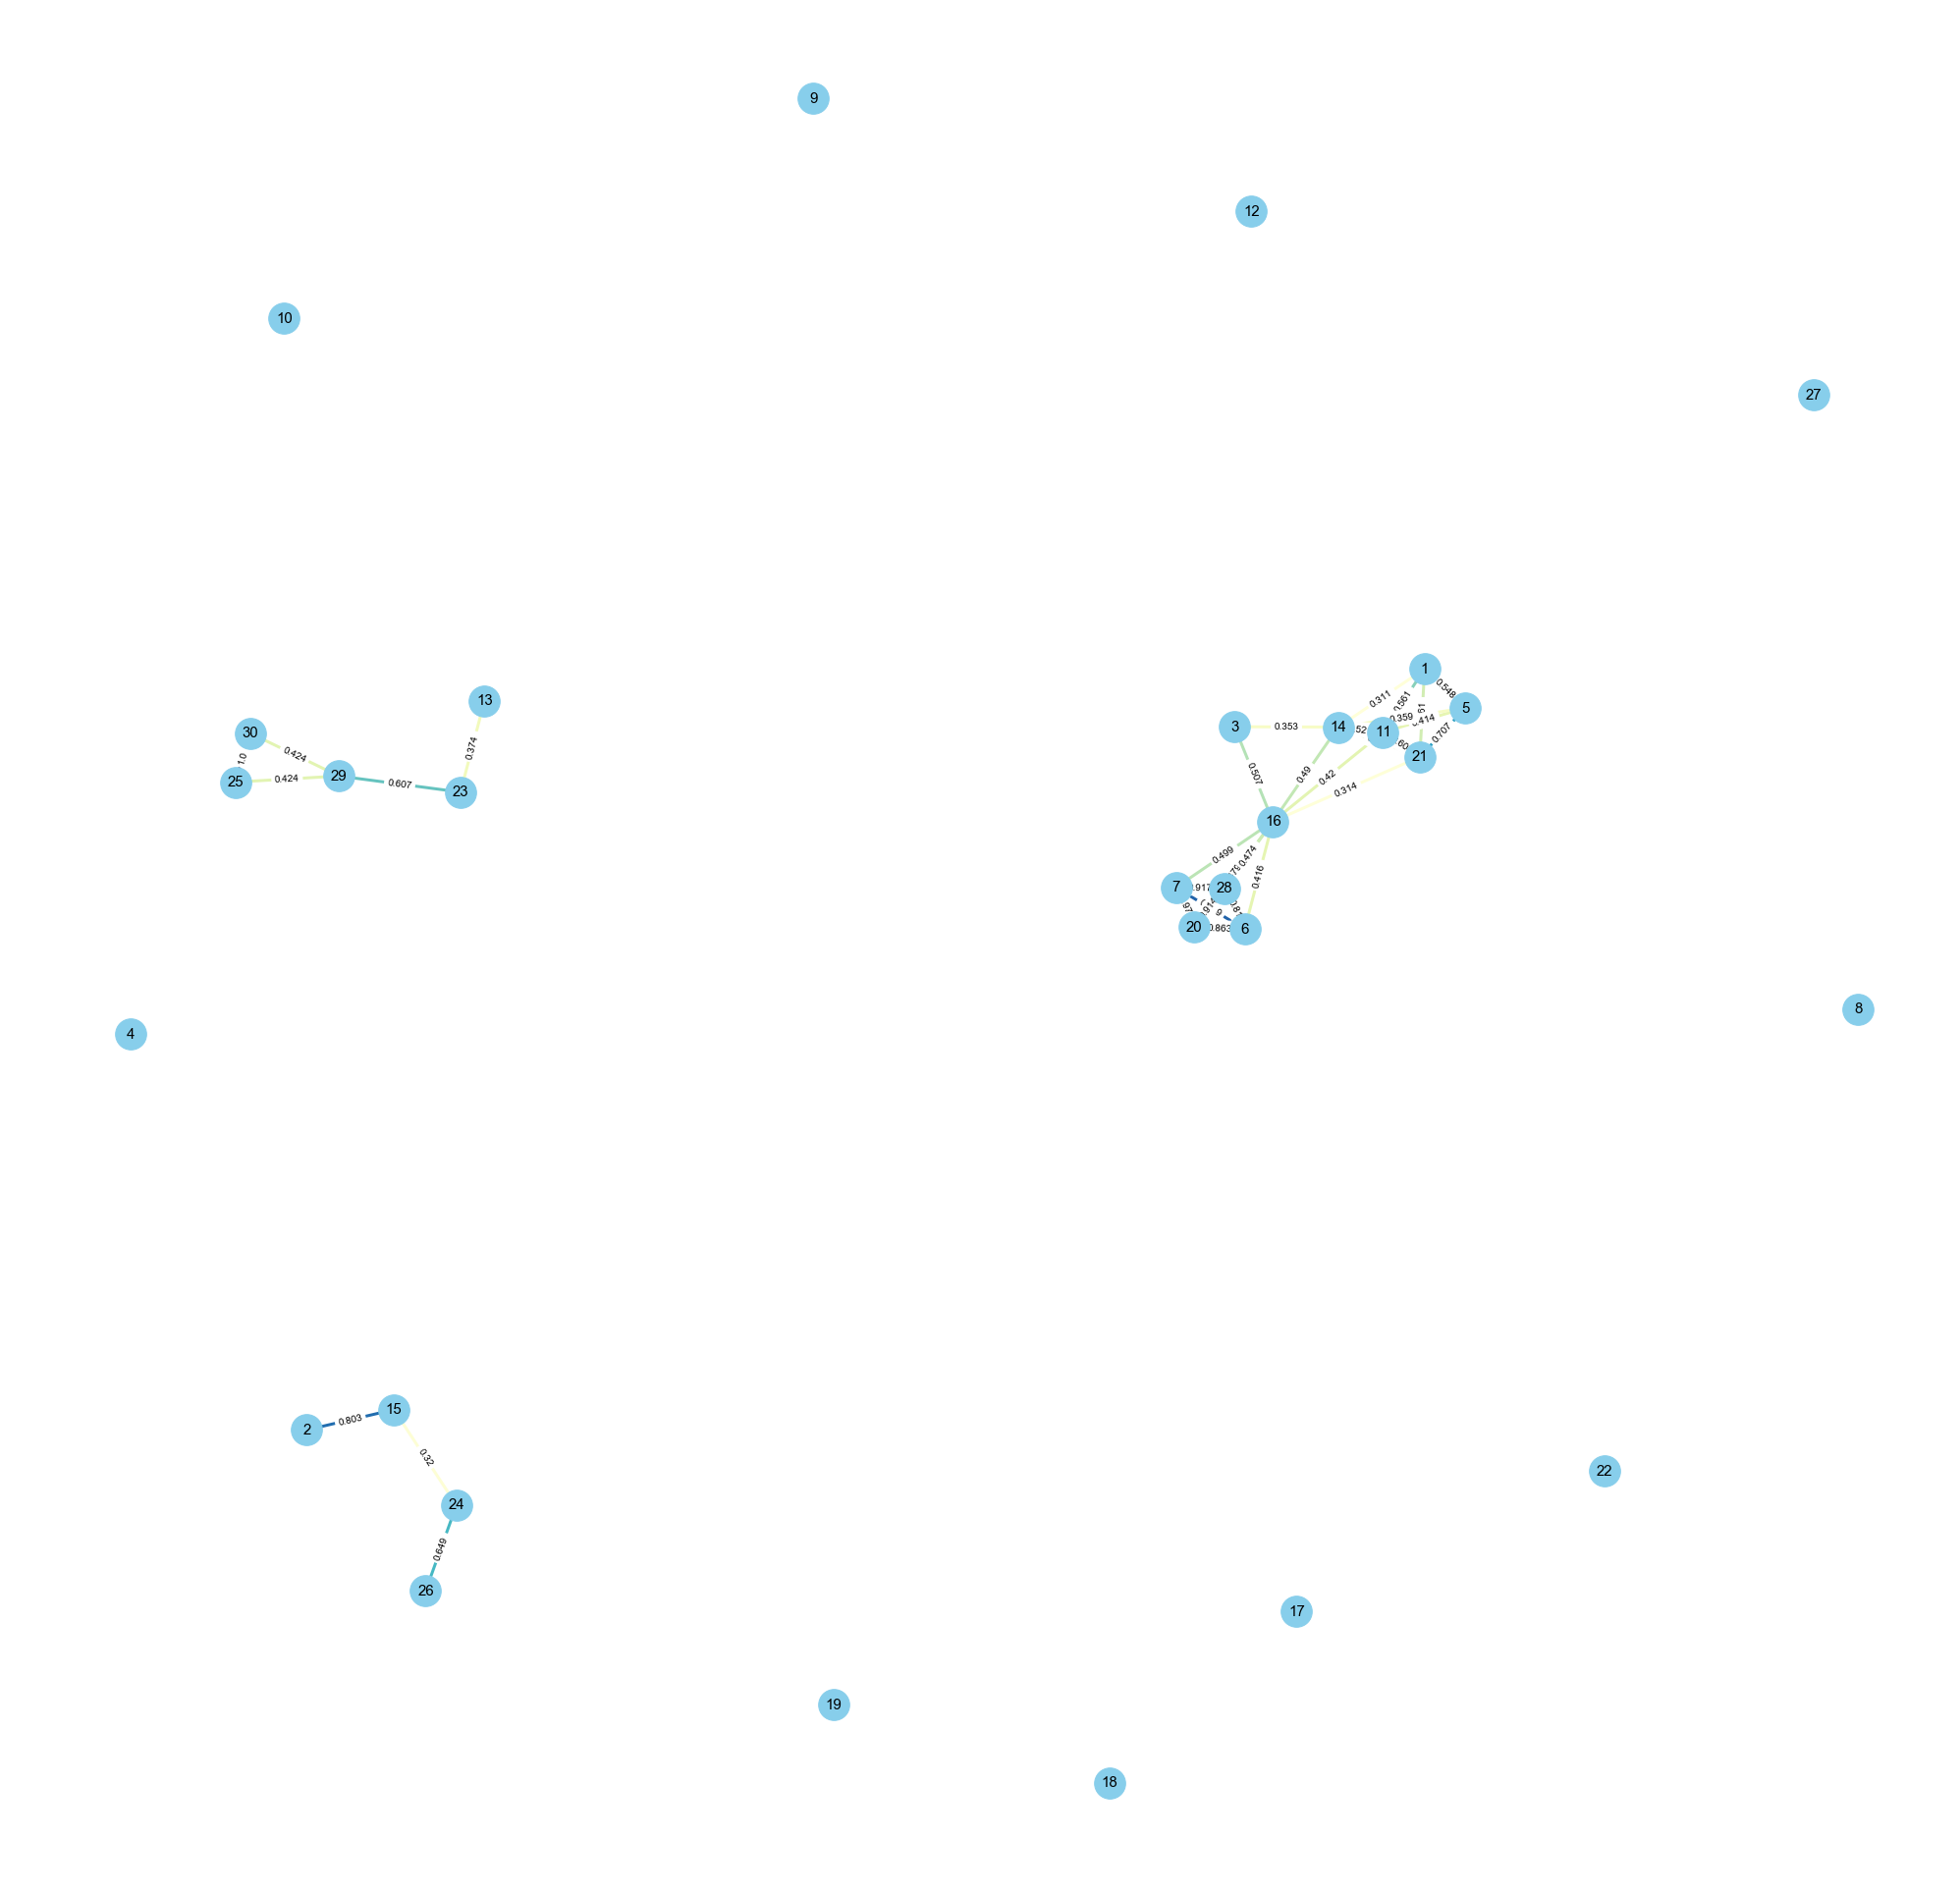

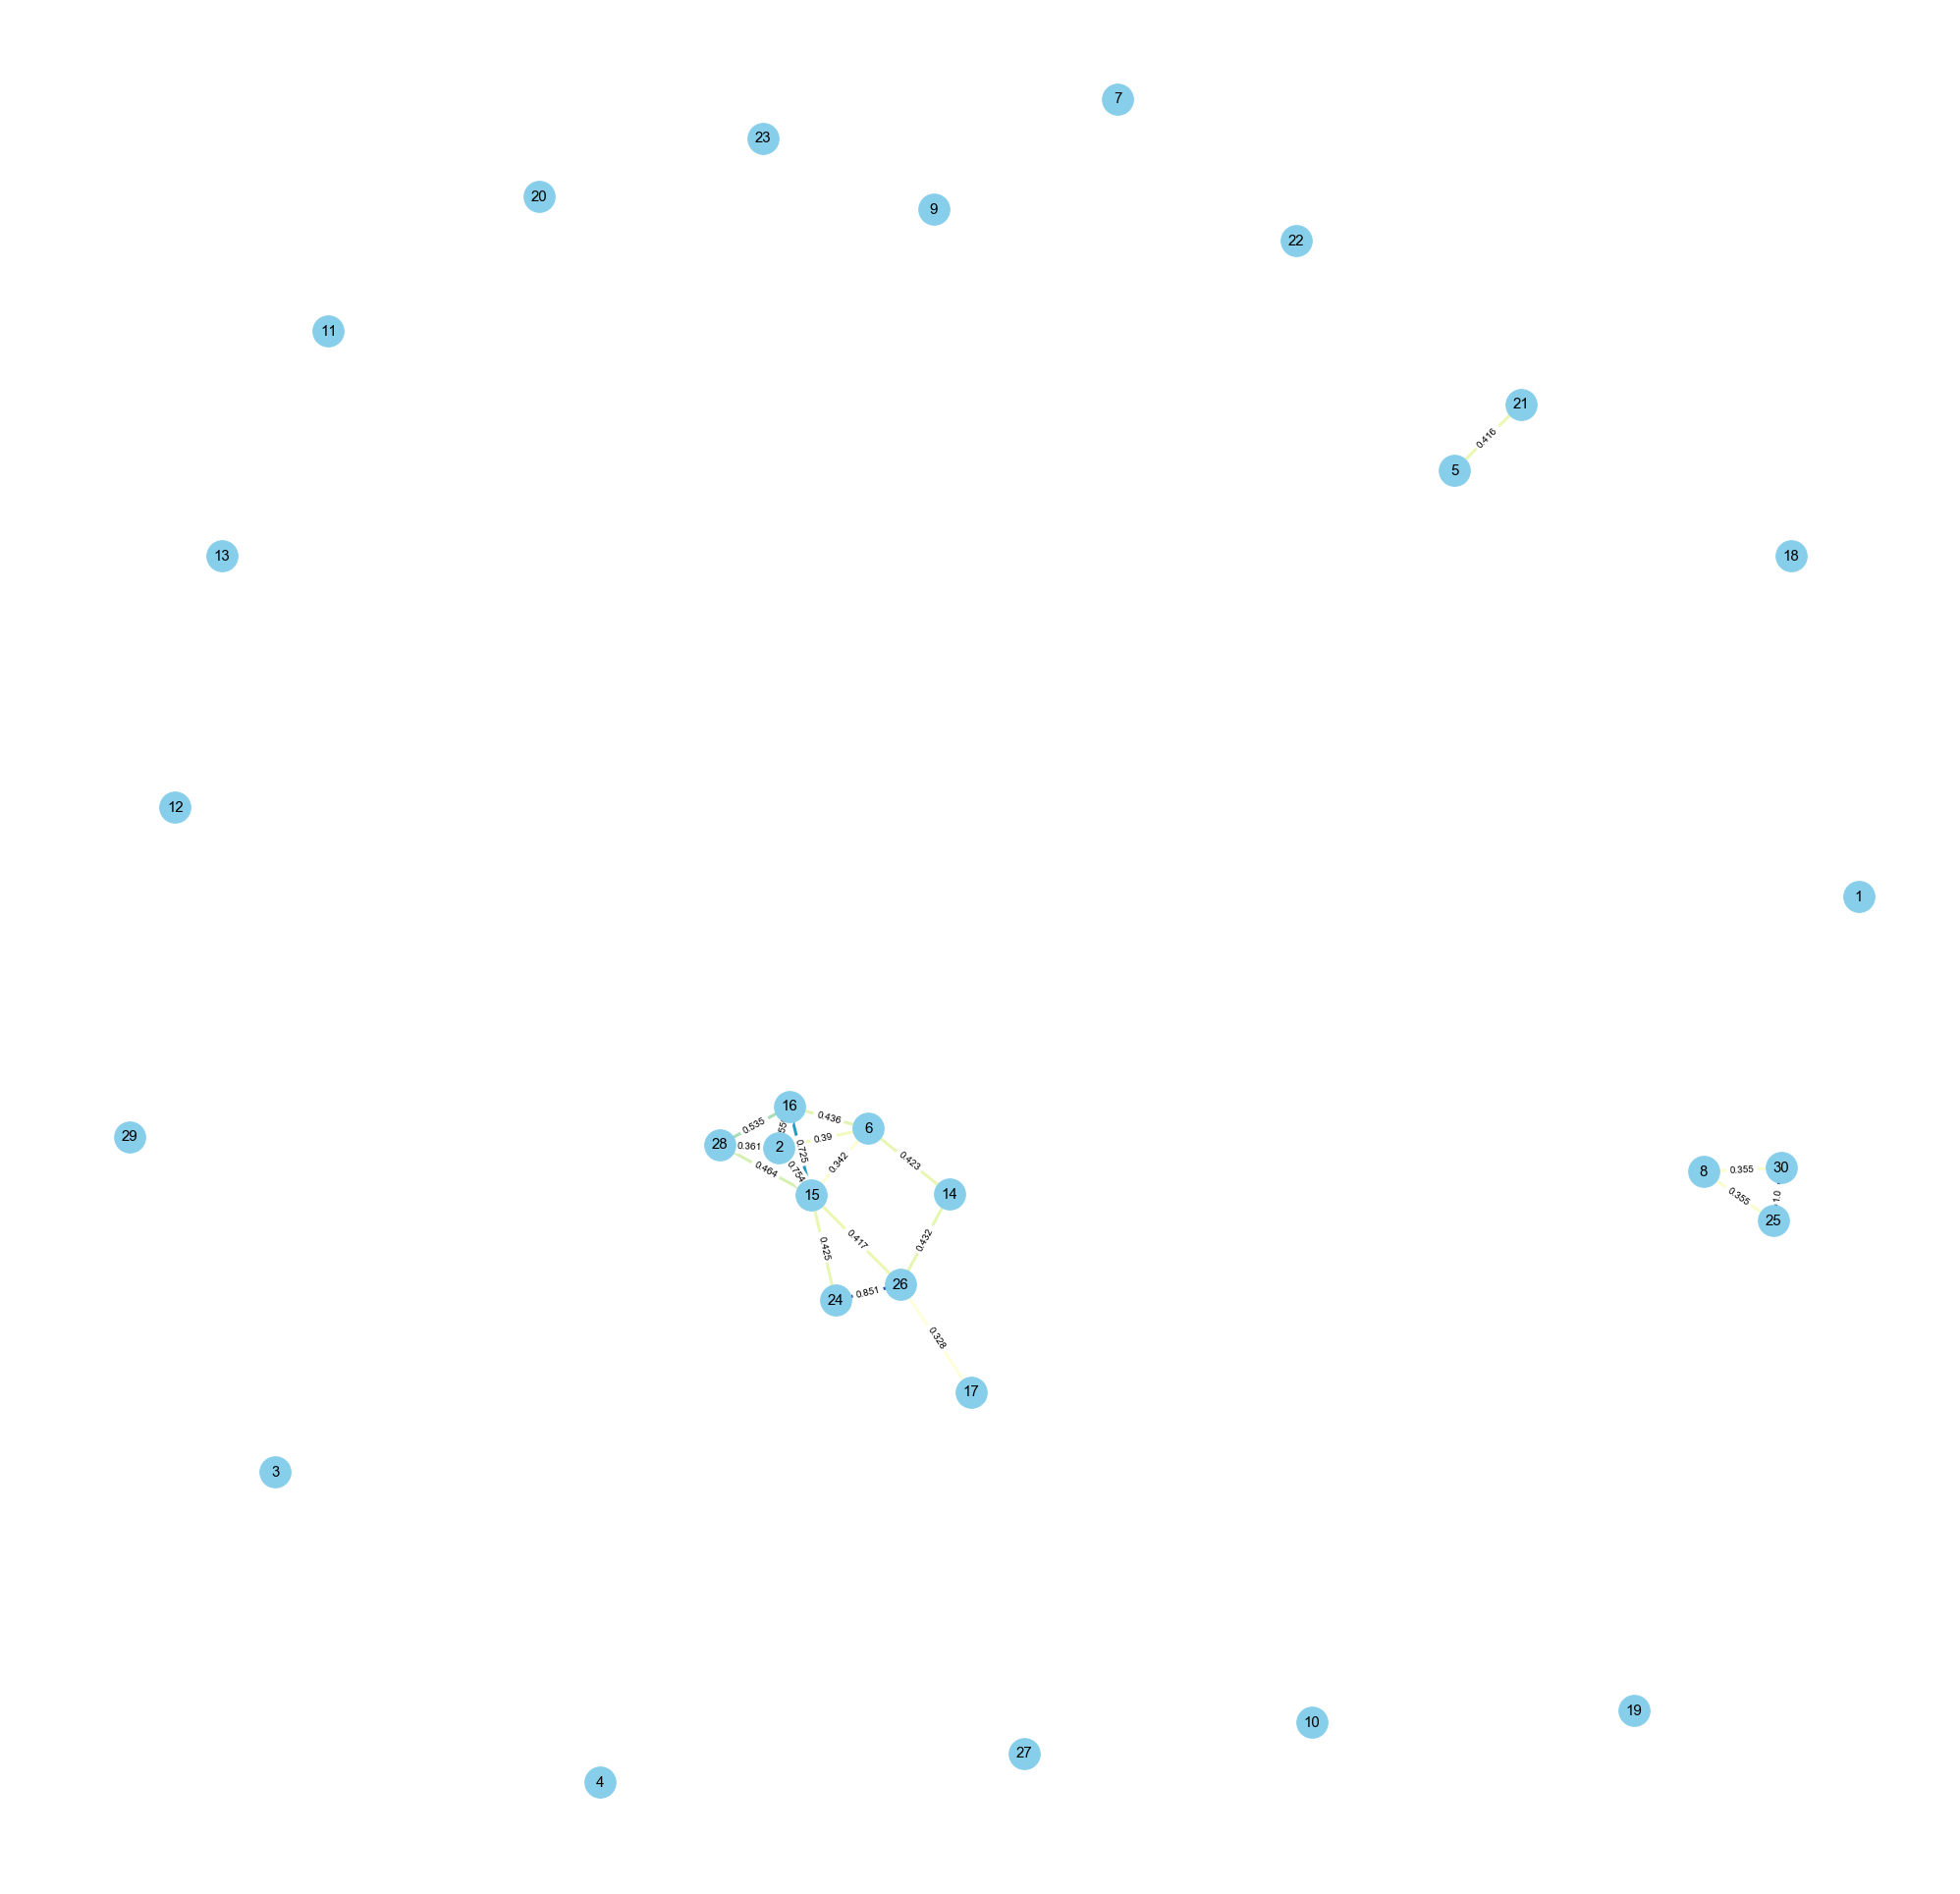

In [10]:
indices = drd77_fe.neuron_concated_behavior.loc[drd77_fe.neuron_concated_behavior["ClosedArms_centerpoint"] != 0].index
time_binned_dfs = bin_by_time(drd77_fe.cell_transients_df.iloc[indices], freq="1Min")

for i in range(len(time_binned_dfs)):
    open_graph = NeuronNetwork(time_binned_dfs[i].reset_index(drop=True))
    open_graph.plot_with_spring_layout(figsize=(35, 35), node_color="skyblue", node_size=1000)

In [11]:
import networkx as nx

def get_continuous_beh_graphs(neuron_network_obj, behavior, **kwargs):
    num_of_sec = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)
    graphs = list()
    
    continuous_beh = dict()
    for row in neuron_network_obj.neuron_concated_behavior.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= num_of_sec*framerate:

                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]

                time_binned_dfs = bin_by_time(cell_transients_dataframe.iloc[begin:end], freq="1Min")
                for df in time_binned_dfs.values():
                    graphs.append(NeuronNetwork(df.reset_index(drop=True)))

                continuous_beh.clear()
            else:
                continuous_beh.clear()
                
    return graphs

In [12]:
import plotly
import plotly.graph_objs as go

def plot_network_measures(y1, y2, x, **kwargs):
    trace1 = go.Scatter(
        x=x,
        y=y1,
        text=y1,
        textposition="auto",
        name="Open Arms",
        mode="lines+markers",
        marker=dict(color="rgb(255, 0, 0)"),
        opacity=0.6
    )
    trace2 = go.Scatter(
        x=x,
        y=y2,
        text=y2,
        textposition="auto",
        name="Closed Arms",
        mode="lines+markers",
        marker=dict(color="rgb(58,200,225)"),
        opacity=0.6
    )
    data = [trace1, trace2]
    layout = go.Layout(
        title = kwargs.get("title", "Title Goes Here"),
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

# Now, we plot the networks, over time, for *continous* activity, for certain behaviors. E.g., $5$ seconds of activity in the **OpenArms**

In [13]:
open_arms_graphs = get_continuous_beh_graphs(drd77_fe, "OpenArms_centerpoint", seconds=2)
closed_arms_graphs = get_continuous_beh_graphs(drd77_fe, "ClosedArms_centerpoint", seconds=2)

In [14]:
open_degree_centralities = list()
for graph in open_arms_graphs:
    open_degree_centralities.append(graph.mean_degree_centrality)

np.mean(open_degree_centralities)
    
closed_degree_centralities = list()
for graph in closed_arms_graphs:
    closed_degree_centralities.append(graph.mean_degree_centrality)

np.mean(closed_degree_centralities)

x_axis = max(len(open_degree_centralities), len(closed_degree_centralities))
plot_network_measures(open_degree_centralities, closed_degree_centralities, x_axis, title="DRD77 Mean Degree Centrality")

0.07038019451812555

0.04298153953326367

In [15]:
open_connection_densities = list()
for graph in open_arms_graphs:
    open_connection_densities.append(graph.connection_density)

np.mean(open_connection_densities)
    
closed_connection_densities = list()
for graph in closed_arms_graphs:
    closed_connection_densities.append(graph.connection_density)

np.mean(closed_connection_densities)

x_axis = max(len(open_connection_densities), len(closed_connection_densities))
plot_network_measures(open_connection_densities, closed_connection_densities, x_axis, title="DRD77 Connection Density")

0.07038019451812555

0.04298153953326367

In [16]:
open_measures = list()
for graph in open_arms_graphs:
    open_measures.append(graph.clustering_coefficient)

np.mean(open_measures)
    
closed_measures = list()
for graph in closed_arms_graphs:
    closed_measures.append(graph.clustering_coefficient)

np.mean(closed_measures)

x_axis = max(len(open_measures), len(closed_measures))
plot_network_measures(open_measures, closed_measures, x_axis, title="DRD77 Clustering Coefficient")

0.22453042154288763

0.18395875828007466

In [17]:
open_measures = list()
for graph in open_arms_graphs:
    open_measures.append(graph.mean_clique_size)

np.mean(open_measures)
    
closed_measures = list()
for graph in closed_arms_graphs:
    closed_measures.append(graph.mean_clique_size)

np.mean(closed_measures)

x_axis = max(len(open_measures), len(closed_measures))
plot_network_measures(open_measures, closed_measures, x_axis, title="DRD77 Mean Clique Size")

2.1718834514723557

1.9000293002574526

In [18]:
open_measures = list()
for graph in open_arms_graphs:
    open_measures.append(graph.max_clique_size)

np.mean(open_measures)
    
closed_measures = list()
for graph in closed_arms_graphs:
    closed_measures.append(graph.max_clique_size)

np.mean(closed_measures)

x_axis = max(len(open_measures), len(closed_measures))
plot_network_measures(open_measures, closed_measures, x_axis, title="DRD77 Max Clique Size")

4.846153846153846

4.363636363636363

In [19]:
open_measures = list()
for graph in open_arms_graphs:
    open_measures.append(graph.global_efficiency)

np.mean(open_measures)
    
closed_measures = list()
for graph in closed_arms_graphs:
    closed_measures.append(graph.global_efficiency)

np.mean(closed_measures)

x_axis = max(len(open_measures), len(closed_measures))
plot_network_measures(open_measures, closed_measures, x_axis, title="DRD77 Global Efficiency")

0.1235889015199359

0.059444859100031514